# Libraries

In [6]:
import os
import numpy as np
import pandas as pd 
#import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.metrics import pairwise_distances
import torch
import itertools

from Code.data_generator import generate_data
from Code.bert_stuff import process_dataframe
from Code.utils import write, read, cluster, localisation, localisation_coefficient, metric, GDVvals, GDV, inversePCA, actdict2actmat

import matplotlib.patches as mpatches

default_path = os.getcwd()

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Data pipeline

In [7]:
datapath = os.path.join(default_path,"Project_XAI_orig1000_gpt4o.csv")

df = pd.read_csv(datapath)

### Original Text Pieces

In [13]:
shkp = "If music be the food of love, play on. Give me excess of it, that, surfeiting, the appetite may sicken and so die. That strain again! It had a dying fall. O, it came o'er my ear like the sweet sound that breathes upon a bank of violets, stealing and giving odor. Enough; no more.'Tis not so sweet now as it was before."
tale2ct = "There were a king with a large jaw and a queen with a plain face, on the throne of England; there were a king with a large jaw and a queen with a fair face, on the throne of France. In both countries it was clearer than crystal to the lords of the State preserves of loaves and fishes, that things in general were settled for ever."
jnair = "There was no possibility of taking a walk that day. We had been wandering, indeed, in the leafless shrubbery an hour in the morning; but since dinner (Mrs. Reed, when there was no company, dined early) the cold winter wind had brought with it clouds so sombre, and a rain so penetrating, that further out-door exercise was now out of the question."
hound = "Mr. Sherlock Holmes, who was usually very late in the mornings, save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick which our visitor had left behind him the night before. It was a fine, thick piece of wood, bulbous-headed, of the sort which is known as a 'Penang lawyer.'"
tth = "TRUE!—nervous—very, very dreadfully nervous I had been and am; but why will you say that I am mad? The disease had sharpened my senses—not destroyed—not dulled them. Above all was the sense of hearing acute. I heard all things in the heaven and in the earth. I heard many things in hell. How, then, am I mad?"
dwd = "The night was rank with the smell of man. The warg stopped beneath a tree and sniffed, his grey-brown fur dappled by shadow. A sigh of piney wind brought the man-scent to him, over fainter smells that spoke of fox and hare, seal and stag, even wolf. Those were man-smells too, the warg knew; the stink of old skins, dead and sour, near drowned beneath the stronger scents of smoke and blood and rot."
wlfcg = "'Are there any old legends attached to the castle?' asked Conrad of his sister. Conrad was a prosperous Hamburg merchant, but he was the one poetically-dispositioned member of an eminently practical family.The Baroness Gruebel shrugged her plump shoulders.'There are always legends hanging about these old places. They are not difficult to invent and they cost nothing.'"
leaf = "In a small part of the city west of Washington Square, the streets have gone wild. They turn in different directions. They are broken into small pieces called “places.” One street goes across itself one or two times. A painter once discovered something possible and valuable about this street. Suppose a painter had some painting materials for which he had not paid. Suppose he had no money."
angdem = "As he climbed, his vision began to blur. There was a thundering in his ears. I must reach her! But when he looked up again, the woman had disappeared. In her place stood an old man with rotting teeth. The man stared down, curling his lips into a lonely grimace. Then he let out a scream of anguish that resounded across the desert."
men3bt = "We were all feeling terrible, and we were getting quite nervous about it. Harris and George said they hardly knew what they were doing at times. With me, it was my liver that was out of order. I knew it was my liver that was out of order, because I had just been reading an article which described the various symptoms by which a man could tell when his liver was out of order. I had them all."
len(men3bt)

393

### Building 1000pt dataset

In [14]:
shakespeare = [
    ["If music be the food of love, play on. Give me excess of it, that, surfeiting, the appetite may sicken and so die. That strain again! It had a dying fall. O, it came o'er my ear like the sweet sound that breathes upon a bank of violets, stealing and giving odor. Enough; no more.'Tis not so sweet now as it was before.",
     "If music be the sustenance of affection, continue playing. Give me an abundance of it, that, in overindulgence, the craving may wane and eventually perish. That tune once more! It had a melancholic descent. Oh, it arrived at my ear like the gentle whisper that caresses a bed of violets, pilfering and bestowing fragrance. Enough; no more. It is not as delightful now as it was previously.",
     "If music is the nourishment of love, let it continue. Allow me an excess of it, that, in surfeit, the desire may wane and thus expire. That melody once again! It had a sorrowful decline. Oh, it reached my ear like the gentle murmur that breathes upon a cluster of violets, subtly taking and giving scent. Enough; no more. It is not as sweet now as it was before.",
     "If music be the sustenance of affection, then continue. Provide me with an abundance of it, so that, in overindulgence, the desire may wane and thus perish. That tune again! It had a melancholic decline. Oh, it reached my ear like the gentle murmur that breathes upon a cluster of violets, subtly taking and giving fragrance. Enough; no more. It is not as delightful now as it was previously.",
     "If music be the sustenance of passion, play on. Give me excess of it, that, in overindulgence, the yearning may sicken and thus perish. That strain once more! It had a spectral fall. Ah, it glided o’er my ear like the dulcet tones that breathe upon a bank of violets, pilfering and bestowing their ghostly essence. Enough; no more. It is not as enchanting now as it once was.",
     "If music be the sustenance of love, then let it play on. Give me an excess of it, that, in overindulgence, the craving may wane and thus die. That tune again! It had a sorrowful fall. Ah, it drifted o’er my ear like the sweet sound that whispers upon a bank of violets, stealing and giving scent. Enough; no more. It is not as sweet now as it was before.",
     "If music be the sustenance of love, then let it continue. Provide me with an excess of it, that, in overindulgence, the appetite may sicken and thus expire. That melody again! It had a dying cadence. Oh, it reached my ear like the sweet sound that breathes upon a bed of violets, stealing and bestowing fragrance. Enough; no more. It is not as delightful now as it once was.",
     "If music be the sustenance of love, play on. Give me an excess of it, that, in surfeit, the appetite may sicken and so perish. That tune again! It had a fading fall. Ah, it came over my ear like the sweet sound that whispers upon a bank of violets, stealing and giving fragrance. Enough; no more. It is not as sweet now as it was before.",
     "If music be the sustenance of love, let it continue. Provide me with an excess, that, overindulging, the desire may wane and thus perish. That strain once more! It had a declining cadence. Oh, it came over my ear like the sweet sound that breathes upon a bed of violets, pilfering and bestowing scent. Enough; no more. It is not as sweet now as it was before.",
     "If music be the sustenance of love, then play on. Give me an excess of it, that, in overindulgence, the appetite may sicken and thus die. That strain once more! It had a dying fall. Oh, it came over my ear like the sweet sound that breathes upon a bed of violets, pilfering and bestowing fragrance. Enough; no more. It is not as delightful now as it was before."],

     ["If music be the food of love, play on. Give me excess of it, that, surfeiting, the appetite may sicken and so die. That strain again! It had a dying fall. O, it came o'er my ear like the sweet sound that breathes upon a bank of violets, stealing and giving odor. Enough; no more.'Tis not so sweet now as it was before.",
     "If music be the sustenance of affection, continue to play. Let me have it in abundance, so that, in overindulgence, the desire may become nauseated and perish. That melody again! It had a waning cadence. Oh, it arrived at my ear like the gentle whisper that caresses a bed of violets, borrowing and bestowing fragrance. Enough; no more. It is not as delightful now as it was before.",
     "If music is indeed the nourishment of love, let it play on. Grant me an excess of it, so that, in its overabundance, the craving may grow faint and thus expire. That tune again! It had a melancholic descent. Oh, it came over my ear like the sweet murmur that drifts across a bed of violets, taking and giving scent. Enough; no more. It is not as sweet now as it once was.",
     "If music serves as the sustenance of love, let it continue. Provide me with an excess of it, that, in its surfeit, the appetite may wane and thereby expire. That strain again! It had a descending tone. Ah, it crossed my ear like the delicate sound that breathes upon a bed of violets, pilfering and dispensing aroma. Enough; no more. It is not as pleasant now as it was before.",
     "If music be the sustenance of love, then play on. Give me an excess of it, that, in its surfeit, the appetite may grow ill and thus perish. That strain again! It had a melancholic cadence. Oh, it came upon my ear like the sweet sound that whispers over a bank of violets, stealing and bestowing odor. Enough; no more. ’Tis not so sweet now as it was before.",
     "If music be the nourishment of love, play on. Give me excess of it, that, in its surfeit, the appetite may sicken and die. That tune again! It had a somber fall. Oh, it came over my ear like the sweet sound that sweeps across a bank of violets, stealing and giving scent. Enough; no more. It is not as sweet now as it was before.",
     "If music be the sustenance of love, continue. Give me an abundance of it, that, in its excess, the appetite may grow nauseated and thus perish. That strain again! It had a languid fall. Oh, it came over my ear like the delicate sound that whispers upon a bed of violets, thieving and bestowing fragrance. Enough; no more. It is not as delightful now as it was before.",
     "If music be the nourishment of love, let it continue to play. Give me an overabundance, that, surfeited, the desire may sicken and thus die. That melody again! It had a fading note. Oh, it came over my ear like the sweet sound that breathes upon a bed of violets, stealing and giving scent. Enough; no more. It’s not as sweet now as it was before.",
     "If music be the sustenance of love, play on. Give me an excess of it, that, in surfeiting, the appetite may become sick and thus die. That strain again! It had a haunting descent. Oh, it crossed my ear like the sweet sound that floats upon a bed of violets, stealing and giving fragrance. Enough; no more. It is not as sweet now as it was before.",
     "If music be the food of love, play on. Give me an overabundance of it, that, surfeiting, the appetite may grow sick and die. That strain again! It had a dying fall. Oh, it came over my ear like the sweet sound that breathes upon a bed of violets, stealing and giving odor. Enough; no more. It isn’t as sweet now as it was before."],


     ["If music be the food of love, play on. Give me excess of it, that, surfeiting, the appetite may sicken and so die. That strain again! It had a dying fall. O, it came o'er my ear like the sweet sound that breathes upon a bank of violets, stealing and giving odor. Enough; no more.'Tis not so sweet now as it was before.",
     "If music be the sustenance of affection, continue the melody. Overwhelm me with it, that, by indulging in abundance, the desire may falter and thus perish. That note again! It had a melancholic cadence. Ah, it graced my ear like the gentle murmur that whispers over a bed of violets, purloining and bestowing fragrance. Enough; no further. It is not as delightful now as it was aforetime.",
     "If music is the nourishment of passion, let it persist. Grant me an excess of it, that, by overwhelming, the craving may languish and thus expire. That melody once more! It had a poignant descent. Oh, it touched my ear like the tender murmur that wafts across a bed of violets, subtly taking and giving scent. No more; it suffices. It is not as entrancing now as it was before.",
     "If music be the sustenance of love, proceed. Allow me an abundance of it, that, in satiation, the desire may wane and thus be extinguished. That refrain again! It possessed a melancholic descent. Ah, it traversed my ear like the gentle note that whispers over a bed of violets, discreetly acquiring and imparting aroma. Enough; cease. It is not as pleasant now as it was previously.",
     "If music be the sustenance of love, let it endure. Let me be inundated with it, that, in excess, the longing may weaken and thus perish. That note once more! It had a spectral decline. Oh, it whispered to my ear like the ghostly sound that breathes upon a bed of violets, stealing and imparting scent. Enough; no further. It is not as ethereal now as it was erstwhile.",
     "If music be the nourishment of love, let it continue. Drown me in it, that, by excess, the craving may falter and thus perish. That note again! It had a somber descent. Ah, it swept over my ear like the gentle sound that whispers across a field of violets, taking and giving fragrance. Enough; no more. It is not as sweet now as it was before.",
     "If music be the sustenance of love, carry on. Give me an excess of it, that, in overindulgence, the appetite may falter and thus perish. That strain again! It had a wistful fall. Oh, it drifted over my ear like the delicate sound that breathes upon a cluster of violets, subtly stealing and giving scent. Enough; no more. It is not as delightful now as it was before.",
     "If music be the nourishment of love, let it continue. Give me an excess of it, that, by indulgence, the desire may wane and thus fade away. That tune again! It had a languid fall. Oh, it caressed my ear like the gentle sound that breathes upon a bed of violets, borrowing and giving fragrance. Enough; no more. It is not as sweet now as it was before.",
     "If music is the fuel of love, let it play on. Give me an abundance of it, so that, in overindulgence, the appetite may sicken and thus die. That melody again! It had a fading resonance. Oh, it came over my ear like the sweet sound that whispers across a bed of violets, stealing and imparting fragrance. Enough; no more. It is not as sweet now as it was before.",
     "If music be the sustenance of love, continue. Give me an abundance of it, that, in excess, the appetite may sicken and thus fade away. That note again! It had a melancholy cadence. Oh, it floated to my ear like the sweet sound that breathes upon a bank of violets, subtly stealing and giving scent. Enough; no more. It is not as delightful now as it was before."],


     ["If music be the food of love, play on. Give me excess of it, that, surfeiting, the appetite may sicken and so die. That strain again! It had a dying fall. O, it came o'er my ear like the sweet sound that breathes upon a bank of violets, stealing and giving odor. Enough; no more.'Tis not so sweet now as it was before.",
     "If music be the nourishment of love, then let it continue. Give me an abundance of it, that, in its excess, the desire may weaken and perish. That melody again! It had a sorrowful descent. Oh, it swept over my ear like the gentle sound that whispers over a bed of violets, pilfering and bestowing fragrance. Enough; no more. ’Tis not as sweet now as it was before.",
     "If music be the sustenance of love, let it play on. Give me an overabundance, that, in its fullness, the craving may become repulsive and thus expire. That strain again! It had a melancholy fall. Oh, it came over my ear like the delicate sound that breathes upon a bank of violets, stealing and imparting fragrance. Enough; no more. It is not as sweet now as it was before.",
     "If music is the nourishment of love, play on. Give me excess of it, that, overindulging, the appetite may become jaded and so perish. That strain again! It had a somber fall. Oh, it came over my ear like the sweet sound that breathes upon a bed of violets, stealing and giving scent. Enough; no more. It is not so sweet now as it was before.",
     "If music be the sustenance of love, play on. Give me an excess of it, that, surfeiting, the appetite may sicken and so die. That strain again! It had a dying fall. Oh, it came over my ear like the ethereal sound that whispers upon a bank of violets, purloining and bestowing odor. Enough; no more. ’Tis not so sweet now as it was before.",
     "If music be the sustenance of love, let it play on. Give me an overabundance, that, in its surplus, the desire may become ill and perish. That strain again! It had a somber decline. Oh, it came over my ear like the sweet sound that breathes upon a bed of violets, stealing and giving fragrance. Enough; no more. It is not as sweet now as it was before.",
     "If music be the nourishment of love, play on. Give me an excess of it, that, gorging, the appetite may sicken and die. That melody again! It had a morose fall. Oh, it swept over my ear like the sweet sound that breathes upon a bank of violets, filching and bestowing fragrance. Enough; no more. ’Tis not so sweet now as it was before.",
     "If music be the sustenance of love, let it continue. Give me an excess of it, that, overfilled, the appetite may sicken and thus fade. That strain again! It had a poignant fall. Oh, it came over my ear like the sweet sound that wafts upon a bed of violets, stealing and giving scent. Enough; no more. It’s not as sweet now as it was before.",
     "If music be the food of love, let it play on. Give me an excess of it, so that, surfeited, the appetite may sicken and thus perish. That melody again! It had a diminishing fall. Oh, it came over my ear like the sweet sound that breathes upon a bed of violets, stealing and giving fragrance. Enough; no more. It is not as sweet now as it was before.",
     "If music be the nourishment of love, let it play on. Give me an excess of it, that, glutted, the appetite may become ill and so perish. That strain again! It had a languishing fall. Oh, it came over my ear like the sweet sound that breathes upon a bed of violets, pilfering and giving odor. Enough; no more. It’s not as sweet now as it was before."],


     ["If music be the food of love, play on. Give me excess of it, that, surfeiting, the appetite may sicken and so die. That strain again! It had a dying fall. O, it came o'er my ear like the sweet sound that breathes upon a bank of violets, stealing and giving odor. Enough; no more.'Tis not so sweet now as it was before.",
     "If music be the nourishment of love, then let it play on. Overwhelm me with it, that, being glutted, the appetite may grow ill and so perish. That tune again! It had a faltering cadence. Oh, it wafted to my ear like the gentle sound that whispers over a bed of violets, taking and giving fragrance. Enough; no more. It is not so delightful now as it once was.",
     "If music be the sustenance of love, continue to play. Give me an abundance of it, that, being satiated, the appetite may weaken and thus fade away. That melody again! It had a melancholic fall. Oh, it drifted to my ear like the tender sound that lingers over a bank of violets, absorbing and exhaling scent. Enough; no more. It is not as sweet now as it once seemed.",
     "If music be the sustenance of love, let it play on. Provide me with an excess of it, that, being overindulged, the appetite may falter and thus expire. That tune again! It had a descending note. Ah, it reached my ear like the sweet resonance that drifts over a bed of violets, capturing and releasing fragrance. Enough; no more. It lacks the sweetness it once held.",
     "If music be the sustenance of love, play on. Give me an overabundance of it, that, satiated, the appetite may grow ill and thus perish. That strain again! It had a descending sorrow. Oh, it drifted to my ear like the sweet sound that breathes upon a bank of violets, stealing and giving odor. Enough; no more. It is not so sweet now as it was before.",
     "If music be the nourishment of love, let it play on. Drown me in it, that, overwhelmed, the appetite may falter and so die. That strain again! It had a dying cadence. Oh, it swept over my ear like the sweet sound that dances upon a bank of violets, taking and giving fragrance. Enough; no more. It is not so sweet now as it once was.",
     "If music be the sustenance of love, let it continue. Give me an excess of it, that, being overfed, the appetite may wane and thus die. That melody again! It had a fading cadence. Oh, it came to my ear like the sweet sound that drifts over a bank of violets, capturing and releasing scent. Enough; no more. It is not as sweet now as it once was.",
     "If music be the food of love, let it keep playing. Give me an overflow of it, that, overindulged, the appetite may sicken and thus perish. That tune again! It had a dying lilt. Ah, it reached my ear like the sweet sound that wafts over a bed of violets, stealing and giving fragrance. Enough; no more. It isn’t as sweet now as it once was.",
     "If music is the sustenance of love, let it continue. Provide me with an excess of it, that, oversaturated, the appetite may become sick and thus die. That melody again! It had a dying cadence. Oh, it reached my ear like the sweet sound that drifts over a bed of violets, stealing and giving odor. Enough; no more. It’s not as sweet now as it was before.",
     "If music be the sustenance of love, then let it play on. Overwhelm me with it, that, being surfeited, the appetite may grow weary and thus fade. That strain again! It had a wistful fall. Ah, it came over my ear like the gentle sound that dances upon a bank of violets, capturing and releasing scent. Enough; no more. It isn’t quite as sweet now as it once was."],


     ["If music be the food of love, play on. Give me excess of it, that, surfeiting, the appetite may sicken and so die. That strain again! It had a dying fall. O, it came o'er my ear like the sweet sound that breathes upon a bank of violets, stealing and giving odor. Enough; no more.'Tis not so sweet now as it was before.",
     "If music be the sustenance of love, continue playing. Overwhelm me with it, that, surfeiting, the appetite may wane and so perish. That melody again! It had a melancholic descent. Oh, it drifted over my ear like the sweet sound that wafts upon a bed of violets, pilfering and bestowing fragrance. Enough; no more. It is not so sweet now as it once was.",
     "If music be the essence of love, play on. Give me an excess of it, that, overindulged, the appetite may sicken and thus die. That strain again! It had a mournful fall. Oh, it came o’er my ear like the sweet sound that breathes upon a bank of violets, stealing and giving odor. Enough; no more. ’Tis not so sweet now as it was before.",
     "If music be the sustenance of love, then continue. Give me an abundance of it, that, by overindulgence, the appetite may sicken and thus perish. That tune again! It had a melancholic descent. Ah, it drifted over my ear like the sweet sound that breathes upon a bed of violets, surreptitiously exchanging odors. Enough; no more. It is not as sweet now as it was before.",
     "If music be the sustenance of love, play on. Give me excess of it, that, surfeiting, the appetite may sicken and so die. That strain again! It had a moribund fall. Ah, it came o’er my ear like the sweet sound that breathes upon a bank of violets, thieving and giving odor. Enough; no more. It is not so sweet now as it was before.",
     "If music be the food of love, then play on. Give me excess of it, that, surfeiting, the appetite may sicken and so die. That strain again! It had a dying fall. Oh, it came over my ear like the sweet sound that breathes upon a bank of violets, stealing and giving odor. Enough; no more. It is not as sweet now as it was before.",
     "If music be the nourishment of love, continue playing. Overwhelm me with it, that, surfeited, the appetite may sicken and thus perish. That melody again! It had a dying cadence. Ah, it came over my ear like the sweet sound that drifts upon a bed of violets, pilfering and bestowing fragrance. Enough; no more. It is not as sweet now as it was before.",
     "If music be the food of love, keep playing. Give me an excess of it, that, surfeiting, the appetite may sicken and thus expire. That tune again! It had a dying fall. Oh, it came over my ear like the sweet sound that drifts upon a bank of violets, stealing and giving fragrance. Enough; no more. It is not as sweet now as it was before.",
     "If music be the essence of love, play on. Give me an excess of it, that, overwhelmed, the appetite may sicken and die. That strain again! It had a descending fall. Oh, it came over my ear like the sweet sound that breathes upon a bank of violets, subtly stealing and giving scent. Enough; no more. It is not as sweet now as it was before.",
     "If music be the food of love, continue playing. Give me an excess of it, that, overindulging, the appetite may sicken and thus die. That strain again! It had a mournful decline. Oh, it came over my ear like the sweet sound that breathes upon a bank of violets, pilfering and giving fragrance. Enough; no more. It is not as sweet now as it was before."],


     ["If music be the food of love, play on. Give me excess of it, that, surfeiting, the appetite may sicken and so die. That strain again! It had a dying fall. O, it came o'er my ear like the sweet sound that breathes upon a bank of violets, stealing and giving odor. Enough; no more.'Tis not so sweet now as it was before.",
     "If music be the sustenance of affection, let it continue. Let me have an abundance of it, that, in overindulgence, the desire may falter and eventually perish. That melody once more! It had a melancholy descent. Oh, it touched my ear like the gentle sound that whispers upon a bed of violets, filching and bestowing fragrance. Enough; no further. It is not so delightful now as it was before.",
     "If music is the nourishment of passion, let it play on. Let me have it in excess, so that, by overindulgence, the desire may fade and ultimately die. That melody again! It had a fading sweetness. Oh, it passed over my ear like the gentle sound that breathes upon a bank of violets, stealing and giving fragrance. Enough; no more. It is not as sweet now as it was before.",
     "If music is the sustenance of love, then continue playing. Give me an abundance of it, so that, in overindulgence, the craving may weaken and perish. That strain again! It had a descending fall. Ah, it passed over my ear like the pleasant sound that wafts over a bed of violets, purloining and bestowing scent. Enough; no more. It does not possess the same sweetness now as it did before.",
     "If music be the sustenance of love, play on. Let me have excess of it, that, overindulging, the desire may sicken and thus die. That strain again! It had a haunting fall. Oh, it came upon my ear like the ethereal sound that breathes upon a bed of violets, stealing and giving odor. Enough; no more. ’Tis not so sweet now as it was before.",
     "If music be the nourishment of love, then play on. Give me an excess of it, that, surfeiting, the appetite may sicken and thus perish. That tune again! It had a dying cadence. Oh, it came over my ear like the sweet sound that breathes upon a bank of violets, stealing and giving scent. Enough; no more. It is not so sweet now as it was before.",
     "If music be the sustenance of love, play on. Give me an abundance of it, that, overindulging, the desire may sicken and thus die. That melody again! It had a dying cadence. Oh, it came over my ear like the sweet sound that breathes upon a bed of violets, purloining and bestowing fragrance. Enough; no more. It is not so sweet now as it was before.",
     "If music be the nourishment of love, keep playing. Give me an excess of it, that, surfeiting, the appetite may sicken and die. That tune again! It had a dying fall. Oh, it drifted to my ear like the sweet sound that breathes upon a bed of violets, stealing and giving scent. Enough; no more. It’s not as sweet now as it was before.",
     "If music be the sustenance of love, then play on. Provide me with an excess of it, so that, by surfeiting, the appetite may sicken and die. That strain again! It had a diminishing fall. Oh, it wafted over my ear like the sweet sound that breathes upon a bank of violets, stealing and giving odor. Enough; no more. It isn’t as sweet now as it was before.",
     "If music be the sustenance of love, play on. Give me an abundance of it, that, overindulging, the desire may sicken and thus die. That strain again! It had a dying fall. Oh, it came over my ear like the sweet sound that breathes upon a bed of violets, pilfering and bestowing scent. Enough; no more. It’s not so sweet now as it was before."],


     ["If music be the food of love, play on. Give me excess of it, that, surfeiting, the appetite may sicken and so die. That strain again! It had a dying fall. O, it came o'er my ear like the sweet sound that breathes upon a bank of violets, stealing and giving odor. Enough; no more.'Tis not so sweet now as it was before.",
     "If music be the sustenance of love, continue your melody. Allow me an abundance of it, that, in overindulgence, my appetite might wane and ultimately perish. That tune again! It possessed a waning cadence. Oh, it graced my ear like the sweet sound that breathes upon a bed of violets, purloining and dispensing fragrance. Enough; no more. It lacks the sweetness it once held.",
     "If music be the nourishment of love, play on. Indulge me excessively, that, in my surfeit, the appetite may sicken and thus expire. That note again! It had a fading resonance. Oh, it drifted o’er my ear like the sweet sound that breathes upon a bank of violets, pilfering and bestowing scent. Enough; no more. It is not as sweet now as it was before.",
     "If music be the sustenance of love, continue your performance. Give me an excess of it, so that, in my surfeit, the appetite may falter and thus perish. That note again! It had a fading resonance. Ah, it wafted o’er my ear like the sweet sound that breathes upon a bank of violets, stealing and imparting fragrance. Enough; no more. It is not as sweet now as it was before.",
     "If music be the sustenance of love, play on. Give me an excess of it, that, overindulged, the appetite may sicken and thus perish. That strain again! It possessed a dying fall. Ah, it came o’er my ear like the sweet sound that breathes upon a bank of violets, purloining and dispensing odor. Enough; no more. It is not so sweet now as it was before.",
     "If music be the sustenance of love, play on. Give me excess of it, that, overindulging, the appetite may sicken and thus die. That strain again! It had a dying fall. Ah, it came o’er my ear like the sweet sound that breathes upon a bank of violets, stealing and giving scent. Enough; no more. It is not so sweet now as it was before.",
     "If music be the sustenance of love, continue playing. Give me an excess of it, that, in my surfeit, the appetite may sicken and thus die. That melody again! It had a dying fall. Ah, it drifted o’er my ear like the sweet sound that breathes upon a bank of violets, pilfering and bestowing fragrance. Enough; no more. It is not as sweet now as it was before.",
     "If music be the sustenance of love, play on. Give me an excess of it, that, in my surfeit, the appetite may sicken and thus perish. That strain again! It had a waning fall. Ah, it came o’er my ear like the sweet sound that breathes upon a bank of violets, stealing and giving odor. Enough; no more. It is not so sweet now as it was before.",
     "If music be the sustenance of love, play on. Give me an excess of it, that, in my surfeit, the appetite may sicken and thus perish. That strain again! It had a dying fall. Ah, it came o’er my ear like the sweet sound that breathes upon a bank of violets, stealthily pilfering and imparting fragrance. Enough; no more. It is not so sweet now as it was before.",
     "If music be the sustenance of love, continue. Give me an excess of it, that, in my overindulgence, the appetite may wane and thus die. That strain again! It had a dying fall. Ah, it came o’er my ear like the sweet sound that breathes upon a bank of violets, surreptitiously stealing and giving odor. Enough; no more. It is not so sweet now as it was before."],


     ["If music be the food of love, play on. Give me excess of it, that, surfeiting, the appetite may sicken and so die. That strain again! It had a dying fall. O, it came o'er my ear like the sweet sound that breathes upon a bank of violets, stealing and giving odor. Enough; no more.'Tis not so sweet now as it was before.",
     "If music be the sustenance of love, continue. Bestow upon me an abundance, that, surfeiting, the craving may grow weary and thus perish. That melody once more! It had a fading cadence. Oh, it enveloped my ear like the gentle sound that wafts upon a bed of violets, borrowing and bestowing fragrance. Enough; no further. It is not as delightful now as it was before.",
     "If music is the nourishment of love, play on. Let me have a surfeit of it, that, surfeiting, the longing may become sick and so perish. That note again! It had a dying fall. Ah, it came over my ear like the sweet murmur that breathes upon a bank of violets, stealing and giving scent. Enough; no more. It is not so sweet now as it was before.",
     "If music be the sustenance of love, play on. Give me an overabundance of it, that, surfeiting, the desire may sicken and thus die. That tune again! It had a melancholic decline. Ah, it swept over my ear like the gentle sound that whispers upon a bed of violets, pilfering and bestowing fragrance. Enough; no more. It is not as exquisite now as it was before.",
     "If music be the sustenance of love, continue. Bestow upon me a surfeit of it, that, surfeiting, the yearning may become ill and thus perish. That melody again! It had a dying cadence. Oh, it enveloped my ear like the sweet echo that breathes upon a bank of violets, thieving and bestowing odor. Enough; no more. It is not so sweet now as it was before.",
     "If music be the sustenance of love, play on. Give me an excess of it, that, surfeiting, the desire may grow weak and thus perish. That strain again! It had a dying fall. Ah, it swept over my ear like the sweet sound that whispers upon a bed of violets, pilfering and granting scent. Enough; no more. It is not as sweet now as it was before.",
     "If music be the nourishment of love, play on. Give me an excess of it, that, surfeiting, the appetite may grow weary and thus expire. That strain again! It had a dying fall. Oh, it swept over my ear like the sweet sound that breathes upon a bed of violets, stealing and granting odor. Enough; no more. It is not so sweet now as it was before.",
     "If music be the sustenance of love, play on. Give me an overabundance of it, that, surfeiting, the appetite may sicken and thus die. That melody again! It had a dying cadence. Oh, it came over my ear like the sweet sound that whispers upon a bed of violets, thieving and granting fragrance. Enough; no more. It is not as sweet now as it was before.",
     "If music be the food of love, play on. Give me an excess of it, that, surfeiting, the appetite may sicken and thus die. That strain again! It had a dying fall. Oh, it came over my ear like the sweet sound that breathes upon a bed of violets, stealing and giving odor. Enough; no more. It is not so sweet now as it was before.",
     "If music be the sustenance of love, continue. Provide me with an overabundance of it, that, surfeiting, the craving may grow ill and thus perish. That tune again! It had a dying fall. Oh, it came over my ear like the gentle sound that whispers upon a bed of violets, pilfering and granting fragrance. Enough; no more. It is not as delightful now as it was before."],


     ["If music be the food of love, play on. Give me excess of it, that, surfeiting, the appetite may sicken and so die. That strain again! It had a dying fall. O, it came o'er my ear like the sweet sound that breathes upon a bank of violets, stealing and giving odor. Enough; no more.'Tis not so sweet now as it was before.",
     "If music be the nourishment of affection, play on. Overwhelm me with it, that, in glutting, my desire may grow weary and fade away. That tune again! It had a melancholy descent. Oh, it came over my ear like the gentle sound that wafts over a bed of violets, purloining and bestowing fragrance. Enough; no more. ’Tis not as delightful now as it was before.",
     "If music be the sustenance of love, continue. Grant me abundance of it, that, in overindulgence, the desire may languish and thus perish. That melody once more! It had a poignant cadence. Oh, it came over my ear like the tender sound that whispers upon a bank of violets, pilfering and bestowing aroma. Enough; no more. ’Tis not as exquisite now as it was before.",
     "If music be the nourishment of affection, play on. Let me have an excess of it, that, in surfeiting, the craving may grow sick and so perish. That melody again! It had a languorous descent. Ah, it struck my ear like the gentle sound that breathes upon a bank of violets, purloining and bestowing fragrance. Enough; no more. ’Tis not as pleasing now as it was before.",
     "If music be the sustenance of love, then play on. Give me an excess of it, that, in surfeiting, the desire may sicken and so perish. That strain again! It had a dying fall. Oh, it came over my ear like the mournful sound that breathes upon a bank of violets, stealing and giving odor. Enough; no more. ’Tis not as sweet now as it was before.",
     "If music be the nourishment of love, play on. Give me a surfeit of it, that, gorged, the appetite may sicken and die. That tune again! It had a somber fall. Oh, it came over my ear like the sweet sound that drifts upon a bank of violets, stealing and giving scent. Enough; no more. It is not so sweet now as it was before.",
     "If music be the sustenance of love, do continue. Give me an excess of it, that, in overabundance, the desire may grow weary and thus expire. That tune once more! It had a languid descent. Oh, it came over my ear like the delicate sound that breathes upon a bank of violets, pilfering and dispensing fragrance. Enough; no more. It is not as delightful now as it was before.",
     "If music be the food of love, keep playing. Give me more than enough of it, so that, overindulging, the craving may sicken and fade away. That melody again! It had a bittersweet descent. Oh, it struck my ear like the gentle sound that wafts over a bed of violets, stealing and giving fragrance. That’s enough; no more. It doesn’t seem as sweet now as it did before.",
     "If music be the sustenance of love, play on. Give me an excess of it, so that, in its abundance, the appetite may sicken and ultimately perish. That melody again! It had a descending cadence. Oh, it came over my ear like the melodious sound that wafts across a bed of violets, stealing and bestowing scent. Enough; no more. It is not as sweet now as it was before.",
     "If music be the nourishment of love, keep playing. Give me an abundance of it, that, in surfeiting, the desire may sicken and die. That melody again! It had a downward drift. Oh, it came over my ear like the gentle sound that wafts over a bank of violets, stealing and giving fragrance. Enough; no more. It doesn’t seem as sweet now as it did before."]
]

dickens = [
    ["There sat a king with a mighty jaw and a queen with a visage plain, on England’s throne; there sat a king with a mighty jaw and a queen with a fair face, on France’s throne. In both realms, ‘twas clearer than crystal to the lords who guard the State’s bounties, that the world’s affairs were settled eternally.",
     "There were a king with a large jaw and a queen with a plain face, on the throne of England; there were a king with a large jaw and a queen with a fair face, on the throne of France. In both countries it was clearer than crystal to the lords of the State preserves of loaves and fishes, that things in general were settled for ever.",
     "There reigned a king with a broad jaw and a queen with a modest countenance in England; there reigned a king with a broad jaw and a queen with a lovely visage in France. In both nations, it was transparently clear to the guardians of the State’s treasures, that the state of affairs was eternally fixed.",
     "In England, a king with a pronounced jaw and a queen with an unassuming face sat upon the throne; in France, a king with a pronounced jaw and a queen with a comely face held their court. It was abundantly clear to the high-ranking officials in both nations that the stability of their realms was as immutable as crystal.",
     "In England, a king with a massive jaw and a queen with a plain visage occupied the throne; in France, a king with a massive jaw and a queen with a fair countenance held court. In both lands, it was clearer than crystal to the stewards of the State’s bounties that the existing order was eternally fixed.",
     "In England, a king with a broad jaw and a queen with a plain face ruled; in France, a king with a broad jaw and a queen with a fair face reigned. In both realms, it was clearer than crystal to the lords of the state preserves, that the current order was set in stone forever.",
     "There was a king with a formidable jaw and a queen with an unremarkable face on England’s throne; there was a king with a formidable jaw and a queen with a fair face on France’s throne. In both nations, it was as clear as crystal to the stewards of the state’s larder, that the status quo was forever unchanging.",
     "There was a king with a prominent jaw and a queen with a plain face on England’s throne; there was a king with a prominent jaw and a queen with a lovely face on France’s throne. In both countries, it was clearer than crystal to the keepers of the state’s largesse, that things were settled for good.",
     "There was a king with a pronounced jaw and a queen with an unremarkable face on the throne of England; there was a king with a pronounced jaw and a queen with a beautiful face on the throne of France. In both nations, it was clearer than crystal to the stewards of the State’s resources, that the current state of affairs was eternally fixed.",
     "There was a king with a rather large jaw and a queen with a plain face on the throne of England; there was a king with a rather large jaw and a queen with a fair face on the throne of France. In both countries, it was clearer than crystal to the officials in charge of the State’s supplies, that the state of affairs was permanently settled."],

     ["There was a king with a mighty jaw and a queen with a modest visage, upon the throne of England; there was a king with a mighty jaw and a queen with a fair countenance, upon the throne of France. In both realms it was clearer than crystal to the nobles of the State’s bounty, that the affairs of the world were set in stone for eternity.",
     "There were a king with a large jaw and a queen with a plain face, on the throne of England; there were a king with a large jaw and a queen with a fair face, on the throne of France. In both countries it was clearer than crystal to the lords of the State preserves of loaves and fishes, that things in general were settled for ever.",
     "There was a king with a prominent jaw and a queen with a plain countenance, reigning over England; there was a king with a prominent jaw and a queen with a fair face, reigning over France. In both nations it was more evident than crystal to the esteemed guardians of the State’s provisions, that the world’s matters were perpetually resolved.",
     "There was a king with a pronounced jaw and a queen with an unremarkable face on the throne of England; there was a king with a pronounced jaw and a queen with a fair face on the throne of France. In both countries it was clearer than crystal to the stewards of the State’s reserves, that the affairs of the world were forever settled.",
     "There was a king with a grim jaw and a queen with a pallid face, upon the throne of England; there was a king with a grim jaw and a queen with a fair face, upon the throne of France. In both realms, it was clearer than the most pristine crystal to the lords of the State’s hoarded provisions, that the affairs of existence were irrevocably decided.",
     "There was a king with a strong jaw and a queen with a plain face, upon the throne of England; there was a king with a strong jaw and a queen with a fair face, upon the throne of France. In both kingdoms, it was clearer than crystal to the lords of the State’s granaries, that the fate of the realm was eternally sealed.",
     "There was a king with an impressive jaw and a queen with a plain face, on the throne of England; there was a king with an impressive jaw and a queen with a fair face, on the throne of France. In both countries, it was clearer than crystal to the distinguished custodians of the State’s larders, that matters in general were irrevocably settled.",
     "There was a king with a big jaw and a queen with a plain face, sitting on the throne of England; there was a king with a big jaw and a queen with a fair face, sitting on the throne of France. In both countries, it was as clear as crystal to the high-ranking officials in charge of the State’s resources, that the state of things was settled forever.",
     "There was a king with a pronounced jaw and a queen with an unassuming face on the throne of England; there was a king with a pronounced jaw and a queen with a fair face on the throne of France. In both nations, it was clearer than crystal to the powerful stewards of the State’s reserves, that the order of things was eternally fixed.",
     "There was a king with a large jaw and a queen with a plain face, on the throne of England; there was a king with a large jaw and a queen with a fair face, on the throne of France. In both countries, it was clearer than crystal to the esteemed overseers of the State’s provisions, that matters in general were decidedly settled forever."],


     ["There were a king with a prodigious jaw and a queen with a modest countenance, ruling over England; there were a king with a great jaw and a queen with a fair visage, ruling over France. In both realms, it was clearer than crystal to the lords of the State’s bounties of bread and fish, that matters in general were settled for eternity.",
     "There were a king with a large jaw and a queen with a plain face, on the throne of England; there were a king with a large jaw and a queen with a fair face, on the throne of France. In both countries it was clearer than crystal to the lords of the State preserves of loaves and fishes, that things in general were settled for ever.",
     "There was a king with a formidable jaw and a queen with an unremarkable face, on the throne of England; there was a king with a substantial jaw and a queen with a comely face, on the throne of France. In both nations, it was clearer than crystal to the custodians of the State’s reserves of bread and fish, that affairs in general were determined for all time.",
     "There was a king with a commanding jaw and a queen with an undistinguished face on the throne of England; there was a king with a prominent jaw and a queen with a lovely face on the throne of France. In both countries, it was clearer than crystal to the keepers of the State’s provisions of bread and fish, that matters in general were conclusively settled.",
     "There was a king with a prominent jaw and a queen with an unassuming face, upon the throne of England; there was a king with a substantial jaw and a queen with a fair countenance, upon the throne of France. In both lands, it was clearer than crystal to the lords of the State’s reserves of bread and fish, that things in general were eternally settled.",
     "There was a king with a mighty jaw and a queen with a plain face, seated on the throne of England; there was a king with a large jaw and a queen with a fair face, seated on the throne of France. In both kingdoms, it was clearer than crystal to the lords of the State’s stores of bread and fish, that the order of things was irrevocably fixed.",
     "There was a king with a significant jaw and a queen with a plain face, on the throne of England; there was a king with an ample jaw and a queen with a fair face, on the throne of France. In both countries, it was clearer than crystal to the dignitaries overseeing the State’s reserves of bread and fish, that the status quo was firmly established.",
     "There was a king with a big jaw and a queen with an ordinary face, on the throne of England; there was a king with a large jaw and a queen with a pretty face, on the throne of France. In both places, it was clearer than crystal to the high-ups managing the State’s stockpiles of loaves and fishes, that everything was settled for good.",
     "There was a king with a pronounced jaw and a queen with a plain visage, ruling England; there was a king with a substantial jaw and a queen with a fair countenance, ruling France. In both nations, it was clearer than crystal to the overseers of the State’s reserves of bread and fish, that the order of things was irrevocably set.",
     "There was a king with an impressively large jaw and a queen with a rather plain face, on the throne of England; there was a king with an equally large jaw and a queen with a fair face, on the throne of France. In both countries, it was clearer than crystal to the esteemed gentlemen managing the State’s supplies of bread and fish, that things in general were settled forever."],


     ["There sat a king with a grand jaw and a queen with a modest visage upon the throne of England; and there sat a king with a grand jaw and a queen with a comely countenance upon the throne of France. In both realms it was clearer than the purest crystal to the lords of the State preserves of bread and fish, that all matters were set in perpetuity.",
     "There were a king with a large jaw and a queen with a plain face, on the throne of England; there were a king with a large jaw and a queen with a fair face, on the throne of France. In both countries it was clearer than crystal to the lords of the State preserves of loaves and fishes, that things in general were settled for ever.",
     "There was a king with a pronounced jaw and a queen with an unadorned face, reigning over England; there was a king with a pronounced jaw and a queen with a fair visage, ruling over France. In both nations, it was as clear as the crystal streams to the noble keepers of the State’s reserves of sustenance, that the state of affairs was fixed eternally.",
     "There was a monarch with a prominent jaw and a queen with a plain face, seated on the throne of England; and in France, there was a monarch with a prominent jaw and a queen with a fair face. In both lands, it was as transparent as crystal to the dignitaries overseeing the State’s provisions of bread and fish, that the status quo was eternally established.",
     "In England, a king with a formidable jaw and a queen with an unremarkable face sat upon the throne; in France, a king with a formidable jaw and a queen with a fair face. In both realms, it was clearer than crystal to the custodians of the State’s sacred stores of bread and fish, that all things were perpetually fixed.",
     "There was a king with a strong jaw and a queen with a plain face ruling in England; across the sea in France, a king with a strong jaw and a queen with a fair face held the throne. In both kingdoms, it was clearer than crystal to the lords guarding the State’s reserves of bread and fish, that the order of things was eternally set.",
     "There was a king with a pronounced jaw and a queen with a simple face on the throne of England; and over in France, there was a king with a pronounced jaw and a queen with a fair face. In both nations, it was clearer than crystal to the esteemed keepers of the State’s preserves of bread and fish, that the status quo was fixed forever.",
     "There was a king with a mighty jaw and a queen with a plain face on the throne of England; there was a king with a mighty jaw and a queen with a lovely face on the throne of France. In both countries, it was clearer than crystal to the guardians of the State’s provisions of bread and fish, that the situation was permanently settled.",
     "In England, a king with a commanding jaw and a queen with an unassuming face sat on the throne; in France, a king with a commanding jaw and a queen with a fair face ruled. In both nations, it was clearer than crystal to the lords of the State preserves of loaves and fishes, that the state of affairs was eternally fixed.",
     "There was a king with a large jaw and a queen with a plain face on the throne of England; and in France, a king with a large jaw and a queen with a fair face. In both countries, it was clearer than the purest crystal to the officials in charge of the State’s provisions of bread and fish, that things were permanently settled."],


     ["There sat a king with a prodigious jaw and a queen with a visage plain, on England’s throne; there sat a king with a grand jaw and a queen with a visage fair, on France’s throne. In both realms, ’twas clear as crystal to the lords of the State’s garners of loaves and fishes, that all matters were forevermore settled.",
     "There were a king with a large jaw and a queen with a plain face, on the throne of England; there were a king with a large jaw and a queen with a fair face, on the throne of France. In both countries it was clearer than crystal to the lords of the State preserves of loaves and fishes, that things in general were settled for ever.",
     "There reigned a king with a prominent jaw and a queen with a plain countenance, upon the throne of England; there reigned a king with a pronounced jaw and a queen with a lovely countenance, upon the throne of France. In both nations, it was as clear as crystal to the stewards of the State’s reserves of sustenance, that the affairs of the world were eternally fixed.",
     "There sat a king with a notable jaw and a queen with an unremarkable face, on the throne of England; there sat a king with a distinctive jaw and a queen with a beautiful face, on the throne of France. In both countries, it was clearer than crystal to the custodians of the State’s loaves and fishes, that the state of affairs was settled forever.",
     "There was a king with a formidable jaw and a queen with an unadorned face, upon the throne of England; there was a king with a formidable jaw and a queen with an alluring face, upon the throne of France. In both lands, it was clearer than crystal to the lords of the State’s hoards of loaves and fishes, that the condition of things was eternally fixed.",
     "There was a king with a prominent jaw and a queen with a plain face, ruling over England; there was a king with a prominent jaw and a queen with a fair face, ruling over France. In both realms, it was clearer than crystal to the lords of the State’s bounties of bread and fish, that the order of things was unchangeable and eternal.",
     "There reigned a king with a substantial jaw and a queen with an unremarkable face, on England’s throne; there reigned a king with a prominent jaw and a queen with a charming face, on France’s throne. In both territories, it was clearer than crystal to the keepers of the State’s loaves and fishes, that the order of things was perpetually fixed.",
     "There was a king with a big jaw and a queen with a plain face, on England’s throne; there was a king with a big jaw and a queen with a pretty face, on France’s throne. In both countries, it was clearer than crystal to the folks in charge of the State’s bread and fish, that things were set in stone forever.",
     "There were a king with a prominent jaw and a queen with a plain visage, on the throne of England; there were a king with a pronounced jaw and a queen with a fair visage, on the throne of France. In both nations, it was more transparent than crystal to the stewards of the State’s reserves of sustenance, that the state of affairs was irrevocably determined.",
     "There was a king with a hefty jaw and a queen with a plain face, on the throne of England; there was a king with a sizable jaw and a queen with a fair face, on the throne of France. In both countries, it was clearer than crystal to the keepers of the State’s supplies of loaves and fishes, that things were settled for all eternity."],


     ["There was a king with a sturdy jaw and a queen with a modest visage, upon the throne of England; there was a king with a sturdy jaw and a queen with a comely countenance, upon the throne of France. In both realms, ‘twas clearer than crystal to the lords of the State’s granaries and fisheries, that all matters were eternally resolved.",
     "There were a king with a large jaw and a queen with a plain face, on the throne of England; there were a king with a large jaw and a queen with a fair face, on the throne of France. In both countries it was clearer than crystal to the lords of the State preserves of loaves and fishes, that things in general were settled for ever.",
     "There was a king with a formidable jaw and a queen with an unremarkable face, reigning over England; there was a king with a formidable jaw and a queen with a lovely face, reigning over France. In both nations, it was clearer than crystal to the guardians of the State’s provisions, that the state of affairs was forever settled.",
     "There was a king with a prominent jaw and a queen with an ordinary face, on the throne of England; there was a king with a prominent jaw and a queen with a beautiful face, on the throne of France. In both nations, it was clearer than crystal to the stewards of the State’s bounties, that the affairs of the realm were fixed for all time.",
     "There was a king with a broad jaw and a queen with an austere face, upon the throne of England; there was a king with a broad jaw and a queen with a radiant face, upon the throne of France. In both lands, it was clearer than crystal to the keepers of the State’s treasured provisions, that all was irrevocably decreed.",
     "There was a king with a commanding jaw and a queen with a plain face, ruling England; there was a king with a commanding jaw and a queen with a fair face, ruling France. In both kingdoms, it was clearer than crystal to the lords of the State’s granaries and fisheries, that the order of things was set in stone forever.",
     "There was a king with a robust jaw and a queen with an unremarkable face, on the throne of England; there was a king with a robust jaw and a queen with a pleasing face, on the throne of France. In both countries, it was clearer than crystal to the custodians of the State’s bountiful stores, that the state of affairs was perpetually settled.",
     "There was a king with a big jaw and a queen with a plain face, ruling England; there was a king with a big jaw and a queen with a pretty face, ruling France. In both nations, it was clearer than crystal to the managers of the State’s supplies of loaves and fishes, that everything was settled for good.",
     "There was a king with a pronounced jaw and a queen with an unassuming face, on the throne of England; there was a king with a pronounced jaw and a queen with an attractive face, on the throne of France. In both nations, it was clearer than crystal to the officials overseeing the State’s provisions, that the status quo was permanently established.",
     "There was a king with a sizable jaw and a queen with a rather plain face, on the throne of England; there was a king with a sizable jaw and a queen with a charming face, on the throne of France. In both countries, it was clearer than crystal to the administrators of the State’s stockpiles, that everything was settled for all time."],


     ["There was a king with a mighty visage and a queen with a comely countenance, ruling in England; there was a king with a mighty visage and a queen with a fair visage, ruling in France. In both realms, it was clearer than crystal to the lords of the State’s hoarded treasures, that the state of affairs was eternal.",
     "There were a king with a large jaw and a queen with a plain face, on the throne of England; there were a king with a large jaw and a queen with a fair face, on the throne of France. In both countries it was clearer than crystal to the lords of the State preserves of loaves and fishes, that things in general were settled for ever.",
     "There was a king with a formidable jaw and a queen with an unadorned visage, upon the throne of England; there was a king with a formidable jaw and a queen with a delicate face, upon the throne of France. In both lands, it was as clear as crystal to the aristocrats guarding the State’s provisions, that the state of affairs was perpetually fixed.",
     "There was a king with a pronounced jaw and a queen of plain visage, on the throne of England; there was a king with a pronounced jaw and a queen of fair visage, on the throne of France. In both nations, it was unmistakably clear to the overseers of the State’s reserves of sustenance, that the status quo was forever established.",
     "There was a king with a grim jaw and a queen with an unremarkable countenance, upon the throne of England; there was a king with a grim jaw and a queen with an alluring face, upon the throne of France. In both kingdoms, it was clearer than crystal to the custodians of the State’s bountiful reserves, that the course of events was irrevocably fixed.",
     "There was a king with a stern jaw and a queen with a plain face, ruling in England; there was a king with a stern jaw and a queen with a fair face, ruling in France. In both realms, it was clearer than crystal to the noble lords of the State’s treasured stores, that the order of things was eternally set.",
     "There was a king with a formidable jaw and a queen with a plain face, on the throne of England; there was a king with a formidable jaw and a queen with a fair face, on the throne of France. In both nations, it was clearer than crystal to the stewards of the State’s larders, that the established order was set in stone.",
     "There was a king with a prominent jaw and a queen with a plain face, on England’s throne; there was a king with a prominent jaw and a queen with a fair face, on France’s throne. In both countries, it was as clear as crystal to the custodians of the State’s stores of bread and fish, that the state of things was unchangeably fixed.",
     "There was a king with a defined jawline and a queen with an unremarkable face, on the throne of England; there was a king with a defined jawline and a queen with an attractive face, on the throne of France. In both nations, it was transparently clear to the overseers of the State’s reserves, that the order of affairs was permanently established.",
     "There was a king with a considerable jaw and a queen with a plain face, on the throne of England; there was a king with a considerable jaw and a queen with a fair face, on the throne of France. In both countries, it was clearer than crystal to the guardians of the State’s plentiful supplies, that the current state of affairs was eternally fixed."],


     ["There sat a king with a mighty jaw and a queen of modest mien upon the throne of England; there sat a king with a grand jaw and a queen of fair countenance upon the throne of France. In both realms, it was as clear as the azure sky to the lords of the State’s stores of bread and fish, that all matters were eternally fixed.",
     "There were a king with a large jaw and a queen with a plain face, on the throne of England; there were a king with a large jaw and a queen with a fair face, on the throne of France. In both countries it was clearer than crystal to the lords of the State preserves of loaves and fishes, that things in general were settled for ever.",
     "There was a king with a broad jaw and a queen with an unremarkable face, ruling over England; there was a king with a broad jaw and a queen with a comely face, ruling over France. In both nations, it was more transparent than the purest crystal to the noblemen overseeing the State’s reserves of sustenance, that the state of affairs was unchangeably decided.",
     "There was a king with a prominent jaw and a queen with a plain face on the throne of England; there was a king with a prominent jaw and a queen with a fair face on the throne of France. In both countries, it was more evident than crystal to the governors of the State’s stores of loaves and fishes, that the matters at hand were irrevocably settled.",
     "There existed a king with a formidable jaw and a queen with a plain visage upon the throne of England; there existed a king with a formidable jaw and a queen with a fair visage upon the throne of France. In both realms, it was clearer than the most crystalline structure to the lords of the State’s hoards of loaves and fishes, that the order of things was eternally decreed.",
     "There was a king with a broad jaw and a queen with an unassuming face on the throne of England; there was a king with a strong jaw and a queen with a fair face on the throne of France. In both kingdoms, it was clearer than crystal to the lords of the State’s treasures of bread and fish, that the state of affairs was set for all time.",
     "There was a king with a robust jaw and a queen with a plain face on the throne of England; there was a king with an imposing jaw and a queen with a fair face on the throne of France. In both nations, it was clearer than crystal to the overseers of the State’s provisions of loaves and fishes, that the status quo was irrevocably established.",
     "There was a king with a big jaw and a queen with a plain face on the throne of England; there was a king with a big jaw and a queen with a pretty face on the throne of France. In both places, it was clearer than crystal to the guardians of the State’s pantry of bread and fish, that things in general were settled for good.",
     "There were a king with a prominent jaw and a queen with a nondescript face on the throne of England; there were a king with a dominant jaw and a queen with a fair face on the throne of France. In both nations, it was more transparent than crystal to the custodians of the State’s reserves of loaves and fishes, that the state of affairs was permanently fixed.",
     "There was a king with a substantial jaw and a queen with a plain face on the throne of England; there was a king with a substantial jaw and a queen with a fair face on the throne of France. In both countries, it was clearer than crystal to the keepers of the State’s stock of loaves and fishes, that everything was permanently settled."],


     ["There were a king with a broad visage and a queen with a visage unadorned, upon the throne of England; there were a king with a broad visage and a queen with a visage fair, upon the throne of France. In both realms, it was clearer than crystal to the nobles of the State’s preserves of bread and fishes, that the world’s order was settled for all eternity.",
     "There were a king with a large jaw and a queen with a plain face, on the throne of England; there were a king with a large jaw and a queen with a fair face, on the throne of France. In both countries it was clearer than crystal to the lords of the State preserves of loaves and fishes, that things in general were settled for ever.",
     "There was a king with a commanding jaw and a queen of unremarkable countenance on the throne of England; there was a king with a commanding jaw and a queen of comely countenance on the throne of France. In both nations, it was more transparent than crystal to the lords of the State’s provisions, that the affairs of the world were eternally fixed.",
     "There was a monarch with a formidable jaw and a queen of plain visage on the throne of England; there was a monarch with a formidable jaw and a queen of fair countenance on the throne of France. In both lands, it was clearer than crystal to the guardians of the State’s bounty of bread and fish, that the state of things was established for evermore.",
     "There was a sovereign with a formidable jaw and a queen of plain visage on the throne of England; there was a sovereign with a formidable jaw and a queen of fair visage on the throne of France. In both dominions, it was clearer than crystal to the lords of the State’s sacred reserves of loaves and fishes, that the general state of things was eternally settled.",
     "There was a king with a broad jaw and a queen with a plain face upon the throne of England; there was a king with a broad jaw and a queen with a fair face upon the throne of France. In both kingdoms, it was clearer than crystal to the lords of the State preserves of bread and fish, that the affairs of the realm were settled for all time.",
     "There was a king with a prominent jaw and a queen with an unremarkable face on the throne of England; there was a king with a prominent jaw and a queen with a lovely face on the throne of France. In both nations, it was clearer than crystal to the aristocrats of the State’s larder of loaves and fishes, that the state of affairs was eternally fixed.",
     "There was a king with a notable jaw and a queen with a plain face on the throne of England; there was a king with a notable jaw and a queen with a pretty face on the throne of France. In both countries, it was clearer than crystal to the overseers of the State’s stores of loaves and fishes, that things in general were settled forever.",
     "There was a king with a prominent jaw and a queen with a plain face on the throne of England; there was a king with a prominent jaw and a queen with a fair face on the throne of France. In both nations, it was clearer than crystal to the custodians of the State’s reserves of loaves and fishes, that the order of things was eternally established.",
     "There was a king with a substantial jaw and a queen with a plain face on the throne of England; there was a king with a substantial jaw and a queen with a fair face on the throne of France. In both countries, it was clearer than crystal to the guardians of the State’s storerooms of bread and fish, that the status quo was permanently fixed."],


     ["There was a king with a commanding visage and a queen with a modest countenance, upon the throne of England; there was a king with a commanding visage and a queen with a comely face, upon the throne of France. In both realms it was clearer than crystal to the noble guardians of the State’s bountiful provisions, that matters in general were destined to remain unchanging for evermore.",
     "There were a king with a large jaw and a queen with a plain face, on the throne of England; there were a king with a large jaw and a queen with a fair face, on the throne of France. In both countries it was clearer than crystal to the lords of the State preserves of loaves and fishes, that things in general were settled for ever.",
     "There was a monarch with a pronounced jaw and a queen with a humble visage, ruling over England; there was a monarch with a pronounced jaw and a queen with a lovely countenance, ruling over France. In both nations, it was evident beyond doubt to the high lords who managed the State’s bounties, that the status quo was believed to be eternally unalterable.",
     "There was a sovereign with a formidable jaw and a queen with an unassuming face, on the throne of England; there was a sovereign with a formidable jaw and a queen with a fair face, on the throne of France. In both nations, it was transparently clear to the high-ranking officials in charge of the State’s provisions, that the state of affairs was deemed to be perpetually stable.",
     "There reigned a king with a pronounced jaw and a queen with a plain face, upon the throne of England; there reigned a king with a pronounced jaw and a queen with a fair face, upon the throne of France. In both lands, it was as clear as crystal to the noble overseers of the State’s sacred provisions, that the state of things was believed to be eternally fixed.",
     "There sat a king with a broad jaw and a queen with an unremarkable face, upon the throne of England; there sat a king with a broad jaw and a queen with a fair face, upon the throne of France. In both realms, it was clearer than crystal to the lords overseeing the State’s storerooms of bread and fish, that the order of things was thought to be forever unchangeable.",
     "There was a king with a prominent jaw and a queen with a nondescript face, reigning over England; there was a king with a prominent jaw and a queen with a charming face, reigning over France. In both nations, it was transparently clear to the high lords managing the State’s resources, that the general order of things was considered to be eternally fixed.",
     "There was a king with a big jaw and a queen with a plain face, on the throne of England; there was a king with a big jaw and a queen with a pretty face, on the throne of France. In both countries, it was clearer than crystal to the officials in charge of the State’s goodies, that everything was believed to be settled for good.",
     "There was a king with a prominent jaw and a queen with an unremarkable face, on the throne of England; there was a king with a prominent jaw and a queen with an attractive face, on the throne of France. In both nations, it was crystal clear to the governing lords overseeing the State’s provisions, that the current state of affairs was presumed to be eternally unchangeable.",
     "There was a king with a rather large jaw and a queen with a plain face, ruling over England; there was a king with a rather large jaw and a queen with a fair face, ruling over France. In both countries, it was clearer than crystal to the lords in charge of the State’s supplies of bread and fish, that things were thought to be settled forever."]
]

bronte = [
    ["There was no likelihood of venturing a walk that day. We had indeed wandered in the barren shrubbery for an hour in the morn; but since dinner (Mrs. Reed, when unaccompanied by guests, dined early) the harsh winter wind had ushered in clouds so dark and a rain so piercing, that further outdoor activity was now out of the question.",
     "There was no chance of taking a walk that day. We had indeed been rambling in the bare shrubbery for an hour in the morning; but since dinner (Mrs. Reed, without the presence of company, dined early) the bitter winter wind had brought with it clouds so gloomy, and a rain so relentless, that further outdoor exercise was entirely out of the question.",
     "There was no possibility of taking a walk that day. We had been wandering, indeed, in the leafless shrubbery an hour in the morning; but since dinner (Mrs. Reed, when there was no company, dined early) the cold winter wind had brought with it clouds so sombre, and a rain so penetrating, that further out-door exercise was now out of the question.",
     "There was no possibility of taking a walk that day. We had been wandering, indeed, through the leafless shrubbery for an hour in the morning; but since dinner (Mrs. Reed, in the absence of guests, dined early) the bitter winter wind had swept in clouds so somber, and a rain so relentless, that further outdoor activity was quite out of the question.",
     "There was no possibility of taking a walk that day. We had roamed, indeed, through the desolate shrubbery for an hour in the morning; but since dinner (Mrs. Reed, in the absence of visitors, dined early) the chilling winter wind had ushered in clouds so mournful, and a rain so insidious, that further outdoor exercise was a futile endeavor.",
     "There was no chance of taking a walk that day. We had been wandering, indeed, through the barren shrubbery for an hour in the morning; but since dinner (Mrs. Reed, without company, dined early) the harsh winter wind had swept in clouds so grim, and a rain so unyielding, that further outdoor activity was simply out of the question.",
     "There was no possibility of taking a walk that day. We had been meandering, indeed, through the stark shrubbery for an hour in the morning; but since dinner (Mrs. Reed, sans company, dined early) the biting winter wind had brought in clouds so dreary, and a rain so incessant, that further outdoor exercise was entirely unfeasible.",
     "There was no way we could take a walk that day. We had wandered, indeed, in the bare shrubbery for an hour in the morning; but after dinner (Mrs. Reed, when she didn’t have guests, dined early) the cold winter wind brought clouds so dark, and rain so steady, that going outside again was out of the question.",
     "There was no possibility of taking a walk that day. We had been wandering, indeed, in the leafless shrubbery for an hour in the morning; but since dinner (Mrs. Reed, when without company, dined early) the harsh winter wind had brought clouds so somber, and a rain so penetrating, that further outdoor activity was no longer feasible.",
     "There was no chance of taking a walk that day. We had been wandering, indeed, through the leafless shrubbery for an hour in the morning; but since dinner (Mrs. Reed, without company, dined early) the cold winter wind had brought with it clouds so somber, and a rain so insistent, that further outdoor exercise was quite out of the question."],

     ["There was no chance of taking a walk that day. We had been meandering, indeed, in the barren shrubbery an hour in the morning; but since dinner (Mistress Reed, when there was no company, dined early) the cold winter wind had ushered in clouds so somber, and a rain so piercing, that further out-door exercise was now out of the question.",
     "There was no possibility of taking a walk that day. We had been rambling, indeed, in the desolate shrubbery an hour in the morning; but since dinner (Mrs. Reed, when there was no company, dined early) the biting winter wind had brought with it clouds so dreary, and a rain so insistent, that further out-door exercise was now utterly impracticable.",
     "There was no possibility of taking a walk that day. We had been wandering, indeed, in the leafless shrubbery an hour in the morning; but since dinner (Mrs. Reed, in the absence of company, dined early) the cold winter wind had ushered in clouds so grim, and a rain so penetrating, that any further out-door activity was out of the question.",
     "There was no possibility of taking a walk that day. We had been wandering, indeed, in the leafless shrubbery an hour in the morning; but since dinner (Mrs. Reed, when there was no company, dined early) the cold winter wind had brought with it clouds so sombre, and a rain so penetrating, that further out-door exercise was now out of the question.",
     "There was no possibility of taking a walk that day. We had been wandering, indeed, in the desolate shrubbery an hour in the morning; but since dinner (Mrs. Reed, when alone, dined early) the cold winter wind had brought with it clouds so dark, and a rain so relentless, that further out-door activity was now beyond contemplation.",
     "There was no chance of taking a walk that day. We had been wandering, indeed, in the leafless shrubbery an hour in the morning; but since dinner (Mrs. Reed, in the absence of guests, dined early) the cold winter wind had brought clouds so brooding, and a rain so chilling, that further outdoor exercise was now out of the question.",
     "There was no possibility of taking a walk that day. We had been wandering, indeed, in the leafless shrubbery for an hour in the morning; but since dinner (Mrs. Reed, when there was no company, dined early) the cold winter wind had ushered in clouds so somber, and a rain so thoroughly drenching, that further out-door activity was now quite impossible.",
     "There was no possibility of taking a walk that day. We had been wandering, indeed, in the leafless shrubbery for an hour in the morning; but after dinner (Mrs. Reed, when there was no company, dined early) the cold winter wind had brought clouds so somber, and a rain so persistent, that further out-door exercise was out of the question.",
     "There was no possibility of taking a walk that day. We had been exploring, indeed, in the leafless shrubbery for an hour in the morning; but since dinner (Mrs. Reed, in the absence of guests, dined early) the cold winter wind had brought with it clouds so ominous, and a rain so relentless, that further out-door activity was now entirely out of the question.",
     "There was no possibility of taking a walk that day. We had been wandering, indeed, in the barren shrubbery for an hour in the morning; but since dinner (Mrs. Reed, when there was no company, dined early) the cold winter wind had brought with it clouds so gloomy, and a rain so persistent, that any further out-door exercise was now quite impossible."],


     ["There was no prospect of taking a walk that day. We had been wandering, indeed, in the leafless shrubbery for an hour in the morning; but since dinner (Mrs. Reed, when there was no company, did dine early) the cold winter wind had brought with it clouds so sombre, and a rain so piercing, that further out-door exercise was now beyond all consideration.",
     "There was no possibility of a promenade that day. Indeed, we had been meandering through the leafless shrubbery for an hour in the morning; but after dinner (Mrs. Reed, when no guests were present, partook early) the cold winter wind had ushered in clouds so dreary, and a rain so penetrating, that further outdoor activity was quite out of the question.",
     "There was no possibility of taking a walk that day. We had been wandering, indeed, in the leafless shrubbery an hour in the morning; but since dinner (Mrs. Reed, when there was no company, dined early) the cold winter wind had brought with it clouds so sombre, and a rain so penetrating, that further out-door exercise was now out of the question.",
     "There was no chance of a walk that day. We had indeed been wandering in the barren shrubbery for an hour in the morning; but since dinner (Mrs. Reed, in the absence of guests, dined early) the cold winter wind had brought with it clouds of such gloom, and a rain so insistent, that further outdoor excursions were quite impossible.",
     "There was no possibility of a walk that day. We had indeed been roaming through the desolate shrubbery for an hour in the morning; but since dinner (Mrs. Reed, when alone, dined early) the cold winter wind had carried with it clouds so somber, and a rain so penetrating, that further outdoor exertions were now unthinkable.",
     "There was no hope of a walk that day. We had indeed been wandering through the barren shrubbery for an hour in the morning; but after dinner (Mrs. Reed, in the absence of guests, dined early) the cold winter wind brought with it clouds so dark, and a rain so relentless, that any further outdoor activity was out of the question.",
     "There was no possibility of taking a stroll that day. We had been wandering, indeed, through the bare shrubbery for an hour in the morning; but since dinner (Mrs. Reed, when unaccompanied, dined early) the cold winter wind had brought with it clouds so gloomy, and a rain so incessant, that further outdoor exercise was now quite impossible.",
     "There was no chance of taking a walk that day. We had been wandering, indeed, in the bare shrubbery for an hour in the morning; but since dinner (Mrs. Reed, when there were no guests, dined early) the cold winter wind had brought with it clouds so gloomy, and a rain so insistent, that further outdoor exercise was out of the question.",
     "There was no possibility of taking a walk that day. We had been wandering, indeed, through the barren shrubbery for an hour in the morning; but after dinner (Mrs. Reed, when there were no guests, dined early) the cold winter wind brought with it clouds so somber, and a rain so relentless, that further outdoor activity was entirely out of the question.",
     "There was no chance of taking a walk that day. We had indeed been wandering in the leafless shrubbery for an hour in the morning; but after dinner (Mrs. Reed, when she had no company, dined early) the cold winter wind brought with it clouds so gloomy, and a rain so penetrating, that any further outdoor exercise was out of the question."],


     ["There was no likelihood of a walk on that day. We had been meandering, indeed, through the barren shrubbery for an hour in the morn; but since dinner (Mistress Reed, when no guests were present, dined early) the biting winter wind had ushered in clouds so dark, and a rain so piercing, that further outdoor exercise was henceforth impossible.",
     "There was no possibility of a walk that day. We had been wandering, indeed, in the bare shrubbery for an hour in the morning; but since dinner (Mrs. Reed, in the absence of company, took her meal early) the biting winter wind had brought along clouds so grim, and a rain so relentless, that any further outdoor activity was out of the question.",
     "There was no possibility of taking a walk that day. We had been wandering, indeed, in the leafless shrubbery an hour in the morning; but since dinner (Mrs. Reed, when there was no company, dined early) the cold winter wind had brought with it clouds so sombre, and a rain so penetrating, that further out-door exercise was now out of the question.",
     "There was no chance of taking a walk that day. We had been wandering, indeed, in the leafless shrubbery for an hour in the morning; but since dinner (Mrs. Reed, when there were no guests, dined early) the cold winter wind had brought with it clouds so dark and a rain so penetrating, that any further outdoor exercise was quite impossible.",
     "There was no possibility of a walk that day. We had been wandering, indeed, in the barren shrubbery for an hour in the morning; but since dinner (Mrs. Reed, in the absence of visitors, dined early) the icy winter wind had ushered in clouds so somber, and a rain so insidious, that further outdoor exercise was now an utter impossibility.",
     "There was no chance of a walk that day. We had been wandering, indeed, in the leafless shrubbery for an hour in the morning; but since dinner (Mrs. Reed, when there were no guests, dined early) the biting winter wind had brought with it clouds so dark and a rain so chilling, that any further outdoor exercise was now out of the question.",
     "There was no possibility of taking a walk that day. We had been wandering, indeed, in the barren shrubbery for an hour in the morning; but since dinner (Mrs. Reed, when no guests were expected, dined early) the cold winter wind had brought with it clouds so dreary, and a rain so penetrating, that further outdoor exercise was decidedly out of the question.",
     "There was no chance of taking a walk that day. We had been wandering, indeed, in the leafless shrubbery for an hour in the morning; but since dinner (Mrs. Reed, when there wasn’t company, dined early) the cold winter wind had brought along clouds so gloomy, and a rain so relentless, that any more outdoor exercise was simply out of the question.",
     "There was no possibility of taking a walk that day. We had been wandering, indeed, in the barren shrubbery for an hour in the morning; but since dinner (Mrs. Reed, when no guests were present, dined early) the cold winter wind had brought with it clouds so ominous, and a rain so unyielding, that further outdoor activity was simply out of the question.",
     "There was no chance of a walk that day. We had been wandering, indeed, through the leafless shrubbery for an hour in the morning; but since dinner (Mrs. Reed, when there was no company, dined early) the cold winter wind had brought along clouds so dreary, and a rain so persistent, that any further outdoor exercise was out of the question."],


     ["There was no prospect of taking a walk that day. We had been meandering, in truth, amidst the barren shrubbery an hour in the morn; but since our repast (Mrs. Reed, when alone, did dine early) the chill winter’s wind had ushered in clouds so drear, and a rain so penetrating, that further outdoor diversion was now beyond possibility.",
     "There was no chance of taking a walk that day. We had been ambling, indeed, through the leafless shrubbery an hour in the morning; but since dinner (Mrs. Reed, in the absence of guests, took her meals early) the biting winter wind had brought along clouds so gloomy, and a rain so insistent, that further outdoor activity was now quite impossible.",
     "There was no possibility of taking a walk that day. We had been wandering, indeed, in the leafless shrubbery an hour in the morning; but since dinner (Mrs. Reed, when there was no company, dined early) the cold winter wind had brought with it clouds so sombre, and a rain so penetrating, that further out-door exercise was now out of the question.",
     "There was no possibility of taking a walk that day. We had been wandering, indeed, through the bare shrubbery an hour in the morning; but since dinner (Mrs. Reed, when no guests were present, dined early) the frigid winter wind had brought with it clouds so dark, and a rain so insidious, that further outdoor activity was now out of the question.",
     "There was no possibility of taking a walk that day. We had been wandering, indeed, through the desolate shrubbery an hour in the morning; but since dinner (Mrs. Reed, when bereft of company, dined early) the chill winter wind had ushered in clouds so somber, and a rain so relentless, that further outdoor exercise was now utterly impossible.",
     "There was no possibility of taking a walk that day. We had been wandering, indeed, through the leafless gardens an hour in the morning; but since dinner (Mrs. Reed, when there were no guests, dined early) the cold winter wind had brought with it clouds so dark, and a rain so penetrating, that further outdoor activity was now out of the question.",
     "There was no possibility of taking a walk that day. We had been wandering, indeed, through the bare shrubbery an hour in the morning; but since dinner (Mrs. Reed, when there was no company, dined early) the cold winter wind had brought with it clouds so melancholic, and a rain so persistent, that further outdoor activity was now entirely out of the question.",
     "There was no chance of taking a walk that day. We had been wandering, indeed, in the bare shrubbery for an hour in the morning; but since dinner (Mrs. Reed, without guests, dined early) the cold winter wind had brought clouds so gloomy and a rain so persistent that any further outdoor exercise was off the table.",
     "There was no possibility of taking a walk that day. We had been wandering, indeed, through the barren shrubbery for an hour in the morning; but since dinner (Mrs. Reed, when she was alone, dined early) the frigid winter wind had brought with it clouds so dark, and a rain so unrelenting, that further outdoor activity was out of the question.",
     "There was no possibility of taking a walk that day. We had been wandering, indeed, through the leafless shrubbery for an hour in the morning; but since dinner (Mrs. Reed, when she was not entertaining, dined early) the cold winter wind had brought clouds so dismal, and a rain so persistent, that any further outdoor exercise was quite out of the question."],


     ["There was no chance of taking a stroll that day. We had indeed been wandering in the leafless shrubbery for an hour in the morning; but since dinner (for Mistress Reed, when there was no company, dined early) the biting winter wind had ushered in clouds so dark, and a rain so penetrating, that further outdoor activity was now out of the question.",
     "There was no possibility of taking a walk that day. We had indeed been wandering in the barren shrubbery for an hour in the morning; but after dinner (Mrs. Reed, in the absence of company, always dined early) the harsh winter wind brought with it clouds so gloomy, and a rain so incessant, that any further outdoor activity was utterly impossible.",
     "There was no possibility of taking a walk that day. We had been wandering, indeed, in the leafless shrubbery an hour in the morning; but since dinner (Mrs. Reed, when there was no company, dined early) the cold winter wind had brought with it clouds so sombre, and a rain so penetrating, that further out-door exercise was now out of the question.",
     "There was no chance of taking a walk that day. We had indeed been meandering through the bare shrubbery for an hour in the morning; but after dinner (Mrs. Reed, in the absence of guests, dined early) the bitter winter wind brought with it clouds so dark, and a rain so relentless, that further outdoor exercise was now out of the question.",
     "There was no possibility of a walk that day. We had indeed been wandering in the desolate shrubbery for an hour in the morning; but since dinner (Mrs. Reed, in the absence of company, dined early) the chilling winter wind brought with it clouds so somber, and a rain so insidious, that further outdoor activity was now an impossibility.",
     "There was no possibility of a walk that day. We had been wandering through the barren shrubbery for an hour in the morning; but after dinner (Mrs. Reed, who dined early when there were no guests) the biting winter wind brought clouds so ominous, and a rain so cold and unyielding, that further outdoor activity was out of the question.",
     "There was no possibility of taking a walk that day. We had indeed been wandering through the leafless shrubbery for an hour in the morning; but since dinner (Mrs. Reed, who dined early when there was no company) the bitter winter wind had brought clouds so dreary, and a rain so relentless, that further outdoor exercise was unthinkable.",
     "There was no chance of taking a walk that day. We had been wandering, true enough, in the bare shrubbery for an hour in the morning; but after dinner (Mrs. Reed, who dined early when there was no company) the cold winter wind brought clouds so dark, and a rain so persistent, that any more outdoor exercise was simply out of the question.",
     "There was no possibility of taking a walk that day. We had indeed been wandering in the leafless shrubbery for an hour in the morning; but since dinner (Mrs. Reed, when unaccompanied, dined early) the frigid winter wind had brought clouds so ominous, and a rain so penetrating, that further outdoor activity was no longer feasible.",
     "There was no possibility of taking a walk that day. We had indeed been wandering in the leafless shrubbery for an hour in the morning; but since dinner (Mrs. Reed, who always dined early when there was no company) the cold winter wind had brought clouds so dreary, and a rain so persistent, that further outdoor exercise was completely out of the question."],


     ["There was no chance of taking a walk that day. We had wandered, indeed, in the leafless garden an hour in the morn; but since dinner (Mistress Reed, when there was no company, did dine early) the cold winter’s wind had brought with it clouds so gloomy, and a rain so piercing, that further outdoor exercise was now beyond all consideration.",
     "There was no possibility of taking a walk that day. Indeed, we had been meandering through the barren shrubbery for an hour in the morning; but since dinner (Mrs. Reed, in the absence of company, dined early) the biting winter wind had ushered in clouds so dreary, and a rain so insistent, that any further outdoor activity was entirely out of the question.",
     "There was no possibility of taking a walk that day. We had been wandering, indeed, in the leafless shrubbery an hour in the morning; but since dinner (Mrs. Reed, when there was no company, dined early) the cold winter wind had brought with it clouds so sombre, and a rain so penetrating, that further out-door exercise was now out of the question.",
     "There was no prospect of taking a walk that day. We had been wandering through the bare shrubbery for an hour in the morning; but after dinner (Mrs. Reed, when there was no company, dined early) the biting winter wind had ushered in clouds so ominous, and a rain so penetrating, that any further outdoor activity was entirely impractical.",
     "There was no possibility of a walk that day. We had indeed roamed through the desolate shrubbery for an hour in the morning; but since dinner (Mrs. Reed, in the absence of guests, dined early) the cold winter wind had ushered in clouds so somber, and a rain so relentless, that further outdoor exertion was now inconceivable.",
     "There was no chance of taking a walk that day. We had indeed been wandering through the leafless gardens for an hour in the morning; but since dinner (Mrs. Reed, when there were no guests, dined early) the biting winter wind had brought with it clouds so dark, and a rain so cold and persistent, that any further outdoor activity was now impossible.",
     "There was no possibility of taking a walk that day. Indeed, we had been ambling through the leafless shrubbery for an hour in the morning; but since dinner (Mrs. Reed, when unaccompanied by guests, dined early) the chill winter wind had brought clouds so somber, and a rain so penetrating, that any further outdoor exercise was entirely out of the question.",
     "There was no chance of taking a walk that day. We had indeed been wandering through the leafless shrubbery for an hour in the morning; but since dinner (Mrs. Reed, without company, dined early) the cold winter wind had blown in clouds so dark, and a rain so sharp, that any further outdoor exercise was out of the question.",
     "There was no possibility of taking a walk that day. We had been wandering through the leafless shrubbery for an hour in the morning; but since dinner (Mrs. Reed, without guests, dined early) the cold winter wind had brought clouds so somber, and rain so penetrating, that any further outdoor exercise was now out of the question.",
     "There was no possibility of taking a walk that day. We had been wandering, indeed, in the leafless shrubbery for an hour in the morning; but since dinner (Mrs. Reed, when there was no company, always dined early) the cold winter wind had brought clouds so somber, and a rain so penetrating, that further outdoor exercise was simply out of the question."],


     ["There was no prospect of a stroll that day. We had been roaming, indeed, through the barren shrubbery an hour in the morning; but since dinner (Mistress Reed, when there was no company, dined early) the chill winter wind had ushered in clouds so dark, and a rain so piercing, that further exercise outdoors was now beyond contemplation.",
     "There was no chance of taking a walk that day. We had been wandering, in truth, among the leafless shrubbery for an hour in the morning; but since dinner (Mrs. Reed, when no guests were present, took her meals early) the frigid winter wind had ushered in clouds so dismal, and a rain so unrelenting, that further outdoor activity was now quite impossible.",
     "There was no possibility of taking a walk that day. We had been wandering, indeed, in the leafless shrubbery an hour in the morning; but since dinner (Mrs. Reed, when there was no company, dined early) the cold winter wind had brought with it clouds so sombre, and a rain so penetrating, that further out-door exercise was now out of the question.",
     "There was no possibility of venturing out for a walk that day. We had indeed been wandering through the leafless shrubbery for an hour in the morning; but after dinner (Mrs. Reed, in the absence of guests, dined early) the biting winter wind had brought with it clouds so menacing, and a rain so penetrating, that any further outdoor exercise was now out of the question.",
     "There was no possibility of taking a walk that day. We had indeed wandered in the desolate shrubbery for an hour in the morning; but since dinner (Mrs. Reed, when alone, dined early) the bitter winter wind had carried with it clouds of such somberness, and a rain so insidious, that further outdoor exertion was now utterly inconceivable.",
     "There was no chance of taking a walk that day. We had been wandering, indeed, through the barren shrubbery for an hour in the morning; but since dinner (Mrs. Reed, in the absence of guests, dined early) the cold winter wind had brought with it clouds so ominous, and a rain so unrelenting, that any further outdoor activity was now out of the question.",
     "There was no possibility of taking a walk that day. We had been ambling, indeed, in the leafless shrubbery for an hour in the morning; but after dinner (Mrs. Reed, in the absence of guests, preferred to dine early) the frigid winter wind had ushered in clouds so dreary, and a rain so persistently dreary, that further outdoor exercise was now unthinkable.",
     "There was no way we could go for a walk that day. We’d been wandering through the leafless shrubbery for about an hour in the morning; but since dinner (Mrs. Reed, when there were no guests, liked to dine early) the cold winter wind had brought in clouds so gloomy, and a rain so relentless, that any more outdoor activity was out of the question.",
     "There was no possibility of taking a walk that day. We had been wandering, indeed, through the leafless shrubbery for an hour in the morning; but after dinner (Mrs. Reed, without the presence of guests, dined early) the cold winter wind had brought with it clouds so dark, and a rain so relentless, that any further outdoor exercise was now impossible.",
     "There was no possibility of taking a walk that day. We had been wandering, it is true, in the leafless shrubbery for an hour in the morning; but since dinner (Mrs. Reed, when alone, preferred to dine early) the biting winter wind had brought with it clouds so dismal, and a rain so persistent, that any further outdoor exercise was now quite out of the question."],


     ["There was no chance of taking a walk that day. We had been roaming, indeed, in the barren shrubbery an hour in the morning; but since dinner (Mrs. Reed, when alone, dined early) the frigid winter wind had ushered in clouds so gloomy, and a rain so piercing, that further outdoor exercise was now out of the question.",
     "There was no possibility of taking a stroll that day. We had been meandering, indeed, in the leafless shrubbery an hour in the morning; but since dinner (Mrs. Reed, when there were no guests, dined early) the biting winter wind had brought along clouds so dismal, and a rain so penetrating, that further outdoor exercise was quite out of the question.",
     "There was no possibility of taking a walk that day. We had been wandering, indeed, in the leafless shrubbery an hour in the morning; but since dinner (Mrs. Reed, when there was no company, dined early) the cold winter wind had brought with it clouds so sombre, and a rain so penetrating, that further out-door exercise was now out of the question.",
     "There was no prospect of taking a walk that day. We had been wandering, indeed, in the desolate shrubbery an hour in the morning; but since dinner (Mrs. Reed, when there was no company, dined early) the harsh winter wind had brought with it clouds so somber, and a rain so penetrating, that further outdoor exercise was now out of the question.",
     "There was no possibility of taking a walk that day. We had been wandering, indeed, in the desolate shrubbery an hour in the morning; but since dinner (Mrs. Reed, when alone, dined early) the cold winter wind had brought with it clouds so dreary, and a rain so relentless, that further outdoor activity was now unthinkable.",
     "There was no chance of taking a walk that day. We had been wandering, indeed, in the leafless shrubbery an hour in the morning; but since dinner (Mrs. Reed, when there were no guests, dined early) the frigid winter wind had brought with it clouds so dark, and a rain so penetrating, that further outdoor activity was now out of the question.",
     "There was no possibility of taking a walk that day. We had been wandering, indeed, in the leafless shrubbery an hour in the morning; but since dinner (Mrs. Reed, when there was no company, dined early) the chill winter wind had brought with it clouds so somber, and a rain so insistent, that further outdoor exercise was simply out of the question.",
     "There was no way to take a walk that day. We had been wandering, indeed, in the bare shrubbery an hour in the morning; but since dinner (Mrs. Reed, when there was no company, dined early) the cold winter wind had brought with it clouds so gloomy, and a rain so relentless, that further outdoor activity was out of the question.",
     "There was no chance of taking a walk that day. We had been wandering, indeed, in the barren shrubbery for an hour in the morning; but since dinner (Mrs. Reed, when there was no company, dined early) the biting winter wind had ushered in clouds so foreboding, and a rain so persistent, that any further outdoor exercise was now out of the question.",
     "There was no possibility of taking a walk that day. We had been wandering, indeed, in the bare shrubbery for an hour in the morning; but since dinner (Mrs. Reed, when alone, dined early) the cold winter wind had brought with it clouds so gloomy, and a rain so penetrating, that further outdoor exercise was now quite out of the question."],


     ["There was no chance of taking a walk that day. We had roamed, indeed, in the barren shrubbery an hour in the morn; but since dinner (Mrs. Reed, when guests were absent, dined early) the chill winter wind had brought with it clouds so gloomy, and a rain so piercing, that further outdoor activity was now beyond contemplation.",
     "There was no possibility of taking a walk that day. We had been meandering, indeed, in the desolate shrubbery an hour in the morning; but since dinner (Mrs. Reed, in the absence of company, took her meal early) the biting winter wind had brought with it clouds so dreary, and a rain so penetrating, that further outdoor exercise was entirely out of the question.",
     "There was no possibility of taking a walk that day. We had been wandering, indeed, in the leafless shrubbery an hour in the morning; but since dinner (Mrs. Reed, when there was no company, dined early) the cold winter wind had brought with it clouds so sombre, and a rain so penetrating, that further out-door exercise was now out of the question.",
     "There was no possibility of a walk that day. We had been wandering, indeed, through the barren shrubbery for an hour in the morning; but after dinner (Mrs. Reed, in the absence of guests, dined early) the frigid winter wind had ushered in clouds so dismal, and a rain so insistent, that further outdoor activity was quite impossible.",
     "There was no prospect of taking a walk that day. We had been wandering, indeed, through the lifeless shrubbery for an hour in the morning; but since dinner (Mrs. Reed, when there were no guests, dined early) the cold winter wind had brought with it clouds so mournful, and a rain so incessant, that further outdoor activity was now utterly inconceivable.",
     "There was no chance of taking a walk that day. We had been roaming, indeed, in the leafless shrubbery for an hour in the morning; but since dinner (Mrs. Reed, when unaccompanied by guests, dined early) the harsh winter wind had brought with it clouds so dark, and a rain so relentless, that any further outdoor exercise was entirely out of the question.",
     "There was no possibility of taking a walk that day. We had been wandering, indeed, in the stark shrubbery for an hour in the morning; but since dinner (Mrs. Reed, when there was no company, dined early) the biting winter wind had brought with it clouds so grim, and a rain so relentless, that further outdoor pursuits were clearly out of the question.",
     "There was no way we could take a walk that day. We had been ambling around in the bare shrubbery for an hour in the morning; but after dinner (Mrs. Reed, when there were no guests, had an early meal) the cold winter wind brought clouds so dark, and rain so persistent, that any more outdoor exercise was definitely off the table.",
     "There was no possibility of taking a walk that day. We had been wandering, indeed, in the barren shrubbery for an hour in the morning; but since dinner (Mrs. Reed, in the absence of company, dined early) the frigid winter wind had ushered in clouds so ominous, and a rain so penetrating, that further outdoor activity was simply out of the question.",
     "There was no possibility of taking a walk that day. We had been wandering, indeed, in the leafless shrubbery for an hour in the morning; but after dinner (Mrs. Reed, when there was no company, dined early) the cold winter wind had brought with it clouds so somber, and a rain so insistent, that any more outdoor exercise was quite out of the question."]
]

conandoyle = [
    ["Mr. Sherlock Holmes, who was wont to rise late in the morn, save upon those frequent times when he had tarried through the night, was seated at the board of breakfast. I stood upon the hearth-rug and lifted the staff which our visitor had left behind the night ere. It was a fine, thick piece of timber, bulbous-headed, of the sort that is known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was typically quite tardy in the mornings, except on those numerous occasions when he had been up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick our visitor had left behind the previous night. It was a sturdy, thick piece of wood, with a bulbous head, of the kind referred to as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who customarily rose very late in the mornings, save on those not infrequent occasions when he had been up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick which our visitor had left behind the previous night. It was a fine, thick piece of wood, bulbous-headed, of the variety known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was usually very late in the mornings, save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick which our visitor had left behind him the night before. It was a fine, thick piece of wood, bulbous-headed, of the sort which is known as a 'Penang lawyer.",
     "Mr. Sherlock Holmes, who was usually very late in the mornings, except on those frequent occasions when he had been awake all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick which our visitor had left behind the night before. It was a fine, thick piece of wood, bulbous-headed, of the sort known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who often rose late in the mornings, save for those frequent nights spent without sleep, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick our visitor had left behind the previous night. It was a solid, thick piece of wood, with a bulbous head, known in certain circles as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who typically rose quite late in the mornings, except on those not infrequent occasions when he had been up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick our visitor had left behind the previous night. It was a substantial, thick piece of wood, bulbous-headed, and referred to as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was usually quite late in the mornings, except for those frequent times when he’d been up all night, was seated at the breakfast table. I stood on the hearth-rug and picked up the stick that our visitor had left behind the night before. It was a fine, thick piece of wood, with a bulbous head, known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was customarily very late in the mornings, except on those not infrequent occasions when he had been up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick our visitor had left behind the previous night. It was a sturdy, thick piece of wood, bulbous-headed, known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was typically very late in the mornings, except on those numerous occasions when he had been up all night, was seated at the breakfast table. I stood on the hearth-rug and picked up the stick our visitor had left behind the night before. It was a fine, thick piece of wood, bulbous-headed, of the sort known as a ‘Penang lawyer.’"],

     ["Mr. Sherlock Holmes, who was wont to rise late in the morn, save on those frequent occasions when he had spent the night awake, was seated at the breakfast table. I stood upon the hearth-rug and took up the stick which our guest had left behind him the night before. It was a fine, stout piece of wood, with a bulbous head, of the sort known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was usually quite late in the mornings, except on those numerous occasions when he had been up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the cane our visitor had left behind the previous night. It was a fine, thick piece of wood, bulbous-headed, of the kind known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who typically rose very late in the mornings, except on those not infrequent occasions when he had stayed up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the walking stick our visitor had left behind the night before. It was a fine, thick piece of wood, bulbous-headed, of the sort called a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was usually very late in the mornings, save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick which our visitor had left behind him the night before. It was a fine, thick piece of wood, bulbous-headed, of the sort which is known as a 'Penang lawyer.",
     "Mr. Sherlock Holmes, who was customarily very late in the mornings, save for those not infrequent times when he was up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the cane our visitor had left behind the previous night. It was a fine, sturdy piece of wood, bulbous-headed, of the type known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was often very late in the mornings, except on those frequent nights when he had been awake till dawn, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick our visitor had left behind the night before. It was a fine, thick piece of wood, with a bulbous head, known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was typically very late in the mornings, save on those not infrequent occasions when he stayed up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the walking stick which our visitor had left behind the night before. It was a fine, thick piece of wood, bulbous-headed, of the kind known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was usually a late riser, except on those frequent occasions when he pulled an all-nighter, was seated at the breakfast table. I stood on the hearth-rug and picked up the cane our visitor had left behind the previous night. It was a sturdy, thick piece of wood, bulbous-headed, known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who typically rose very late in the mornings, except on those numerous occasions when he had stayed up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick our visitor had left behind the night before. It was a fine, thick piece of wood, bulbous-headed, of the type known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who usually rose very late in the mornings, except on those not uncommon occasions when he stayed up all night, was seated at the breakfast table. I stood on the hearth-rug and picked up the stick which our visitor had left behind the night before. It was a fine, thick piece of wood, bulbous-headed, known as a ‘Penang lawyer.’"],


     ["Mr. Sherlock Holmes, who was wont to rise late in the morns, save upon those frequent occasions when he spent the night in vigil, was seated at the board of breakfast. I stood upon the hearth-rug and took up the stick which our guest had left behind the night ere. It was a sturdy, thick piece of timber, bulbous-headed, of the sort known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was generally very late in the mornings, except on those not infrequent occasions when he had been up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick which our visitor had left behind him the previous night. It was a fine, thick piece of wood, bulbous-headed, of the kind that is referred to as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was often very late in the mornings, except on those frequent occasions when he had been up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick our visitor had left behind the night before. It was a robust, thick piece of wood, with a bulbous head, of the sort known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was usually very late in the mornings, save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick which our visitor had left behind him the night before. It was a fine, thick piece of wood, bulbous-headed, of the sort which is known as a 'Penang lawyer.",
     "Mr. Sherlock Holmes, who was habitually very late in the mornings, save upon those not infrequent nights when he remained wakeful, was seated at the breakfast table. I stood upon the hearth-rug and grasped the stick which our visitor had abandoned the previous night. It was a substantial, thick piece of wood, bulbous-headed, of the type known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was often very late in the mornings, except on those frequent occasions when he stayed up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick that our visitor had left behind the previous night. It was a solid, thick piece of wood, with a bulbous head, known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was usually very late in the mornings, except on those quite common occasions when he was up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick which our visitor had left behind the night before. It was a fine, thick piece of wood, bulbous-headed, of the sort known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was typically very late in the mornings, except on those not uncommon occasions when he had been up all night, was seated at the breakfast table. I stood on the hearth-rug and picked up the stick that our visitor had left behind the night before. It was a fine, thick piece of wood, bulbous-headed, the sort known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was typically very late in the mornings, except for those frequent occasions when he had been up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick our visitor had left behind the previous night. It was a solid, thick piece of wood, with a bulbous head, known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was usually very late in the mornings, save for those not infrequent times when he stayed up all night, was seated at the breakfast table. I stood on the hearth-rug and picked up the stick which our visitor had left behind the night before. It was a fine, thick piece of wood, bulbous-headed, of the sort known as a ‘Penang lawyer.’"],


     ["Mr. Sherlock Holmes, who was wont to rise late in the mornings, save on those frequent occasions when he had been up all night, was seated at the breakfast table. I stood upon the hearth-rug and took up the stick which our guest had left behind the night before. ’Twas a sturdy, thick piece of wood, bulbous at the head, of the sort known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who typically rose very late in the mornings, except on those numerous occasions when he had been up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick our visitor had left behind the previous night. It was a fine, thick piece of wood, with a bulbous head, known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was generally very late in the mornings, except on those not uncommon occasions when he had been up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick our visitor had left behind the previous night. It was a fine, thick piece of wood, bulbous-headed, of the sort known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was usually very late in the mornings, save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick which our visitor had left behind him the night before. It was a fine, thick piece of wood, bulbous-headed, of the sort which is known as a 'Penang lawyer.",
     "Mr. Sherlock Holmes, who habitually rose late in the mornings, save upon those frequent occasions when he had been up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick our visitor had left behind the night before. It was a stout, thick piece of wood, with a bulbous head, known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who often woke late in the mornings, save for those numerous times when he had stayed up through the night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick our visitor had left behind the night before. It was a fine, thick piece of wood, with a bulbous head, known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was typically very late in the mornings, except on those not infrequent occasions when he had been up all night, was seated at the breakfast table. I stood on the hearth-rug and picked up the stick which our visitor had abandoned the previous night. It was a sturdy, thick piece of wood, bulbous-headed, of the variety known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who usually slept in late in the mornings, except on those frequent occasions when he had been up all night, was sitting at the breakfast table. I stood on the hearth-rug and picked up the stick our visitor had left behind the night before. It was a fine, thick piece of wood with a bulbous head, the kind known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who typically rose very late in the mornings, except on those not infrequent occasions when he had been up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick our visitor had left behind the previous night. It was a fine, thick piece of wood, with a bulbous head, known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was usually very late in the mornings, except on those not uncommon occasions when he had been up all night, was seated at the breakfast table. I stood on the hearth-rug and picked up the stick our visitor had left behind the night before. It was a fine, thick piece of wood, bulbous-headed, of the sort known as a ‘Penang lawyer.’"],


     ["Master Sherlock Holmes, who was wont to rise late in the mornings, save on those not rare occasions when he had been awake all night, was seated at the breakfast table. I stood upon the hearth-rug and took up the stick which our visitor had left behind him the night before. It was a fine, thick piece of wood, bulbous-headed, of the kind that is known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was habitually very late in the mornings, except upon those not infrequent occasions when he had been up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick which our visitor had left behind the previous night. It was a sturdy, thick piece of wood, bulbous-headed, of the sort referred to as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who typically rose very late in the mornings, except on those frequent occasions when he had been awake all night, was seated at the breakfast table. I stood upon the hearth-rug and lifted the stick which our visitor had left behind the previous night. It was a sturdy, thick piece of wood, bulbous-headed, known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was usually very late in the mornings, save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick which our visitor had left behind him the night before. It was a fine, thick piece of wood, bulbous-headed, of the sort which is known as a 'Penang lawyer.",
     "Mr. Sherlock Holmes, who was often very late in the mornings, save for those numerous occasions when he had been up all night, was seated at the breakfast table. I stood upon the hearth-rug and lifted the stick left by our visitor the night before. It was a fine, thick piece of wood, bulbous-headed, of the kind referred to as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was usually very late to rise in the mornings, except on those frequent occasions when he had been up all night, sat at the breakfast table. I stood upon the hearth-rug and picked up the stick our visitor had left behind the previous night. It was a sturdy, thick piece of wood, bulbous-headed, known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was habitually quite late in the mornings, except on those not infrequent occasions when he had stayed up all night, was seated at the breakfast table. I stood on the hearth-rug and picked up the stick which our visitor had left behind the night before. It was a stout, thick piece of wood, bulbous-headed, of the sort known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who usually woke up quite late in the mornings, except on those fairly common occasions when he had stayed up all night, was seated at the breakfast table. I stood on the hearth-rug and picked up the stick our visitor had left behind the night before. It was a good, thick piece of wood, bulbous-headed, the kind they call a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was typically very late in the mornings, except on those not infrequent occasions when he had been up all night, was seated at the breakfast table. I stood on the hearth-rug and picked up the stick our visitor had left behind the previous night. It was a sturdy, thick piece of wood, with a bulbous head, known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was usually very late in the mornings, except for those quite frequent occasions when he had been up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick which our visitor had left behind the night before. It was a fine, thick piece of wood, bulbous-headed, known as a ‘Penang lawyer.’"],


     ["Mr. Sherlock Holmes, who was wont to rise late in the morn, save upon those occasions, not seldom, when he had kept vigil through the night, was seated at the breakfast board. I stood upon the hearth-rug and took up the staff which our visitor had left behind him yesternight. It was a fine, stout piece of wood, bulbous-headed, of the kind known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was generally very late in the mornings, except on those frequent occasions when he had been up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick which our visitor had left behind the previous night. It was a fine, thick piece of wood, with a bulbous head, of the type known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who habitually rose very late in the mornings, except on those numerous occasions when he had been awake all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the cane which our guest had left behind the previous night. It was a fine, sturdy piece of wood, bulbous-headed, of the sort known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was usually very late in the mornings, save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick which our visitor had left behind him the night before. It was a fine, thick piece of wood, bulbous-headed, of the sort which is known as a 'Penang lawyer.",
     "Mr. Sherlock Holmes, who was often very late in the mornings, save on those frequent nights when he was awake until dawn, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick which our visitor had abandoned the night before. It was a fine, stout piece of wood, bulbous-headed, of the kind known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was usually very late to rise in the mornings, except on those not infrequent occasions when he stayed up through the night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick our visitor had left behind the night before. It was a fine, thick piece of wood, with a bulbous head, known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who typically rose very late in the mornings, save for those frequent times when he had been up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick our visitor had left behind the previous night. It was a fine, stout piece of wood, bulbous-headed, of the type known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who usually got up very late in the mornings, except on those numerous occasions when he had stayed up all night, was seated at the breakfast table. I stood on the hearth-rug and picked up the stick our visitor had left behind the night before. It was a fine, thick piece of wood, with a bulbous head, known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was typically very late in the mornings, except on those frequent occasions when he had stayed up all night, was seated at the breakfast table. I stood on the hearth-rug and picked up the stick that our visitor had left behind the night before. It was a fine, sturdy piece of wood, bulbous-headed, of the sort known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was usually very late in the mornings, except on those frequent occasions when he had been up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick which our visitor had left behind the night before. It was a fine, thick piece of wood, bulbous-headed, of the sort known as a ‘Penang lawyer.’"],


     ["Mr. Sherlock Holmes, who oft was late in rising, save upon those not rare occasions when he was up all night, was seated at the breakfast table. I stood upon the hearth-rug and took up the staff which our visitor had left behind the night before. ’Twas a fine, thick piece of wood, bulbous-headed, of the sort known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was generally very late in the mornings, except on those frequent occasions when he had been up all night, was seated at the breakfast table. I stood on the hearth-rug and picked up the cane our visitor had left behind the previous night. It was a splendid, thick piece of wood, bulbous-headed, of the type known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was typically very late in the mornings, except on those not infrequent occasions when he had been up all night, was seated at the breakfast table. I stood upon the hearth-rug and took up the stick our visitor had left behind the night before. It was a fine, thick piece of wood, with a bulbous head, known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was usually very late in the mornings, save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick which our visitor had left behind him the night before. It was a fine, thick piece of wood, bulbous-headed, of the sort which is known as a 'Penang lawyer.",
     "Mr. Sherlock Holmes, who was usually quite tardy in the mornings, save on those frequent occasions when he had remained awake throughout the night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick which our visitor had abandoned the previous night. It was a splendid, stout piece of wood, bulbous-headed, of the type known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was habitually late in the mornings, except on those not uncommon occasions when he had stayed up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the staff that our visitor had left behind the night before. It was a sturdy, thick piece of wood, with a bulbous head, known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was characteristically late in the mornings, except on those not infrequent occasions when he had been awake all night, was seated at the breakfast table. I stood on the hearth-rug and picked up the stick our visitor had left behind the night before. It was a robust, thick piece of wood, with a bulbous head, known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was usually very late in the mornings, except on those not rare occasions when he was up all night, was seated at the breakfast table. I stood on the hearth-rug and picked up the cane our visitor had left behind the night before. It was a fine, thick piece of wood, with a bulbous head, known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was typically very late in the mornings, except on those not infrequent occasions when he had stayed up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick left behind by our visitor the night before. It was a fine, thick piece of wood, bulbous-headed, known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was usually very late in the mornings, except on those rather frequent occasions when he had been up all night, was seated at the breakfast table. I stood on the hearth-rug and picked up the stick that our visitor had left behind the night before. It was a splendid, thick piece of wood, with a bulbous head, known as a ‘Penang lawyer.’"],


     ["Mr. Sherlock Holmes, who was oft very late in the morn, save upon those not infrequent occasions when he had tarried through the night, was seated at the breakfast board. I stood upon the hearth-rug and took up the staff which our visitor had left behind him the night ere. It was a fine, sturdy piece of wood, bulbous-headed, of the sort which is known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was generally quite late in the mornings, except on those not uncommon occasions when he had been up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick which our visitor had left behind the previous evening. It was a fine, stout piece of wood, bulbous-headed, of the kind known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was typically very late in the mornings, except on those not infrequent occasions when he had been awake all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick which our visitor had left behind the previous evening. It was a fine, thick piece of wood, bulbous-headed, of the type known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was usually very late in the mornings, save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick which our visitor had left behind him the night before. It was a fine, thick piece of wood, bulbous-headed, of the sort which is known as a 'Penang lawyer.",
     "Mr. Sherlock Holmes, who was usually very late in the mornings, save for those not infrequent occasions when he had been up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick which our visitor had left behind the night before. It was a fine, stout piece of wood, bulbous-headed, of the sort known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was often very late in the mornings, save on those frequent occasions when he had been up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick our visitor had left behind the previous night. It was a fine, thick piece of wood, bulbous-headed, of the kind known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was customarily very late in the mornings, except on those frequent occasions when he had been up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick which our visitor had left behind the previous night. It was a fine, sturdy piece of wood, bulbous-headed, of the variety known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who usually slept late in the mornings, except for those frequent times when he was up all night, was seated at the breakfast table. I stood on the hearth-rug and picked up the stick that our visitor had left behind the night before. It was a fine, thick piece of wood, with a bulbous head, known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was typically very late in the mornings, except on those frequent occasions when he had been up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick our visitor had left behind the previous night. It was a fine, thick piece of wood, bulbous-headed, known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was usually very late in the mornings, except on those rather frequent occasions when he had been up all night, was seated at the breakfast table. I stood on the hearth-rug and picked up the stick our visitor had left behind the previous night. It was a fine, thick piece of wood, with a bulbous head, of the sort known as a ‘Penang lawyer.’"],


     ["Mr. Sherlock Holmes, who was oft late in the mornings, save upon those frequent occasions when he was up all night, was seated at the breakfast table. I stood upon the hearth-rug and lifted the staff which our visitor had left behind the night before. It was a fine, thick piece of wood, with a bulbous head, of the sort which is known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was generally very late in the mornings, except on those not uncommon occasions when he had been up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the cane which our visitor had left behind the previous night. It was a fine, thick piece of wood, with a bulbous head, of the kind known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who typically rose very late in the mornings, except on those frequent occasions when he had been up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick which our visitor had left behind the previous night. It was a sturdy, thick piece of wood, bulbous at one end, known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was usually very late in the mornings, save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick which our visitor had left behind him the night before. It was a fine, thick piece of wood, bulbous-headed, of the sort which is known as a 'Penang lawyer.",
     "Mr. Sherlock Holmes, who was often very late in the mornings, except on those frequent occasions when he had been up all night, was seated at the breakfast table. I stood upon the hearth-rug and lifted the cane which our visitor had left behind the previous night. It was a fine, thick piece of wood, with a bulbous head, known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who usually rose late in the mornings, save on those frequent nights he spent entirely awake, was seated at the breakfast table. I stood on the hearth-rug and picked up the stick left behind by our visitor the night before. It was a sturdy, thick piece of wood, with a bulbous head, known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was customarily very late in the mornings, except on those not infrequent occasions when he had been up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the cane which our visitor had left behind the night before. It was a splendid, thick piece of wood, with a bulbous head, known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was usually very late in the mornings, except on those not uncommon occasions when he was up all night, was seated at the breakfast table. I stood on the hearth-rug and picked up the stick our visitor had left behind the night before. It was a sturdy, thick piece of wood, with a bulbous head, the kind they call a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who typically rose very late in the mornings, save for those not infrequent occasions when he stayed up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick left behind by our visitor the previous night. It was a fine, thick piece of wood, with a bulbous head, known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was usually very late in the mornings, except on those quite frequent occasions when he had been up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick that our visitor had left behind the previous night. It was a fine, thick piece of wood, with a bulbous head, the sort known as a ‘Penang lawyer.’"],


     ["Mr. Sherlock Holmes, who was wont to rise very late in the mornings, save on those frequent occasions when he was up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick which our guest had left behind him the previous night. It was a fine, thick piece of wood, bulbous-headed, of the sort which is known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was generally very late in the mornings, except on those not infrequent occasions when he had been up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick which our visitor had left behind the previous night. It was a splendid, stout piece of wood, with a bulbous head, the kind that is referred to as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was usually very late in the mornings, except on those frequent occasions when he was awake all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick which our visitor had left behind the previous night. It was a fine, stout piece of wood, bulbous-headed, the sort known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was usually very late in the mornings, save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick which our visitor had left behind him the night before. It was a fine, thick piece of wood, bulbous-headed, of the sort which is known as a 'Penang lawyer.",
     "Mr. Sherlock Holmes, who was typically very late in the mornings, save on those not uncommon occasions when he had been up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick which our visitor had abandoned the night before. It was a fine, thick piece of wood, bulbous-headed, of the kind known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was habitually very late in the mornings, except on those frequent occasions when he had been up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick our visitor had left behind the night before. It was a fine, thick piece of wood, with a bulbous head, known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was customarily very late in the mornings, except on those not infrequent occasions when he had been up all night, was seated at the breakfast table. I stood upon the hearth-rug and picked up the stick which our visitor had abandoned the night before. It was a fine, thick piece of wood, bulbous-headed, of the sort known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who usually slept in late in the mornings, except on those common occasions when he had been up all night, was sitting at the breakfast table. I stood on the hearth-rug and picked up the stick our visitor had left behind the night before. It was a fine, thick piece of wood, bulbous-headed, of the type known as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was habitually late in the mornings, except on those frequent occasions when he had been up all night, was seated at the breakfast table. I stood on the hearth-rug and picked up the stick left behind by our visitor the previous night. It was a robust, thick piece of wood, bulbous-headed, the type referred to as a ‘Penang lawyer.’",
     "Mr. Sherlock Holmes, who was generally very late in the mornings, save for those not infrequent occasions when he had been up all night, was seated at the breakfast table. I stood on the hearth-rug and picked up the stick our visitor had left behind the night before. It was a fine, thick piece of wood, with a bulbous head, of the kind known as a ‘Penang lawyer.’"]
]

poe = [
    ["TRUE!—nervous—most dreadfully nervous have I been and still am; but why, pray, dost thou claim that I am mad? The malady had sharpened my senses—not destroyed—not dulled them. Above all was my sense of hearing keen. I heard all things in heaven and on earth. I heard many things in hell. How, then, am I mad?",
     "TRUE!—nervous—indeed, very, very dreadfully nervous I had been and am still; but why do you insist that I am mad? The ailment had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was acute. I heard all things in heaven and on earth. I heard many things in the infernal regions. How, then, am I mad?",
     "TRUE!—nervous—most dreadfully nervous I had been and continue to be; but why will you insist that I am mad? The malady had heightened my senses—not destroyed—not dulled them. Above all was the acuteness of my hearing. I heard all things in heaven and on earth. I heard many things in hell. How, then, am I mad?",
     "TRUE!—nervous—most dreadfully nervous I had been and still am; but why do you claim that I am mad? The condition had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was acute. I heard all things in the heavens and on the earth. I heard many things in the inferno. How, then, am I mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and am; but why will you say that I am mad? The disease had sharpened my senses—not destroyed—not dulled them. Above all was the sense of hearing acute. I heard all things in the heaven and in the earth. I heard many things in hell. How, then, am I mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and still am; but why do you insist that I am mad? The affliction had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was keen. I heard all things in the heavens and on the earth. I heard many things in the depths of hell. How, then, am I mad?",
     "TRUE!—nervous—exceedingly, dreadfully nervous I had been and remain; but why will you declare that I am mad? The condition had sharpened my senses—not destroyed—not dulled them. Above all was my sense of hearing acute. I heard all things in heaven and on earth. I heard many things in the inferno. How, then, am I mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and still am; but why do you say that I am mad? The condition had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was acute. I heard all things in the heavens and on the earth. I heard many things in the underworld. How, then, am I mad?",
     "TRUE!—nervous—extremely, exceedingly nervous I had been and still am; but why will you say that I am mad? The condition had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was incredibly acute. I heard all things in the heavens and on the earth. I heard many things in the depths of hell. How, then, am I mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and still am; but why will you say that I am mad? The condition had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was particularly acute. I heard all things in heaven and on earth. I heard many things in hell. How, then, am I mad?"],

     ["TRUE!—nervous—very, very dreadfully nervous I had been and am; but why dost thou say that I am mad? The affliction had sharpened my senses—not destroyed—not dulled them. Above all, the sense of hearing was most acute. I heard all things in the heaven and on the earth. I heard many things in hell. How, then, am I mad?",
     "TRUE!—nervous—exceedingly, dreadfully nervous I had been and am; but why do you say that I am mad? The ailment had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was most acute. I heard all things in heaven and on earth. I heard many things in hell. How, then, can I be mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and still am; but why do you insist that I am mad? The affliction had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was acutely heightened. I heard all things in heaven and on earth. I heard many things in hell. How, then, am I mad?",
     "TRUE!—nervous—extraordinarily, exceedingly nervous I had been and still am; but why would you assert that I am mad? The condition had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing became exceptionally acute. I heard all things in the heavens and on the earth. I heard many things in hell. How, then, am I mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and am; but why will you say that I am mad? The disease had sharpened my senses—not destroyed—not dulled them. Above all was the sense of hearing acute. I heard all things in the heaven and in the earth. I heard many things in hell. How, then, am I mad?",
     "TRUE!—nervous—so dreadfully, terribly nervous I had been and still am; but why would you claim that I am mad? The affliction had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was keen. I heard all things in the heavens and on the earth. I heard many things in the depths of hell. How, then, am I mad?",
     "TRUE!—nervous—frightfully, dreadfully nervous I had been and still am; but why would you suggest that I am mad? The malady had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was incredibly acute. I heard all things in heaven and on earth. I heard many things in hell. How, then, am I mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and still am; but why do you insist that I am mad? The condition had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was extraordinarily acute. I heard all things in heaven and on earth. I heard many things in hell. How, then, am I mad?",
     "TRUE!—nervous—exceptionally, intensely nervous I had been and still am; but why would you say that I am mad? The condition had heightened my senses—not destroyed—not dulled them. Above all, my sense of hearing was acutely sharp. I heard all things in the heavens and on the earth. I heard many things in hell. How, then, am I mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and still am; but why would you suggest that I am mad? The affliction had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was exceptionally acute. I heard all things in heaven and on earth. I heard many things in hell. How, then, am I mad?"],


     ["TRUE!—nervous—verily, most dreadfully nervous I had been and am; but why wilt thou say that I am mad? The malady had sharpened my senses—not destroyed—not dulled them. Above all was the sense of hearing acute. I heard all things in the heavens and on the earth. I heard many things in hell. How, then, am I mad?",
     "TRUE!—nervous—exceedingly, most dreadfully nervous I had been and am; but why would you say that I am mad? The affliction had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was keen. I heard all things in the heavens and on the earth. I heard many things in the netherworld. How, then, am I mad?",
     "TRUE!—nervous—intensely, dreadfully nervous I had been and am; but why do you insist that I am mad? The illness had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was acute. I heard all things in heaven and on earth. I heard many things in the abyss. How, then, am I mad?",
     "TRUE!—nervous—exceedingly, terribly nervous I had been and am; but why do you insist that I am mad? The affliction had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was extraordinarily acute. I heard all things in the heavens and on the earth. I heard many things in the infernal regions. How, then, am I mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and am; but why will you say that I am mad? The disease had sharpened my senses—not destroyed—not dulled them. Above all was the sense of hearing acute. I heard all things in the heaven and in the earth. I heard many things in hell. How, then, am I mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and am; but why say that I am mad? The ailment had sharpened my senses—not destroyed—not dulled them. Above all was the sense of hearing keen. I heard all things in the heavens and the earth. I heard many things in the dark places. How, then, am I mad?",
     "TRUE!—nervous—exceedingly, dreadfully nervous I had been and am; but why do you assert that I am mad? The condition had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was acute. I heard all things in heaven and on earth. I heard many things in the infernal regions. How, then, am I mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and am; but why would you say that I am mad? The condition had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was keen. I heard all things in the heavens and on the earth. I heard many things in hell. How, then, am I mad?",
     "TRUE!—nervous—exceedingly, terribly nervous I had been and am; but why would you say that I am mad? The condition had heightened my senses—not destroyed—not dulled them. Above all was my sense of hearing acute. I heard all things in the heavens and on the earth. I heard many things in hell. How, then, am I mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and am; but why do you insist that I am mad? The affliction had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was extremely acute. I heard all things in the heavens and on the earth. I heard many things in hell. How, then, am I mad?"],


     ["TRUE!—nervous—very, very dreadfully nervous have I been and am; but why dost thou declare me mad? The malady had sharpened my senses—not destroyed—not dulled them. Above all was the sense of hearing acute. I heard all things in heaven and on earth. I heard many things in hell. How, then, am I mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and still am; but why do you insist that I am mad? The affliction had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was exceptionally acute. I heard all things in heaven and on earth. I heard many things in hell. How, then, can I be mad?",
     "TRUE!—nervous—most dreadfully nervous I had been and still am; but why must you say that I am mad? The malady had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was keen. I heard all things in the heavens and on the earth. I heard many things in hell. How, then, can I be mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and am still; but why would you say that I am mad? The condition had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was exceedingly acute. I heard all things in heaven and on earth. I heard many things in hell. How, then, am I mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and am; but why will you say that I am mad? The disease had sharpened my senses—not destroyed—not dulled them. Above all was the sense of hearing acute. I heard all things in the heaven and in the earth. I heard many things in hell. How, then, am I mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and still am; but why do you say that I am mad? The affliction had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was exceedingly acute. I heard all things in the heavens and on the earth. I heard many things in the underworld. How, then, am I mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and still am; but why must you insist that I am mad? The condition had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was remarkably acute. I heard all things in heaven and on earth. I heard many things in hell. How, then, am I mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and still am; but why would you say that I am mad? The condition had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was exceptionally keen. I heard all things in heaven and on earth. I heard many things in hell. How, then, can I be mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and still am; but why would you claim that I am mad? The affliction had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was extraordinarily acute. I heard all things in heaven and on earth. I heard many things in hell. How, then, am I mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and still am; but why would you say that I am mad? The condition had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was remarkably keen. I heard all things in heaven and on earth. I heard many things in hell. How, then, am I mad?"],


     ["TRUE! Nervous—aye, most dreadfully nervous have I been and still am; but why dost thou say that I am mad? The malady had sharpened my senses—not destroyed—not dulled them. Above all, the sense of hearing was most acute. I heard all things in the heavens and on the earth. I heard many things in the infernal regions. How then am I mad?",
     "TRUE! Nervous—very, very dreadfully nervous I had been and am; but why will you insist that I am mad? The affliction had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was extraordinarily acute. I heard all things in heaven and on earth. I heard many things in the depths of hell. How, then, am I mad?",
     "TRUE! Nervous—oh, so very dreadfully nervous I had been and am still; but why do you say that I am mad? The affliction had heightened my senses—not destroyed—not dulled them. Above all, my sense of hearing was acute. I heard all things in the heavens and on the earth. I heard many things from the depths of hell. How, then, am I mad?",
     "TRUE! Nervous—exceedingly, dreadfully nervous I had been and continue to be; but why will you assert that I am mad? The condition had sharpened my senses—not destroyed—not dulled them. Most notably, my sense of hearing was acute. I heard all things in heaven and on earth. I heard many things from the infernal regions. How, then, am I mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and am; but why will you say that I am mad? The disease had sharpened my senses—not destroyed—not dulled them. Above all was the sense of hearing acute. I heard all things in the heaven and in the earth. I heard many things in hell. How, then, am I mad?",
     "TRUE! Nervous—very, very dreadfully nervous I had been and still am; but why do you claim that I am mad? The ailment had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was extraordinarily sharp. I heard all things in the heavens and on the earth. I heard many things from the depths of hell. How, then, am I mad?",
     "TRUE! Nervous—quite dreadfully nervous I had been and still am; but why do you say that I am mad? The condition had heightened my senses—not destroyed—not dulled them. Above all, my sense of hearing was remarkably acute. I heard all things in heaven and on earth. I heard many things from the infernal regions. How, then, am I mad?",
     "TRUE! Nervous—very, very dreadfully nervous I had been and still am; but why do you insist that I am mad? The affliction had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was keen. I heard all things in the heavens and on the earth. I heard many things from the depths of hell. How, then, am I mad?",
     "TRUE! Nervous—unquestionably, very dreadfully nervous I had been and still am; but why would you say that I am mad? The condition had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was extraordinarily acute. I heard all things in the heavens and on the earth. I heard many things from the depths of hell. How, then, am I mad?",
     "TRUE! Nervous—very, very dreadfully nervous I had been and still am; but why will you claim that I am mad? The affliction had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was exceedingly acute. I heard all things in the heavens and on the earth. I heard many things from the infernal regions. How, then, am I mad?"],


     ["TRUE!—nervous—aye, exceedingly dreadfully nervous I had been and still am; but why dost thou say that I am mad? The malady had sharpened my senses—not destroyed—not dulled them. Above all was the sense of hearing keen. I heard all things in heaven and on earth. I heard many things in hell. How, then, am I mad?",
     "TRUE!—nervous—oh, dreadfully, dreadfully nervous I had been and still am; but why would you say that I am mad? The affliction had sharpened my senses—not destroyed them—not dulled them. Above all, my sense of hearing was acute. I heard all things in heaven and on earth. I heard many things in the infernal regions. How, then, am I mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and still am; but why insist that I am mad? The affliction had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was acute. I heard all things in heaven and on earth. I heard many things in hell. How, then, am I mad?",
     "TRUE!—nervous—indeed, very dreadfully nervous I had been and still am; but why do you insist that I am mad? The condition had sharpened my senses—not destroyed them—not dulled them. Above all, my sense of hearing was particularly acute. I heard all things in heaven and on earth. I heard many things in hell. How, then, am I mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and am; but why will you say that I am mad? The disease had sharpened my senses—not destroyed—not dulled them. Above all was the sense of hearing acute. I heard all things in the heaven and in the earth. I heard many things in hell. How, then, am I mad?",
     "TRUE!—nervous—yes, very dreadfully nervous I had been and still am; but why would you say that I am mad? The affliction had sharpened my senses—not destroyed them—not dulled them. Above all, my sense of hearing was acute. I heard all things in the heavens and on the earth. I heard many things in hell. How, then, am I mad?",
     "TRUE!—nervous—most dreadfully nervous I had been and still am; but why do you insist that I am mad? The ailment had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was keen. I heard all things in heaven and on earth. I heard many things in hell. How, then, am I mad?",
     "TRUE!—nervous—oh, very, very dreadfully nervous I had been and still am; but why do you say that I am mad? The condition had sharpened my senses—not destroyed them—not dulled them. Above all, my sense of hearing was sharp. I heard all things in heaven and on earth. I heard many things in hell. How, then, am I mad?",
     "TRUE!—nervous—yes, very, very dreadfully nervous I had been and still am; but why do you say that I am mad? The condition had sharpened my senses—not destroyed them—not dulled them. Above all, my sense of hearing was exceptionally acute. I heard all things in the heavens and on the earth. I heard many things in hell. How, then, am I mad?",
     "TRUE!—nervous—most terribly, dreadfully nervous I had been and still am; but why would you say that I am mad? The condition had sharpened my senses—not destroyed them—not dulled them. Above all, my sense of hearing was remarkably acute. I heard all things in heaven and on earth. I heard many things in hell. How, then, am I mad?"],


     ["TRUE!—nervous—so very dreadfully nervous have I been and am; but why wouldst thou say that I am mad? The malady hath sharpened my senses—not destroyed—not dulled them. Above all was my sense of hearing keen. I heard all things in heaven and on earth. I heard many things in hell. How, then, am I mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and am; but why will you insist that I am mad? The condition had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was particularly acute. I heard all things in the heavens and on the earth. I heard many things in hell. How, then, can I be mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and am; but why will you declare that I am mad? The affliction had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was exceptionally acute. I heard all things in the heavens and upon the earth. I heard many things in hell. How, then, can I be mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and am; but why will you say that I am mad? The affliction had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was extraordinarily acute. I heard all things in the heavens and on the earth. I heard many things in hell. How, then, am I mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and am; but why will you say that I am mad? The disease had sharpened my senses—not destroyed—not dulled them. Above all was the sense of hearing acute. I heard all things in the heaven and in the earth. I heard many things in hell. How, then, am I mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and am; but why would you say that I am mad? The affliction had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was exceptionally keen. I heard all things in the heavens and on the earth. I heard many things in the depths of hell. How, then, can I be mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and am; but why would you insist that I am mad? The condition had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was particularly acute. I heard all things in heaven and on earth. I heard many things in hell. How, then, am I mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and am; but why would you say that I am mad? The condition had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was remarkably acute. I heard all things in the heavens and on the earth. I heard many things in hell. How, then, am I mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and am; but why do you say that I am mad? The condition had heightened my senses—not destroyed—not dulled them. Above all, my sense of hearing was extraordinarily acute. I heard all things in the heavens and on the earth. I heard many things in hell. How, then, can I be mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and am; but why would you say that I am mad? The condition had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was particularly acute. I heard all things in heaven and on earth. I heard many things in hell. How, then, can I be mad?"],


     ["TRUE!—nervous—most dreadfully, exceedingly nervous I had been and am; but why wouldst thou say that I am mad? The malady had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was acute. I heard all things in heaven and on earth. I heard many things in hell. How, then, am I mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and am; but why will you insist that I am mad? The affliction had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was remarkably acute. I heard all things in the heavens and on the earth. I heard many things in the infernal regions. How, then, can I be mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and am; but why will you say that I am mad? The affliction had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was keen. I heard all things in heaven and on earth. I heard many things in hell. How, then, am I mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and am; but why will you say that I am mad? The condition had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was exceptionally acute. I heard all things in the heavens and on the earth. I heard many things in the infernal regions. How, then, am I mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and am; but why will you say that I am mad? The disease had sharpened my senses—not destroyed—not dulled them. Above all was the sense of hearing acute. I heard all things in the heaven and in the earth. I heard many things in hell. How, then, am I mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and am; but why will you call me mad? The affliction had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was extraordinarily keen. I heard all things in the heavens and on the earth. I heard many things in the depths of hell. How, then, am I mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and am; but why will you declare that I am mad? The malady had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was exceptionally keen. I heard all things in the heavens and on the earth. I heard many things in the infernal regions. How, then, am I mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and still am; but why do you say that I am mad? The condition had sharpened my senses—not destroyed—not dulled them. Most notably, my sense of hearing was extraordinarily acute. I heard all things in heaven and on earth. I heard many things in hell. So, how can I be mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and am; but why would you say that I am mad? The affliction had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was exceedingly acute. I heard all things in the heavens and on the earth. I heard many things in the infernal regions. How, then, am I mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and am; but why would you say that I am mad? The condition had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was unusually acute. I heard all things in heaven and on earth. I heard many things in hell. How, then, am I mad?"],


     ["TRUE!—nervous—most dreadfully nervous had I been and am; but wherefore will you say that I am mad? The malady had sharpened my senses—not destroyed—not dulled them. Above all was the sense of hearing keen. I heard all things in the heavens and in the earth. I heard many things in the infernal realms. How, then, am I mad?",
     "TRUE!—nervous—oh, very, very dreadfully nervous I had been and still am; but why do you insist that I am mad? The affliction had sharpened my senses—not ruined—not dulled them. Above all, my sense of hearing was acutely keen. I heard all things in the heavens and upon the earth. I heard many things in the depths of hell. How, then, am I mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and am; but why would you say that I am mad? The malady had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was remarkably acute. I heard all things in the heavens and on the earth. I heard many things in the abyss. How, then, am I mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and am; but why do you insist that I am mad? The affliction had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was extraordinarily acute. I heard all things in the heavens and on the earth. I heard many things in the depths of hell. How, then, am I mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and am; but why will you say that I am mad? The disease had sharpened my senses—not destroyed—not dulled them. Above all was the sense of hearing acute. I heard all things in the heaven and in the earth. I heard many things in hell. How, then, am I mad?",
     "TRUE!—nervous—so dreadfully nervous I had been and still am; but why do you say that I am mad? The condition had sharpened my senses—not destroyed—not dulled them. Most of all, my sense of hearing was exceptionally keen. I heard all things in the heavens and on the earth. I heard many things in the depths of hell. How, then, am I mad?",
     "TRUE!—nervous—dreadfully, dreadfully nervous I had been and am; but why would you declare that I am mad? The affliction had sharpened my senses—not ruined—not dulled them. Above all, my sense of hearing was intensely acute. I heard all things in the heavens and on the earth. I heard many things in the infernal regions. How, then, am I mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and am; but why will you say that I am mad? The condition had sharpened my senses—not ruined—not dulled them. Above all, my sense of hearing was remarkably keen. I heard all things in the heavens and on the earth. I heard many things in the depths of hell. How, then, am I mad?",
     "TRUE!—nervous—extremely, very dreadfully nervous I had been and still am; but why do you insist that I am mad? The condition had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was exceptionally acute. I heard all things in the heavens and on the earth. I heard many things in the depths of hell. How, then, am I mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and am; but why would you say that I am mad? The condition had sharpened my senses—not destroyed—not dulled them. Above all, my sense of hearing was exceptionally keen. I heard all things in the heavens and on the earth. I heard many things in the depths of hell. How, then, am I mad?"],


     ["’Tis true!—nervous—aye, very dreadfully nervous I had been and am; but why dost thou say that I am mad? The malady had sharpened my senses—not destroyed—not dulled them. Above all, mine hearing was most acute. I heard all things in heaven and on earth. I heard many things in hell. How, then, am I mad?",
     "Indeed, it is true! Nervous—most dreadfully nervous I had been and still am; but why do you insist that I am mad? The affliction had sharpened my senses—not destroyed—not dulled them. Above all was my sense of hearing keen. I heard all things in the heavens and upon the earth. I heard many things in the netherworld. How, then, can I be mad?",
     "True it is!—nervous—very, very dreadfully nervous I had been and still am; but why do you say that I am mad? The ailment had sharpened my senses—not destroyed—not dulled them. Above all was my sense of hearing keen. I heard all things in the heavens and upon the earth. I heard many things in the abyss. How, then, am I mad?",
     "Indeed, it is true!—nervous—very, very dreadfully nervous I had been and continue to be; but why would you say that I am mad? The affliction had heightened my senses—not destroyed—not dulled them. Above all, my sense of hearing was extraordinarily acute. I heard all things in the heavens and on the earth. I heard many things in the inferno. How, then, can I be mad?",
     "TRUE!—nervous—very, very dreadfully nervous I had been and am; but why will you say that I am mad? The disease had sharpened my senses—not destroyed—not dulled them. Above all was the sense of hearing acute. I heard all things in the heaven and in the earth. I heard many things in hell. How, then, am I mad?",
     "True!—nervous—so dreadfully nervous I had been and still am; but why do you say that I am mad? The affliction had sharpened my senses—not destroyed—not dulled them. Above all was my sense of hearing sharp. I heard all things in the heavens and on the earth. I heard many things in the depths of hell. How, then, am I mad?",
     "True!—nervous—dreadfully nervous I had been and still am; but why insist that I am mad? The condition had sharpened my senses—not destroyed—not dulled them. Above all was my sense of hearing acute. I heard all things in the heavens and on the earth. I heard many things in the underworld. How, then, can I be mad?",
     "True!—nervous—so dreadfully nervous I had been and still am; but why would you say that I am mad? The condition had sharpened my senses—not destroyed—not dulled them. Above all was my hearing sharp. I heard all things in the heavens and on the earth. I heard many things in hell. How, then, can I be mad?",
     "True!—nervous—very, very dreadfully nervous I had been and still am; but why do you say that I am mad? The affliction had heightened my senses—not destroyed—not dulled them. Above all was my sense of hearing acutely sensitive. I heard all things in the heavens and on the earth. I heard many things in the depths of hell. How, then, can I be mad?",
     "True!—nervous—oh, dreadfully nervous I had been and still am; but why do you insist that I am mad? The condition had sharpened my senses—not destroyed—not dulled them. Above all was my sense of hearing acute. I heard all things in the heavens and on the earth. I heard many things in the inferno. How, then, am I mad?"]
]

martin = [
    ["The night was rank with the odor of man. The warg halted beneath a tree and sniffed, his grey-brown fur dappled by shadows. A breath of piney wind brought the man-scent to him, over fainter aromas that bespoke of fox and hare, seal and stag, even wolf. Those were man-scents too, the warg knew; the stench of ancient skins, dead and sour, nearly drowned beneath the stronger essences of smoke and blood and rot.",
     "The night was heavy with the smell of humanity. The warg paused beneath a tree and sniffed, his grey-brown fur mottled by shadows. A gust of pine-scented wind carried the man-smell to him, over fainter odors that hinted at fox and hare, seal and stag, even wolf. Those were man-smells as well, the warg understood; the reek of old skins, dead and sour, nearly overwhelmed by the stronger scents of smoke and blood and decay",
     "The night was thick with the scent of man. The warg paused beneath a tree and sniffed, his grey-brown fur patterned with shadows. A whisper of piney wind carried the man-scent to him, over fainter smells that hinted at fox and hare, seal and stag, even wolf. Those were man-scents too, the warg perceived; the stench of old skins, dead and sour, almost overpowered by the stronger aromas of smoke and blood and rot.",
     "The night was thick with the odor of man. The warg halted beneath a tree and sniffed, his grey-brown fur mottled by shadow. A breath of pine-scented wind carried the man-smell to him, above fainter scents that spoke of fox and hare, seal and stag, even wolf. Those were man-scents too, the warg understood; the stench of old skins, dead and sour, nearly overwhelmed by the stronger aromas of smoke, blood, and decay.",
     "The night was heavy with the fetor of man. The warg paused beneath a tree and sniffed, his grey-brown fur shadowed and dappled. A breath of piney wind brought the man-scent to him, over fainter odors that whispered of fox and hare, seal and stag, even wolf. Those were man-odors too, the warg knew; the stench of ancient skins, dead and sour, almost swallowed by the stronger perfumes of smoke and blood and rot.",
     "The night was rank with the smell of man. The warg stopped beneath a tree and sniffed, his grey-brown fur dappled by shadow. A sigh of piney wind brought the man-scent to him, over fainter smells that spoke of fox and hare, seal and stag, even wolf. Those were man-smells too, the warg knew; the stink of old skins, dead and sour, near drowned beneath the stronger scents of smoke and blood and rot.",
     "The night was ripe with the scent of humanity. The warg stopped beneath a tree and sniffed, his grey-brown fur patterned with shadow. A sigh of pine-scented wind brought the man-smell to him, over fainter odors that spoke of fox and hare, seal and stag, even wolf. Those were man-smells too, the warg discerned; the stench of old skins, dead and sour, nearly overpowered by the stronger scents of smoke and blood and decay.",
     "The night was thick with the smell of mankind. The warg paused under a tree and sniffed, his grey-brown fur speckled with shadow. A gust of pine-scented wind brought the man-scent to him, above fainter smells that hinted at fox and hare, seal and stag, even wolf. Those were man-scents too, the warg realized; the stench of old skins, dead and sour, almost buried beneath the stronger aromas of smoke and blood and rot.",
     "The night was pungent with the scent of man. The warg halted beneath a tree and sniffed, his grey-brown fur dappled with shadow. A gust of piney wind carried the man-scent to him, over fainter smells that indicated fox and hare, seal and stag, even wolf. Those were man-smells as well, the warg realized; the stench of old skins, dead and sour, nearly drowned by the stronger scents of smoke, blood, and decay.",
     "The night was thick with the smell of man. The warg paused beneath a tree and sniffed, his grey-brown fur mottled by shadows. A sigh of pine-scented wind brought the man-smell to him, over fainter scents that spoke of fox and hare, seal and stag, even wolf. Those were man-smells too, the warg understood; the stench of old skins, dead and sour, nearly overpowered by the stronger odors of smoke and blood and rot."],

     ["The night was rank with the odor of man. The warg halted beneath a tree and sniffed, his grey-brown fur dappled by shadow. A whispering wind, laden with the scent of man, reached him, mingled with fainter smells of fox and hare, seal and stag, and even wolf. Those too were man-scents, the warg discerned; the stench of old hides, decayed and sour, nearly smothered by the stronger odors of smoke, blood, and decay.",
     "The night was heavy with the pungent smell of humanity. The warg paused beneath a tree and sniffed the air, his grey-brown fur mottled by shadow. A breath of pine-laden wind brought the scent of man to him, layered over the fainter odors of fox and hare, seal and stag, even wolf. These were human smells too, the warg knew; the reek of old pelts, rotten and sour, almost masked by the more powerful scents of smoke, blood, and corruption.",
     "The night was laden with the acrid scent of mankind. The warg paused beneath a tree and inhaled deeply, his grey-brown fur speckled with shadows. A sigh of pine-scented wind carried the man-scent to him, mingled with subtler odors of fox and hare, seal and stag, even wolf. These too were the odors of men, the warg understood; the rankness of old skins, decayed and sour, nearly overwhelmed by the stronger smells of smoke, blood, and rot.",
     "The night was thick with the scent of man. The warg halted beneath a tree, sniffing the air, his grey-brown fur dappled by shadow. A gust of pine-laden wind carried the man’s scent to him, intermingled with the subtler traces of fox and hare, seal and stag, even wolf. These too were human odors, the warg recognized; the stench of old skins, rotten and sour, almost obscured by the more potent aromas of smoke, blood, and decay.",
     "The night was foul with the stench of man. The warg halted beneath a tree and sniffed, his grey-brown fur mottled by shadow. A breath of pine-scented wind carried the scent of man to him, mingled with the faint aromas of fox and hare, seal and stag, even wolf. These too were the odors of man, the warg knew; the fetor of old skins, decayed and sour, almost drowned beneath the stronger scents of smoke, blood, and rot.",
     "The night was rank with the smell of man. The warg stopped beneath a tree and sniffed, his grey-brown fur dappled by shadow. A sigh of piney wind brought the man-scent to him, over fainter smells that spoke of fox and hare, seal and stag, even wolf. Those were man-smells too, the warg knew; the stink of old skins, dead and sour, near drowned beneath the stronger scents of smoke and blood and rot.",
     "The night was laden with the oppressive smell of man. The warg paused beneath a tree and sniffed, his grey-brown fur patterned with shadows. A pine-scented breeze brought the man-scent to him, mingled with fainter aromas of fox and hare, seal and stag, even wolf. These too were human smells, the warg understood; the stench of old skins, rotten and sour, nearly overwhelmed by the more pungent scents of smoke, blood, and decay.",
     "The night was thick with the smell of man. The warg stopped under a tree and sniffed, his grey-brown fur mottled by shadows. A pine-scented wind carried the man-scent to him, mingled with the lighter smells of fox and hare, seal and stag, even wolf. These too were human smells, the warg realized; the reek of old skins, decayed and sour, almost masked by the stronger scents of smoke, blood, and rot.",
     "The night was saturated with the scent of man. The warg paused beneath a tree, sniffing the air, his grey-brown fur dappled with shadows. A piney breeze carried the man-scent to him, interwoven with fainter traces of fox and hare, seal and stag, even wolf. These too were human odors, the warg realized; the stench of old skins, decayed and sour, nearly masked by the dominant scents of smoke, blood, and decay.",
     "The night was heavy with the smell of man. The warg paused beneath a tree and sniffed, his grey-brown fur dappled by shadow. A pine-scented breeze brought the man-scent to him, mingled with fainter aromas of fox and hare, seal and stag, even wolf. These too were human smells, the warg knew; the stench of old skins, rotten and sour, nearly drowned out by the stronger scents of smoke, blood, and rot."],


     ["The night was rank with the scent of man. The warg halted beneath a tree and sniffed, his grey-brown fur dappled by shadow. A breath of pine-sweet wind brought the man’s scent to him, over fainter odors that spoke of fox and hare, seal and stag, even wolf. Those were man-smells too, the warg knew; the reek of old skins, dead and sour, near overpowered by the stronger scents of smoke and blood and decay.",
     "The night was heavy with the smell of man. The warg paused beneath a tree and sniffed, his grey-brown fur mottled by shadow. A whisper of pine-scented wind brought the man’s scent to him, mingling with fainter aromas of fox and hare, seal and stag, even wolf. These too were man-smells, the warg recognized; the stench of old skins, dead and sour, nearly obscured by the more potent odors of smoke and blood and rot.",
     "The night was thick with the odor of man. The warg paused beneath a tree and sniffed, his grey-brown fur patterned with shadows. A breath of pine-scented wind carried the man-scent to him, mingling with fainter scents that spoke of fox and hare, seal and stag, even wolf. These were man-smells too, the warg understood; the stench of old skins, dead and sour, nearly drowned beneath the stronger aromas of smoke and blood and decay.",
     "The night was laden with the scent of man. The warg halted beneath a tree and sniffed, his grey-brown fur dappled by shadows. A breeze carrying the fragrance of pine brought the man-scent to him, overlaying fainter odors of fox and hare, seal and stag, even wolf. These too were man-smells, the warg discerned; the reek of old skins, dead and sour, almost masked by the stronger scents of smoke and blood and rot.",
     "The night was rank with the odour of man. The warg paused beneath a tree and sniffed, his grey-brown fur dappled by shadow. A breath of piney wind bore the man-scent to him, mingling with fainter smells that spoke of fox and hare, seal and stag, even wolf. These were man-smells too, the warg knew; the stench of old skins, dead and sour, nearly drowned by the more potent aromas of smoke and blood and decay.",
     "The night was rank with the smell of man. The warg stopped beneath a tree and sniffed, his grey-brown fur dappled by shadow. A sigh of piney wind brought the man-scent to him, over fainter smells that spoke of fox and hare, seal and stag, even wolf. Those were man-smells too, the warg knew; the stink of old skins, dead and sour, near drowned beneath the stronger scents of smoke and blood and rot.",
     "The night was heavy with the smell of man. The warg stopped beneath a tree and sniffed, his grey-brown fur mottled with shadows. A sigh of pine-scented wind brought the man-scent to him, overlying fainter aromas of fox and hare, seal and stag, even wolf. These were man-smells too, the warg recognised; the reek of old skins, dead and sour, nearly overpowered by the stronger scents of smoke and blood and rot.",
     "The night was thick with the smell of man. The warg halted beneath a tree and sniffed, his grey-brown fur spotted by shadow. A piney breeze brought the man’s scent to him, mingling with fainter smells of fox and hare, seal and stag, even wolf. These too were man-smells, the warg realized; the stench of old skins, dead and sour, nearly overpowered by the stronger scents of smoke and blood and rot.",
     "The night was laden with the scent of man. The warg paused beneath a tree and sniffed, his grey-brown fur dappled by shadow. A whisper of pine-scented wind brought the man-scent to him, mingling with fainter odors of fox and hare, seal and stag, even wolf. These too were man-smells, the warg knew; the stench of old skins, dead and sour, almost masked by the stronger scents of smoke and blood and rot.",
     "The night was heavy with the smell of man. The warg stopped beneath a tree and sniffed, his grey-brown fur dappled with shadow. A breath of piney wind carried the man-scent to him, mingling with fainter smells of fox and hare, seal and stag, even wolf. These too were man-smells, the warg understood; the stench of old skins, dead and sour, nearly drowned out by the stronger scents of smoke and blood and rot."],


     ["The night was rank with the scent of man. The warg halted beneath a tree and sniffed, his grey-brown fur mottled by shadow. A whisper of piney wind brought the man-scent to him, o’er fainter smells that spoke of fox and hare, seal and stag, even wolf. Those were man-smells too, the warg knew; the reek of old skins, dead and sour, near drowned beneath the stronger scents of smoke and blood and decay.",
     "The night was heavy with the stench of man. The warg paused beneath a tree and sniffed, his grey-brown fur mottled by shadow. A gust of pine-scented wind brought the man-odor to him, over fainter smells that hinted of fox and hare, seal and stag, even wolf. Those were man-smells too, the warg knew; the foulness of old skins, dead and sour, nearly overwhelmed by the stronger scents of smoke and blood and rot.",
     "The night was thick with the odor of man. The warg stopped beneath a tree and sniffed, his grey-brown fur flecked with shadow. A breath of piney wind carried the man-scent to him, over fainter smells of fox and hare, seal and stag, even wolf. Those were man-scents too, the warg knew; the stench of old skins, dead and sour, nearly smothered by the stronger scents of smoke and blood and rot.",
     "The night was laden with the smell of man. The warg paused beneath a tree and sniffed, his grey-brown fur speckled by shadow. A breeze of piney wind brought the man-scent to him, mingling with fainter odors of fox and hare, seal and stag, even wolf. Those, too, were man-smells, the warg understood; the stench of old skins, dead and sour, nearly overpowered by the more potent scents of smoke and blood and decay.",
     "The night was foul with the odor of man. The warg halted beneath a tree and sniffed, his grey-brown fur mottled by shadow. A sigh of piney wind brought the man-scent to him, mingled with fainter odors that spoke of fox and hare, seal and stag, even wolf. Those were man-scents as well, the warg knew; the fetor of old skins, dead and sour, nearly submerged beneath the stronger scents of smoke and blood and rot.",
     "The night was rank with the smell of man. The warg stopped beneath a tree and sniffed, his grey-brown fur dappled by shadow. A sigh of piney wind brought the man-scent to him, over fainter smells that spoke of fox and hare, seal and stag, even wolf. Those were man-smells too, the warg knew; the stink of old skins, dead and sour, near drowned beneath the stronger scents of smoke and blood and rot.",
     "The night was rank with the scent of man. The warg paused beneath a tree and sniffed, his grey-brown fur dappled with shadow. A breath of pine-scented wind brought the man-smell to him, mingling with fainter aromas of fox and hare, seal and stag, even wolf. Those, too, were man-scents, the warg recognized; the stink of old skins, dead and sour, nearly overwhelmed by the stronger odors of smoke and blood and decay.",
     "The night was thick with the smell of man. The warg stopped beneath a tree and sniffed, his grey-brown fur flecked with shadows. A breath of pine-scented wind brought the man-odor to him, mixed with fainter scents of fox and hare, seal and stag, even wolf. Those were man-smells too, the warg knew; the reek of old skins, dead and sour, almost buried beneath the stronger smells of smoke and blood and rot.",
     "The night was heavy with the scent of man. The warg paused beneath a tree and sniffed, his grey-brown fur dappled by shadows. A gust of piney wind carried the man-scent to him, mingling with fainter smells of fox and hare, seal and stag, even wolf. These were also man-scents, the warg knew; the stench of old skins, dead and sour, nearly overwhelmed by the more potent odors of smoke, blood, and rot.",
     "The night was laden with the scent of man. The warg paused beneath a tree and sniffed, his grey-brown fur dappled by shadow. A piney breeze brought the man-scent to him, mingled with fainter aromas of fox and hare, seal and stag, even wolf. These too were man-scents, the warg knew; the stench of old skins, dead and sour, nearly overpowered by the stronger smells of smoke and blood and decay."],


     ["The night was rank with the scent of man. The warg halted beneath a tree and sniffed, his grey-brown fur flecked by shadow. A whisper of pine-scented wind brought the man-scent to him, o’er fainter aromas that spake of fox and hare, seal and stag, even wolf. Those were man-smells too, the warg knew; the stench of ancient skins, dead and sour, nigh drowned beneath the stronger scents of smoke and blood and decay.",
     "The night was heavy with the odor of man. The warg paused beneath a tree and sniffed, his grey-brown fur mottled by shadow. A gust of pine-scented wind brought the man-scent to him, over fainter smells that hinted of fox and hare, seal and stag, even wolf. Those were man-smells as well, the warg understood; the reek of old skins, dead and sour, nearly overwhelmed by the stronger scents of smoke, blood, and rot.",
     "The night was thick with the smell of man. The warg halted beneath a tree and sniffed, his grey-brown fur dappled in the shadows. A breeze, redolent with pine, carried the man-scent to him, over fainter aromas that spoke of fox and hare, seal and stag, even wolf. Those too were man-smells, the warg understood; the stench of old hides, dead and sour, almost lost beneath the stronger odors of smoke, blood, and decay.",
     "The night was rife with the scent of man. The warg stopped beneath a tree and sniffed, his grey-brown fur mottled by shadow. A breeze, redolent with pine, brought the man-scent to him, overriding fainter smells of fox and hare, seal and stag, even wolf. Those too were man-smells, the warg discerned; the odor of ancient skins, dead and sour, nearly obscured by the stronger scents of smoke, blood, and decay.",
     "The night was heavy with the rank smell of man. The warg paused beneath a tree and sniffed, his grey-brown fur dappled by shadow. A sigh of pine-laden wind carried the man-scent to him, mingling with fainter odors that whispered of fox and hare, seal and stag, even wolf. Those too were man-smells, the warg knew; the stench of ancient skins, dead and sour, nearly lost beneath the overpowering scents of smoke, blood, and rot.",
     "The night was rank with the smell of man. The warg stopped beneath a tree and sniffed, his grey-brown fur dappled by shadow. A sigh of piney wind brought the man-scent to him, over fainter smells that spoke of fox and hare, seal and stag, even wolf. Those were man-smells too, the warg knew; the stink of old skins, dead and sour, near drowned beneath the stronger scents of smoke and blood and rot.",
     "The night was laden with the odor of man. The warg paused beneath a tree and sniffed, his grey-brown fur patterned by shadow. A breeze, tinged with pine, carried the man-scent to him, over fainter aromas that suggested fox and hare, seal and stag, even wolf. Those too were man-smells, the warg recognized; the stench of old skins, dead and sour, almost masked by the stronger scents of smoke, blood, and decay.",
     "The night was thick with the smell of man. The warg halted beneath a tree and took a sniff, his grey-brown fur spotted with shadow. A pine-scented breeze brought the man-scent to him, mingling with fainter smells of fox and hare, seal and stag, even wolf. Those were man-smells too, the warg realized; the reek of old skins, dead and sour, nearly drowned out by the stronger scents of smoke, blood, and rot.",
     "The night was thick with the scent of man. The warg stopped beneath a tree and sniffed, his grey-brown fur dappled in shadow. A gust of pine-scented wind carried the man-scent to him, overpowering fainter smells of fox and hare, seal and stag, even wolf. Those were man-smells too, the warg discerned; the odor of ancient skins, dead and sour, nearly obscured by the stronger scents of smoke, blood, and rot.",
     "The night was heavy with the smell of man. The warg paused beneath a tree and took a sniff, his grey-brown fur speckled with shadow. A piney breeze brought the man-scent to him, mingling with fainter aromas that spoke of fox and hare, seal and stag, even wolf. Those were man-smells as well, the warg recognized; the stench of old skins, dead and sour, almost lost beneath the stronger scents of smoke, blood, and rot."],


     ["The night was rank with the odor of man. The warg halted beneath a tree and sniffed, his grey-brown fur dappled by shadows. A sigh of pine-scented wind brought the man-scent to him, o’er fainter odors that whispered of fox and hare, seal and stag, even wolf. Those too were man-smells, the warg knew; the stench of old skins, dead and sour, nearly drowned beneath the stronger scents of smoke, blood, and rot.",
     "The night was heavy with the smell of man. The warg paused beneath a tree and sniffed, his grey-brown fur mottled by shadow. A breath of piney wind brought the man-scent to him, mingled with fainter smells that hinted of fox and hare, seal and stag, even wolf. Those were man-smells too, the warg understood; the reek of old skins, dead and sour, almost overwhelmed by the stronger scents of smoke, blood, and decay.",
     "The night was thick with the scent of man. The warg paused beneath a tree and sniffed, his grey-brown fur dappled by shadow. A breath of piney wind carried the man-scent to him, layered over fainter smells of fox and hare, seal and stag, even wolf. Those too were man-smells, the warg recognized; the foul odor of old skins, dead and sour, nearly masked by the stronger scents of smoke, blood, and rot.",
     "The night was rank with the scent of man. The warg stopped beneath a tree and sniffed, his grey-brown fur mottled by shadow. A gust of piney wind brought the man-scent to him, overlying fainter smells that indicated fox and hare, seal and stag, even wolf. Those too were man-smells, the warg discerned; the stench of old skins, dead and sour, almost overwhelmed by the more potent scents of smoke, blood, and decay.",
     "The night was rank with the scent of man. The warg halted beneath a tree and sniffed, his grey-brown fur dappled by shadow. A sigh of piney wind carried the man-scent to him, over fainter odors that spoke of fox and hare, seal and stag, even wolf. Those were man-smells too, the warg knew; the fetid odor of old skins, dead and sour, nearly suffocated beneath the stronger scents of smoke, blood, and decay.",
     "The night was rank with the smell of man. The warg stopped beneath a tree and sniffed, his grey-brown fur dappled by shadow. A sigh of piney wind brought the man-scent to him, over fainter smells that spoke of fox and hare, seal and stag, even wolf. Those were man-smells too, the warg knew; the stink of old skins, dead and sour, near drowned beneath the stronger scents of smoke and blood and rot.",
     "The night was rank with the scent of man. The warg halted beneath a tree and sniffed, his grey-brown fur dappled with shadows. A breath of pine-scented wind carried the man-scent to him, mingling with fainter odors of fox and hare, seal and stag, even wolf. Those too were man-smells, the warg realized; the stale stench of old skins, dead and sour, nearly obliterated by the stronger scents of smoke, blood, and rot.",
     "The night was rich with the smell of man. The warg paused under a tree and sniffed, his grey-brown fur speckled by shadows. A whiff of piney wind brought the man-scent to him, mixed with fainter smells of fox and hare, seal and stag, even wolf. Those were man-smells too, the warg knew; the reek of old skins, dead and sour, nearly masked by the stronger scents of smoke, blood, and decay.",
     "The night was heavy with the smell of man. The warg stopped beneath a tree and sniffed, his grey-brown fur dappled with shadow. A breath of pine-scented wind brought the man-scent to him, mingling with fainter aromas of fox and hare, seal and stag, even wolf. Those were man-smells too, the warg recognized; the pungent odor of old skins, dead and sour, nearly drowned out by the more dominant scents of smoke, blood, and decay.",
     "The night was thick with the smell of man. The warg halted beneath a tree and sniffed, his grey-brown fur dappled by shadow. A gust of pine-scented wind brought the man-scent to him, mixed with fainter smells of fox and hare, seal and stag, even wolf. Those were man-smells too, the warg knew; the stale stench of old skins, dead and sour, nearly overwhelmed by the stronger scents of smoke, blood, and rot."],


     ["The night was rank with the odor of man. The warg paused beneath a tree and sniffed, his grey-brown fur dappled in shadow. A breath of pine-scented wind carried the man-scent to him, mingled with fainter smells of fox and hare, seal and stag, even wolf. Those were man-smells too, the warg knew; the stench of old skins, dead and sour, almost overwhelmed by the stronger scents of smoke, blood, and rot.",
     "The night was heavy with the stench of humanity. The warg halted beneath a tree and sniffed the air, his grey-brown fur mottled with shadow. A gust of pine-scented wind brought the man-scent to him, mingled with fainter odors that spoke of fox and hare, seal and stag, even wolf. Those too were man-smells, the warg realized; the reek of old skins, dead and sour, nearly masked by the more potent scents of smoke, blood, and decay.",
     "The night was thick with the scent of man. The warg paused beneath a tree and sniffed, his grey-brown fur patterned by shadow. A sigh of pine-scented wind carried the man-scent to him, mingling with fainter aromas of fox and hare, seal and stag, even wolf. Those were man-scents as well, the warg discerned; the odor of old skins, dead and sour, nearly overwhelmed by the stronger smells of smoke, blood, and rot.",
     "The night was pervaded by the pungent odor of man. The warg halted beneath a tree and sniffed the air, his grey-brown fur dappled in shadow. A gust of pine-scented wind brought the man-scent to him, mingled with fainter odors that suggested fox and hare, seal and stag, even wolf. These too were man-smells, the warg noted; the stench of old skins, dead and sour, nearly eclipsed by the more dominant scents of smoke, blood, and rot.",
     "The night was rank with the fetid odor of man. The warg paused beneath a tree and sniffed, his grey-brown fur dappled by shadow. A sigh of piney wind bore the man-scent to him, mingling with fainter odors of fox and hare, seal and stag, even wolf. These too were man-smells, the warg understood; the reek of old skins, dead and sour, nearly swallowed by the more potent scents of smoke, blood, and rot.",
     "The night was rank with the smell of man. The warg stopped beneath a tree and sniffed, his grey-brown fur dappled by shadow. A sigh of piney wind brought the man-scent to him, over fainter smells that spoke of fox and hare, seal and stag, even wolf. Those were man-smells too, the warg knew; the stink of old skins, dead and sour, near drowned beneath the stronger scents of smoke and blood and rot.",
     "The night was laden with the smell of man. The warg paused beneath a tree and sniffed, his grey-brown fur speckled by shadow. A gust of pine-scented wind brought the man-scent to him, mingling with fainter aromas of fox and hare, seal and stag, even wolf. These were man-smells as well, the warg recognized; the stench of old skins, dead and sour, almost drowned beneath the stronger scents of smoke, blood, and decay.",
     "The night was thick with the smell of man. The warg stopped beneath a tree and took a sniff, his grey-brown fur flecked with shadows. A whisper of pine-scented wind brought the man-scent to him, mingled with fainter smells of fox and hare, seal and stag, even wolf. These too were man-smells, the warg knew; the stink of old skins, dead and sour, nearly overwhelmed by the stronger scents of smoke, blood, and rot.",
     "The night was permeated with the scent of man. The warg halted beneath a tree and sniffed the air, his grey-brown fur dappled by shadow. A gust of pine-scented wind delivered the man-scent to him, mingled with fainter odors that suggested fox and hare, seal and stag, even wolf. These too were man-smells, the warg realized; the odor of old skins, dead and sour, nearly masked by the more overpowering scents of smoke, blood, and rot.",
     "The night was heavy with the scent of man. The warg halted beneath a tree and sniffed, his grey-brown fur dappled with shadow. A breath of piney wind brought the man-scent to him, mingling with fainter smells of fox and hare, seal and stag, even wolf. These too were man-smells, the warg recognized; the odor of old skins, dead and sour, nearly lost beneath the stronger scents of smoke, blood, and decay."],


     ["The night was rank with the odor of man. The warg halted beneath a tree and sniffed, his grey-brown fur dappled by shadow. A sigh of piney wind brought the man-scent to him, over fainter aromas that spoke of fox and hare, seal and stag, even wolf. Those were man-smells too, the warg knew; the stench of old skins, dead and sour, near drowned beneath the stronger scents of smoke and blood and rot.",
     "The night was thick with the smell of man. The warg paused beneath a tree and sniffed, his grey-brown fur patterned by shadow. A breath of piney wind brought the man-scent to him, over fainter odors that suggested fox and hare, seal and stag, even wolf. Those were man-smells too, the warg understood; the reek of old skins, dead and sour, nearly overwhelmed by the stronger scents of smoke and blood and decay.",
     "The night was heavy with the scent of man. The warg paused beneath a tree and sniffed, his grey-brown fur flecked by shadow. A whisper of piney wind carried the man-scent to him, over fainter traces that spoke of fox and hare, seal and stag, even wolf. Those were man-smells too, the warg discerned; the odor of old skins, dead and sour, nearly submerged beneath the stronger scents of smoke and blood and rot.",
     "The night was thick with the smell of man. The warg stopped beneath a tree and sniffed, his grey-brown fur dappled by shadow. A pine-scented breeze carried the man-scent to him, mingling with fainter traces that indicated fox and hare, seal and stag, even wolf. Those, too, were man-smells, the warg recognized; the odor of old skins, dead and sour, nearly overpowered by the stronger scents of smoke and blood and rot.",
     "The night was heavy with the reek of man. The warg halted beneath a tree and sniffed, his grey-brown fur dappled by shadow. A breath of piney wind brought the man-scent to him, over fainter essences that spoke of fox and hare, seal and stag, even wolf. Those were man-scents as well, the warg knew; the stench of old skins, dead and sour, nearly swallowed by the stronger aromas of smoke and blood and decay.",
     "The night was rank with the smell of man. The warg stopped beneath a tree and sniffed, his grey-brown fur dappled by shadow. A sigh of piney wind brought the man-scent to him, over fainter smells that spoke of fox and hare, seal and stag, even wolf. Those were man-smells too, the warg knew; the stink of old skins, dead and sour, near drowned beneath the stronger scents of smoke and blood and rot.",
     "The night was thick with the odor of man. The warg stopped beneath a tree and sniffed, his grey-brown fur dappled by shadow. A gust of piney wind carried the man-scent to him, over fainter smells that spoke of fox and hare, seal and stag, even wolf. Those were man-smells too, the warg recognized; the stench of old skins, dead and sour, nearly overwhelmed by the stronger scents of smoke and blood and rot.",
     "The night was ripe with the smell of man. The warg paused beneath a tree and sniffed, his grey-brown fur spotted by shadow. A piney wind sighed, bringing the man-scent to him, over lighter smells that hinted at fox and hare, seal and stag, even wolf. Those, too, were man-smells, the warg understood; the stench of old skins, dead and sour, nearly buried beneath the stronger odors of smoke and blood and rot.",
     "The night was permeated with the smell of man. The warg halted beneath a tree and sniffed, his grey-brown fur patterned by shadow. A pine-scented breeze brought the man-scent to him, interwoven with fainter smells that indicated fox and hare, seal and stag, even wolf. These were man-smells as well, the warg realized; the stench of old skins, dead and sour, nearly overwhelmed by the dominant scents of smoke and blood and decay.",
     "The night was filled with the smell of man. The warg paused beneath a tree and sniffed, his grey-brown fur speckled by shadow. A piney wind brought the man-scent to him, mingled with fainter odors that spoke of fox and hare, seal and stag, even wolf. Those, too, were man-smells, the warg knew; the stink of old skins, dead and sour, almost drowned by the stronger scents of smoke and blood and rot."],


     ["The night was rank with the scent of man. The warg halted beneath a tree and sniffed, his grey-brown fur mottled by shadow. A breath of piney wind brought the man-scent to him, over subtler odors that whispered of fox and hare, seal and stag, even wolf. Those were man-scents too, the warg did know; the reek of old skins, dead and sour, near overwhelmed by the stronger scents of smoke and blood and rot.",
     "The night was heavy with the smell of humanity. The warg paused beneath a tree and sniffed, his grey-brown fur speckled by shadow. A breath of pine-scented wind carried the human odor to him, over fainter smells that hinted of fox and hare, seal and stag, even wolf. These too were human smells, the warg understood; the stench of old skins, dead and sour, nearly masked by the stronger scents of smoke and blood and decay.",
     "The night was thick with the scent of man. The warg halted beneath a tree and sniffed, his grey-brown fur dappled by shadow. A sigh of piney wind brought the man-scent to him, over fainter aromas that spoke of fox and hare, seal and stag, even wolf. These too were man-scents, the warg knew; the fetor of old skins, dead and sour, nearly drowned beneath the stronger scents of smoke and blood and rot.",
     "The night was saturated with the smell of man. The warg stopped beneath a tree and sniffed, his grey-brown fur mottled by shadow. A breath of piney wind carried the man-scent to him, mingled with fainter smells that spoke of fox and hare, seal and stag, even wolf. These were man-smells too, the warg knew; the stench of old skins, dead and sour, almost overpowered by the stronger scents of smoke and blood and rot.",
     "The night was rank with the effluvium of man. The warg paused beneath a tree and sniffed, his grey-brown fur dappled by shadow. A breath of piney wind brought the man-scent to him, overlaying fainter odors that murmured of fox and hare, seal and stag, even wolf. Those too were man-scents, the warg discerned; the miasma of old skins, dead and sour, nearly submerged beneath the stronger scents of smoke and blood and decay.",
     "The night was rank with the smell of man. The warg stopped beneath a tree and sniffed, his grey-brown fur dappled by shadow. A sigh of piney wind brought the man-scent to him, over fainter smells that spoke of fox and hare, seal and stag, even wolf. Those were man-smells too, the warg knew; the stink of old skins, dead and sour, near drowned beneath the stronger scents of smoke and blood and rot.",
     "The night was thick with the smell of man. The warg paused beneath a tree and sniffed, his grey-brown fur mottled by shadow. A whisper of piney wind carried the man-scent to him, over fainter smells that hinted at fox and hare, seal and stag, even wolf. These too were man-smells, the warg comprehended; the stench of old skins, dead and sour, nearly masked by the stronger scents of smoke and blood and rot.",
     "The night was loaded with the smell of man. The warg stopped under a tree and sniffed, his grey-brown fur spotted by shadows. A breath of pine-scented wind brought the man-smell to him, over fainter scents of fox and hare, seal and stag, even wolf. These were human smells too, the warg knew; the odor of old skins, dead and sour, almost drowned out by the stronger smells of smoke and blood and rot.",
     "The night was thick with the scent of man. The warg halted beneath a tree and sniffed, his grey-brown fur dappled by shadow. A breath of piney wind carried the man-scent to him, mingling with fainter odors that spoke of fox and hare, seal and stag, even wolf. These were man-scents too, the warg understood; the stench of old skins, dead and sour, nearly overpowered by the stronger scents of smoke and blood and decay.",
     "The night was heavy with the smell of man. The warg paused under a tree and sniffed, his grey-brown fur speckled by shadow. A breath of piney wind brought the man-scent to him, over fainter smells of fox and hare, seal and stag, even wolf. These too were man-smells, the warg recognized; the stench of old skins, dead and sour, nearly overwhelmed by the stronger scents of smoke and blood and rot."],


     ["The night was rank with the scent of man. The warg paused beneath a tree and sniffed, his grey-brown fur mottled by shadow. A breath of piney wind bore the man-scent to him, over fainter odors that spoke of fox and hare, seal and stag, even wolf. Those too were man-smells, the warg knew; the reek of ancient skins, dead and sour, almost overwhelmed by the stronger scents of smoke and blood and decay.",
     "The night was heavy with the stench of man. The warg halted beneath a tree and sniffed, his grey-brown fur speckled with shadow. A gust of piney wind carried the man-scent to him, mingling with fainter smells that hinted of fox and hare, seal and stag, even wolf. These too were man-smells, the warg understood; the odour of old pelts, dead and sour, nearly smothered by the more potent aromas of smoke, blood, and rot.",
     "The night was laden with the smell of man. The warg halted beneath a tree and sniffed, his grey-brown fur marked by shadow. A breath of pine-scented wind brought the man-scent to him, overlaying fainter smells that spoke of fox and hare, seal and stag, even wolf. These were man-smells too, the warg knew; the odor of old skins, dead and sour, almost drowned beneath the stronger scents of smoke, blood, and decay.",
     "The night was thick with the scent of man. The warg halted beneath a tree and sniffed, his grey-brown fur mottled by shadow. A breath of piney wind carried the man-scent to him, intermingling with fainter traces that spoke of fox and hare, seal and stag, even wolf. These too were man-scents, the warg recognized; the reek of old hides, dead and sour, nearly overwhelmed by the more potent aromas of smoke, blood, and rot.",
     "The night was rank with the miasma of man. The warg halted beneath a tree and sniffed, his grey-brown fur dappled by shadow. A sigh of pine-laden wind brought the man-scent to him, overshadowing fainter traces that spoke of fox and hare, seal and stag, even wolf. These too were man-smells, the warg discerned; the stench of old skins, dead and sour, nearly suffocated by the stronger scents of smoke, blood, and decay.",
     "The night was rank with the smell of man. The warg stopped beneath a tree and sniffed, his grey-brown fur dappled by shadow. A sigh of piney wind brought the man-scent to him, over fainter smells that spoke of fox and hare, seal and stag, even wolf. Those were man-smells too, the warg knew; the stink of old skins, dead and sour, near drowned beneath the stronger scents of smoke and blood and rot.",
     "The night was thick with the scent of man. The warg paused beneath a tree and sniffed, his grey-brown fur patterned by shadow. A breeze carrying the piney scent brought the man-odor to him, mingling with fainter smells of fox and hare, seal and stag, even wolf. These too were man-odors, the warg recognized; the stench of old skins, dead and sour, almost masked by the stronger scents of smoke, blood, and rot.",
     "The night was heavy with the smell of man. The warg stopped beneath a tree and sniffed, his grey-brown fur marked by shadow. A breeze scented with pine carried the man-smell to him, mingling with fainter scents that spoke of fox and hare, seal and stag, even wolf. These too were man-smells, the warg knew; the odor of old hides, dead and sour, nearly overpowered by the stronger scents of smoke, blood, and decay.",
     "The night was thick with the scent of man. The warg paused beneath a tree and sniffed, his grey-brown fur patterned by shadow. A gust of piney wind carried the man-scent to him, mingling with fainter traces that spoke of fox and hare, seal and stag, even wolf. These too were man-smells, the warg realized; the stench of old skins, dead and sour, nearly drowned out by the stronger scents of smoke, blood, and rot.",
     "The night was pungent with the smell of man. The warg stopped beneath a tree and sniffed, his grey-brown fur dappled with shadow. A breath of piney wind brought the man-scent to him, mingling with fainter smells that hinted of fox and hare, seal and stag, even wolf. These were man-smells too, the warg knew; the odor of old skins, dead and sour, nearly overpowered by the stronger scents of smoke, blood, and rot."]
]

saki = [
    ["‘Are there any ancient legends affixed to the castle?’ inquired Conrad of his sister. Conrad was a prosperous Hamburg merchant, yet he was the singular poetically-disposed member of an otherwise eminently practical family. The Baroness Gruebel shrugged her ample shoulders. ‘There are ever legends that cling to these old abodes. They are not hard to contrive and cost naught.’",
     "‘Are there any old legends attached to the castle?’ asked Conrad of his sister. Conrad was a prosperous merchant of Hamburg, yet he was the only poetically inclined member of an otherwise eminently practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends lingering around these ancient places. They are not difficult to create and they come at no expense.’",
     "‘Are there any old legends tied to the castle?’ asked Conrad of his sister. Conrad was a successful Hamburg merchant, but he was the one poetically inclined member of an otherwise eminently practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends surrounding these old places. They are not hard to fabricate and they cost nothing.’",
     "‘Are there any old legends connected to the castle?’ asked Conrad of his sister. Conrad was a prosperous Hamburg merchant, but he was the solitary poetically inclined member of an otherwise eminently practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends attached to these ancient places. They are not difficult to concoct and they cost nothing.’",
     "‘Are there any ancient legends linked to the castle?’ inquired Conrad of his sister. Conrad was a prosperous merchant from Hamburg, yet he was the solitary poetically inclined member of an otherwise eminently practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends entwined with these old places. They are not difficult to weave and they cost nothing.’",
     "‘Are there any old legends bound to the castle?’ asked Conrad of his sister. Conrad was a prosperous Hamburg merchant, yet he was the lone poetically inclined member of an otherwise eminently practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends that linger around these ancient places. They are not hard to create and they come at no cost.’",
     "'Are there any old legends attached to the castle?' asked Conrad of his sister. Conrad was a prosperous Hamburg merchant, but he was the one poetically-dispositioned member of an eminently practical family.The Baroness Gruebel shrugged her plump shoulders.'There are always legends hanging about these old places. They are not difficult to invent and they cost nothing.'",
     "‘Are there any old legends attached to the castle?’ asked Conrad of his sister. Conrad was a prosperous Hamburg merchant, but he was the lone poetic soul in an otherwise strictly practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends hanging around these old places. They are easy to make up and they don’t cost a dime.’",
     "‘Are there any ancient legends associated with the castle?’ asked Conrad of his sister. Conrad was a successful Hamburg merchant, but he was the only poetically inclined member in an otherwise highly practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends that surround these old places. They are not difficult to fabricate and they cost nothing.’",
     "‘Are there any old legends tied to the castle?’ asked Conrad of his sister. Conrad was a prosperous Hamburg merchant, yet he was the solitary poetically inclined member of an otherwise highly practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends hanging about these old places. They are easy to invent and they cost nothing.’"],

     ["‘Are there any ancient legends affixed to the castle?’ queried Conrad of his sister. Conrad was a prosperous Hamburg merchant, yet he was the singularly poetic soul within a family of notable pragmatists. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends lingering about these ancient abodes. They are easy to devise and cost naught.’",
     "‘Are there any old legends associated with the castle?’ asked Conrad of his sister. Conrad was a thriving Hamburg merchant, but he was the sole poetically-inclined member of an otherwise exceedingly practical family. The Baroness Gruebel shrugged her ample shoulders. ‘There are always legends clinging to these old places. They are simple to concoct and cost nothing.’",
     "‘Are there any old legends linked to the castle?’ inquired Conrad of his sister. Conrad, a prosperous Hamburg merchant, was the single poetically-inclined individual in a notably practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends attached to these old places. They are not hard to create and they cost nothing.’",
     "‘Are there any old legends connected to the castle?’ asked Conrad of his sister. Conrad was a successful Hamburg merchant, yet he was the lone poetically-inclined member of an eminently practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends surrounding these ancient places. They are easy to invent and cost nothing.’",
     "‘Are there any ancient legends tied to the castle?’ inquired Conrad of his sister. Conrad, a prosperous Hamburg merchant, was the singularly poetically-disposed member of a profoundly practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends haunting these old places. They are easy to conjure and cost nothing.’",
     "‘Are there any old legends linked to the castle?’ Conrad asked his sister. Conrad was a prosperous Hamburg merchant, yet the only poetically-inclined member of a decidedly practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends attached to these old places. They are simple to create and cost nothing.’",
     "'Are there any old legends attached to the castle?' asked Conrad of his sister. Conrad was a prosperous Hamburg merchant, but he was the one poetically-dispositioned member of an eminently practical family.The Baroness Gruebel shrugged her plump shoulders.'There are always legends hanging about these old places. They are not difficult to invent and they cost nothing.'",
     "‘Are there any old legends tied to the castle?’ asked Conrad of his sister. Conrad was a successful Hamburg merchant, but he was the lone romantic in a family of thorough pragmatists. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends hanging around these old places. They are easy to dream up and cost nothing.’",
     "‘Are there any old legends associated with the castle?’ Conrad asked his sister. Conrad, a prosperous Hamburg merchant, was the only poetically-inclined member of a thoroughly practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends surrounding these ancient places. They are easy to fabricate and cost nothing.’",
     "‘Are there any old legends attached to the castle?’ asked Conrad of his sister. Conrad was a prosperous Hamburg merchant, but the only poetically-disposed member of a thoroughly practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends floating around these old places. They are easy to invent and cost nothing.’"],


     ["‘Dost any old legends attach themselves to the castle?’ inquired Conrad of his sister. Conrad was a prosperous Hamburg merchant, but he was the sole poetically-disposed member of an eminently practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are ever legends hovering about these ancient places. They are not hard to conceive and cost nothing.’",
     "‘Are there any old legends connected to the castle?’ asked Conrad of his sister. Conrad was a prosperous Hamburg merchant, yet he was the one poetically-inclined member of an eminently practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends clinging to these old places. They are not difficult to concoct and they cost nothing.’",
     "‘Are there any old legends tied to the castle?’ asked Conrad of his sister. Conrad was a successful Hamburg merchant, but he was the one poetically-minded member of an otherwise practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends lingering around these old places. They are not hard to imagine and they cost nothing.’",
     "‘Are there any old legends associated with the castle?’ inquired Conrad of his sister. Conrad was a successful Hamburg merchant, but he was the single poetically-inclined member of a notably practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends surrounding these ancient places. They are not difficult to fabricate and they cost nothing.’",
     "‘Are there any old legends connected to the castle?’ asked Conrad of his sister. Conrad was a prosperous Hamburg merchant, but he was the sole poetically-disposed member of an otherwise practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends lingering about these ancient places. They are not difficult to create and they cost nothing.’",
     "‘Are there any old legends tied to the castle?’ asked Conrad of his sister. Conrad was a prosperous Hamburg merchant, but he was the only poetically-disposed member of a highly practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends clinging to these old places. They are not difficult to invent and they cost nothing.’",
     "'Are there any old legends attached to the castle?' asked Conrad of his sister. Conrad was a prosperous Hamburg merchant, but he was the one poetically-dispositioned member of an eminently practical family.The Baroness Gruebel shrugged her plump shoulders.'There are always legends hanging about these old places. They are not difficult to invent and they cost nothing.'",
     "‘Are there any old legends linked to the castle?’ asked Conrad of his sister. Conrad was a successful Hamburg merchant, but he was the one poetically-inclined member of an otherwise practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends hanging around these old places. They are easy to come by and they cost nothing.’",
     "‘Are there any ancient legends connected to the castle?’ Conrad asked his sister. Conrad was a successful Hamburg merchant, but he was the one poetically-disposed member of an otherwise practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends surrounding these old places. They are not difficult to fabricate and they cost nothing.’",
     "‘Are there any old legends associated with the castle?’ asked Conrad of his sister. Conrad was a prosperous Hamburg merchant, but he was the one poetically-inclined member of an eminently practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends floating around these old places. They are easy to invent and they cost nothing.’"],


     ["‘Are there any ancient tales bound to the castle?’ inquired Conrad of his sister. Conrad was a prosperous merchant of Hamburg, yet he was the one poetically inclined member of a most practical family. The Baroness Gruebel shrugged her ample shoulders. ‘There are ever legends clinging to these old abodes. They are not hard to conjure and they come at no cost.’",
     "‘Are there any old legends associated with the castle?’ asked Conrad of his sister. Conrad was a prosperous Hamburg merchant, yet he was the one poetically-inclined member of a notably practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends surrounding these old places. They are easy to invent and they cost nothing.’",
     "‘Are there any old legends tied to the castle?’ Conrad asked his sister. Conrad, a prosperous merchant from Hamburg, was the one poetically inclined member of an otherwise eminently practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends attached to these old places. They are not hard to create and they cost nothing.’",
     "‘Are there any ancient legends connected to the castle?’ inquired Conrad of his sister. Conrad, a prosperous Hamburg merchant, was the sole poetically-disposed member of an otherwise thoroughly practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends surrounding these old places. They are easy to fabricate and they cost nothing.’",
     "‘Are there any old legends entwined with the castle?’ queried Conrad of his sister. Conrad, a prosperous merchant from Hamburg, was the singularly poetically-inclined member of an otherwise rigorously practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends lurking about these ancient places. They are easy to craft and they cost nothing.’",
     "‘Are there any old legends bound to the castle?’ asked Conrad of his sister. Conrad, a prosperous merchant of Hamburg, was the one poetically-disposed member of an otherwise practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends tied to these old places. They are easy to weave and they cost nothing.’",
     "'Are there any old legends attached to the castle?' asked Conrad of his sister. Conrad was a prosperous Hamburg merchant, but he was the one poetically-dispositioned member of an eminently practical family.The Baroness Gruebel shrugged her plump shoulders.'There are always legends hanging about these old places. They are not difficult to invent and they cost nothing.'",
     "‘Are there any old legends attached to the castle?’ Conrad asked his sister. Conrad, a prosperous Hamburg merchant, was the one poetically-inclined member of an otherwise practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends around these old places. They are easy to spin and they cost nothing.’",
     "‘Are there any old legends connected to the castle?’ Conrad asked his sister. Conrad, a successful merchant from Hamburg, was the only poetically-inclined member of an otherwise strictly practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends tied to these old places. They are simple to invent and they cost nothing.’",
     "‘Are there any old legends attached to the castle?’ asked Conrad of his sister. Conrad, a prosperous merchant from Hamburg, was the one poetically-inclined member of an otherwise thoroughly practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends hanging about these old places. They are not difficult to concoct and they cost nothing.’"],


     ["‘Doth any ancient legend cling to the castle?’ inquired Conrad of his sister. Conrad was a prosperous merchant of Hamburg, yet he alone bore the poetic disposition within a most practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are ever legends that hover about these old dwellings. They are easily contrived and cost naught.’",
     "‘Are there any old legends associated with the castle?’ asked Conrad of his sister. Conrad was a thriving Hamburg merchant, yet he was the sole poetically-inclined member of a decidedly practical family. The Baroness Gruebel shrugged her ample shoulders. ‘There are always legends lingering around these old places. They are not hard to invent and they come at no cost.’",
     "‘Are there any old legends tied to the castle?’ inquired Conrad of his sister. Conrad was a successful merchant from Hamburg, yet he possessed the sole poetic disposition in an otherwise practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends attached to these old places. They are easy to create and require no expense.’",
     "‘Are there any old legends associated with the castle?’ asked Conrad of his sister. Conrad was a prosperous Hamburg merchant, but he was the sole poetically-inclined member of an eminently practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends surrounding these old places. They are not difficult to fabricate and they cost nothing.’",
     "‘Are there any ancient legends attached to the castle?’ queried Conrad of his sister. Conrad was a prosperous merchant from Hamburg, yet he alone was possessed of a poetic nature within an eminently practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends clinging to these old places. They are easily wrought and cost nothing.’",
     "‘Are there any old legends linked to the castle?’ asked Conrad of his sister. Conrad was a prosperous Hamburg merchant, yet he was the lone poetically-inclined member of an otherwise practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends that linger around these old places. They are not hard to invent and they cost nothing.’",
     "'Are there any old legends attached to the castle?' asked Conrad of his sister. Conrad was a prosperous Hamburg merchant, but he was the one poetically-dispositioned member of an eminently practical family.The Baroness Gruebel shrugged her plump shoulders.'There are always legends hanging about these old places. They are not difficult to invent and they cost nothing.'",
     "‘Are there any old legends tied to the castle?’ asked Conrad of his sister. Conrad was a prosperous Hamburg merchant, but he was the only one with a poetic nature in a thoroughly practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends hanging around these old places. They’re easy to come up with and they don’t cost a thing.’",
     "‘Are there any ancient legends associated with the castle?’ Conrad asked his sister. Conrad was a successful merchant from Hamburg, yet he was the only one with a poetic inclination in an otherwise practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends attached to these old places. They are easy to fabricate and cost nothing.’",
     "‘Are there any old legends linked to the castle?’ asked Conrad of his sister. Conrad was a successful merchant in Hamburg, but he was the only poetically-disposed member of an otherwise practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends hanging about these old places. They’re not difficult to invent and they don’t cost anything.’"],


     ["‘Are there any ancient legends affixed to the castle?’ inquired Conrad of his sister. Conrad was a prosperous merchant of Hamburg, yet he was the sole poetically-disposed member of a most practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends hovering about these aged places. They are easy to invent and cost naught.’",
     "‘Are there any old legends associated with the castle?’ asked Conrad of his sister. Conrad was a successful merchant from Hamburg, but he was the one poetically-inclined member of an eminently practical family. The Baroness Gruebel shrugged her ample shoulders. ‘There are always legends clinging to these old places. They are not hard to concoct and they cost nothing.’",
     "‘Are there any ancient legends tied to the castle?’ asked Conrad of his sister. Conrad was a prosperous merchant from Hamburg, yet he was the sole poetically-disposed member of an otherwise practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends lingering about these old places. They are not difficult to create and they cost nothing.’",
     "‘Are there any old legends attached to the castle?’ inquired Conrad of his sister. Conrad was a prosperous merchant from Hamburg, yet the sole poetically inclined member of an otherwise pragmatic family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends associated with these ancient places. They are not hard to fabricate and they cost nothing.’",
     "‘Are there any old legends affixed to the castle?’ queried Conrad of his sister. Conrad was a prosperous merchant of Hamburg, but he was the one poetically inclined member of an eminently practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends haunting these ancient places. They are not difficult to conceive and they cost nothing.’",
     "‘Are there any old legends tied to the castle?’ asked Conrad of his sister. Conrad was a prosperous merchant from Hamburg, yet he was the lone poetically inclined member of a highly practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends lingering around these old places. They are easy to spin and they cost nothing.’",
     "'Are there any old legends attached to the castle?' asked Conrad of his sister. Conrad was a prosperous Hamburg merchant, but he was the one poetically-dispositioned member of an eminently practical family.The Baroness Gruebel shrugged her plump shoulders.'There are always legends hanging about these old places. They are not difficult to invent and they cost nothing.'",
     "‘Are there any old legends tied to the castle?’ asked Conrad of his sister. Conrad was a prosperous Hamburg merchant, but he was the one poetically-disposed member of an otherwise practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends hanging around these old places. They are easy to dream up and they don’t cost a thing.’",
     "‘Are there any ancient legends associated with the castle?’ asked Conrad of his sister. Conrad was a successful Hamburg merchant, but he was the one poetically inclined member of an otherwise practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends attached to these old places. They are easy to invent and they cost nothing.’",
     "‘Are there any old legends attached to the castle?’ asked Conrad of his sister. Conrad was a prosperous merchant from Hamburg, but he was the one poetically-inclined member of an otherwise practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends hanging around these old places. They are easy to create and they don’t cost anything.’"],


     ["‘Are there any ancient legends affixed to this castle?’ inquired Conrad of his sister. Conrad was a prosperous merchant of Hamburg, yet he alone possessed a poetical nature within a most practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are ever legends lingering around these old abodes. They are easily fashioned and bear no cost.’",
     "‘Are there any old legends connected with the castle?’ asked Conrad of his sister. Conrad was a prosperous Hamburg merchant, yet he was the sole member of a notably practical family who possessed a poetic inclination. The Baroness Gruebel shrugged her ample shoulders. ‘There are always legends clinging to these old places. They are easy to concoct and come at no expense.’",
     "‘Are there any ancient legends tied to the castle?’ inquired Conrad of his sister. Conrad, a prosperous merchant from Hamburg, was the single poetically-inclined member of an otherwise practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends surrounding these old places. They are easy to create and cost nothing.’",
     "‘Are there any old legends associated with the castle?’ asked Conrad of his sister. Conrad, a prosperous merchant of Hamburg, was the lone poetically-disposed member of a highly practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends attached to these old places. They are not hard to invent and come free of charge.’",
     "‘Are there any old legends entwined with the castle?’ inquired Conrad of his sister. Conrad, a prosperous merchant of Hamburg, was the solitary poetically-disposed soul within an eminently practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends haunting these old places. They are not difficult to weave and they cost nothing.’",
     "‘Are there any old legends bound to the castle?’ asked Conrad of his sister. Conrad, a prosperous merchant of Hamburg, was the lone poetically-inclined member of an otherwise practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends hanging around these old places. They are easy to spin and cost nothing.’",
     "'Are there any old legends attached to the castle?' asked Conrad of his sister. Conrad was a prosperous Hamburg merchant, but he was the one poetically-dispositioned member of an eminently practical family.The Baroness Gruebel shrugged her plump shoulders.'There are always legends hanging about these old places. They are not difficult to invent and they cost nothing.'",
     "‘Are there any old legends tied to the castle?’ asked Conrad of his sister. Conrad, a prosperous Hamburg merchant, was the single poetically-inclined member of an otherwise practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends hanging about these old places. They are easy to dream up and cost not a penny.’",
     "‘Are there any ancient legends associated with the castle?’ asked Conrad of his sister. Conrad, a prosperous Hamburg merchant, was the one poetically-inclined member of an otherwise pragmatic family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends surrounding these old places. They are easy to fabricate and cost nothing.’",
     "‘Are there any old legends attached to the castle?’ asked Conrad of his sister. Conrad was a prosperous Hamburg merchant, but he was the one poetically-disposed member of a decidedly practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends lingering around these old places. They are not hard to invent and they cost nothing.’"],


     ["“Are there any ancient legends tied to the castle?” inquired Conrad of his sister. Conrad was a prosperous merchant of Hamburg, yet he was the one poetically-inclined member of a most practical family. The Baroness Gruebel shrugged her plump shoulders. “There are ever legends entwined about these old places. They are not hard to conjure and they cost naught.”",
     "“Are there any old legends attached to the castle?” asked Conrad of his sister. Conrad was a prosperous Hamburg merchant, but he was the one poetically-inclined member of an eminently practical family. The Baroness Gruebel shrugged her plump shoulders. “There are always legends hanging about these old places. They are not difficult to invent and they cost nothing.”",
     "“Are there any ancient legends associated with the castle?” inquired Conrad of his sister. Conrad was a successful Hamburg merchant, yet he was the solitary poetically-disposed member of an otherwise practical family. The Baroness Gruebel shrugged her plump shoulders. “There are always legends lingering around these old places. They are not hard to create and they cost nothing.”",
     "“Are there any old legends connected to the castle?” asked Conrad of his sister. Conrad was a prosperous merchant from Hamburg, yet he was the one poetically-disposed member of an otherwise practical family. The Baroness Gruebel shrugged her plump shoulders. “There are always legends hovering around these old places. They are not difficult to fabricate and they cost nothing.”",
     "“Are there any old legends entwined with the castle?” inquired Conrad of his sister. Conrad, a prosperous merchant of Hamburg, was the sole poetically-disposed member of an eminently practical family. The Baroness Gruebel shrugged her plump shoulders. “There are always legends clinging to these ancient places. They are not hard to weave and they cost nothing.”",
     "“Are there any old legends tied to the castle?” asked Conrad of his sister. Conrad was a prosperous Hamburg merchant, but he was the only poetically-inclined member of an eminently practical family. The Baroness Gruebel shrugged her plump shoulders. “There are always legends around these old places. They are easy to make up and they cost nothing.”",
     "'Are there any old legends attached to the castle?' asked Conrad of his sister. Conrad was a prosperous Hamburg merchant, but he was the one poetically-dispositioned member of an eminently practical family.The Baroness Gruebel shrugged her plump shoulders.'There are always legends hanging about these old places. They are not difficult to invent and they cost nothing.'",
     "“Are there any old legends tied to the castle?” asked Conrad of his sister. Conrad was a prosperous Hamburg merchant, yet he was the one poetically-inclined member of an otherwise practical family. The Baroness Gruebel shrugged her plump shoulders. “There are always legends hanging around these old places. They’re not hard to come by and they don’t cost a dime.”",
     "“Are there any old legends associated with the castle?” inquired Conrad of his sister. Conrad, a prosperous Hamburg merchant, was the lone poetically-disposed member of an otherwise practical family. The Baroness Gruebel shrugged her plump shoulders. “There are always legends surrounding these ancient places. They are easy to fabricate and they cost nothing.”",
     "“Are there any old legends attached to the castle?” asked Conrad of his sister. Conrad was a prosperous Hamburg merchant, yet he was the solitary poetically-disposed member of an eminently practical family. The Baroness Gruebel shrugged her plump shoulders. “There are always legends lingering around these old places. They are not difficult to create and they cost nothing.”"],


     ["‘Are there any ancient legends bound to the castle?’ inquired Conrad of his sister. Conrad was a prosperous Hamburg merchant, but he alone in his eminently practical family possessed a poetic disposition. The Baroness Gruebel shrugged her ample shoulders. ‘There are always legends clinging to these old places. They are not difficult to conjure, and they cost nothing.’",
     "‘Are there any old legends associated with the castle?’ asked Conrad of his sister. Conrad was a successful Hamburg merchant, but he was the one poetically inclined member of an otherwise eminently practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends lurking around these old places. They are not hard to invent, and they cost nothing.’",
     "‘Are there any old legends tied to the castle?’ inquired Conrad of his sister. Conrad was a prosperous Hamburg merchant, yet he alone in his practical family harbored a poetic disposition. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends lingering around these old places. They are easy to invent and cost nothing.’",
     "‘Are there any old legends associated with the castle?’ asked Conrad of his sister. Conrad, a prosperous Hamburg merchant, was the solitary poetic soul in an otherwise eminently practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends attached to these old places. They are easy to concoct and cost nothing.’",
     "‘Are there any old legends attached to the castle?’ queried Conrad of his sister. Conrad was a prosperous merchant of Hamburg, yet he was the solitary poetically-inclined member of an otherwise eminently practical family. The Baroness Gruebel shrugged her ample shoulders. ‘There are always legends haunting these ancient places. They are not difficult to fabricate and they cost nothing.’",
     "‘Are there any old legends tied to the castle?’ asked Conrad of his sister. Conrad was a prosperous Hamburg merchant, but he was the solitary poetically-inclined member of an otherwise eminently practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends lurking in these old places. They are easy to create and cost nothing.’",
     "'Are there any old legends attached to the castle?' asked Conrad of his sister. Conrad was a prosperous Hamburg merchant, but he was the one poetically-dispositioned member of an eminently practical family.The Baroness Gruebel shrugged her plump shoulders.'There are always legends hanging about these old places. They are not difficult to invent and they cost nothing.'",
     "‘Are there any old legends connected to the castle?’ asked Conrad of his sister. Conrad was a successful Hamburg merchant, but he was the one member of an otherwise eminently practical family with a poetic streak. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends hanging around these old places. They’re easy to dream up and cost nothing.’",
     "‘Are there any ancient legends associated with the castle?’ asked Conrad of his sister. Conrad, a prosperous Hamburg merchant, stood out as the poetically-inclined member of an otherwise eminently practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends surrounding these old places. They are easy to fabricate and come at no cost.’",
     "‘Are there any old legends attached to the castle?’ asked Conrad of his sister. Conrad was a prosperous Hamburg merchant, but he was the only one with a poetic disposition in an otherwise eminently practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends hanging about these old places. They are not hard to invent and cost nothing.’"],


     ["‘Doth any ancient legend bind itself to this castle?’ inquired Conrad of his sister. Conrad was a prosperous merchant of Hamburg, yet he was the sole poetically-dispositioned member of a most practical family. The Baroness Gruebel shrugged her ample shoulders. ‘There are ever legends that linger about these ancient abodes. They are not hard to conjure and cost naught.’",
     "‘Are there any old legends tied to the castle?’ asked Conrad of his sister. Conrad was a prosperous merchant from Hamburg, but he was the only poetically-inclined member of an otherwise eminently practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends surrounding these old places. They are easy to invent and come at no cost.’",
     "‘Are there any old legends associated with the castle?’ inquired Conrad of his sister. Conrad, a prosperous Hamburg merchant, was the sole poetically-disposed member of an otherwise practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends lingering around these old places. They are easy to fabricate and require no expense.’",
     "‘Are there any old legends associated with the castle?’ asked Conrad of his sister. Conrad was a prosperous merchant from Hamburg, but he was the single poetically-inclined member of an otherwise practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends connected to these old places. They are not difficult to create and come at no cost.’",
     "‘Are there any old legends attached to the castle?’ inquired Conrad of his sister. Conrad, a prosperous Hamburg merchant, was the lone poetically-dispositioned member of an otherwise eminently practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends that cling to these ancient places. They are easily conjured and cost nothing.’",
     "‘Are there any old legends bound to the castle?’ asked Conrad of his sister. Conrad was a prosperous Hamburg merchant, yet he was the sole poetically-disposed member of a thoroughly practical family. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends haunting these old places. They are easy to spin and cost nothing.’",
     "'Are there any old legends attached to the castle?' asked Conrad of his sister. Conrad was a prosperous Hamburg merchant, but he was the one poetically-dispositioned member of an eminently practical family.The Baroness Gruebel shrugged her plump shoulders.'There are always legends hanging about these old places. They are not difficult to invent and they cost nothing.'",
     "‘Are there any old legends attached to the castle?’ asked Conrad of his sister. Conrad was a successful Hamburg merchant, but he was the only member of his very practical family with a poetic streak. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends around these old places. They’re easy to make up and they don’t cost a thing.’",
     "‘Are there any ancient legends associated with the castle?’ Conrad asked his sister. Conrad, a successful Hamburg merchant, was the sole member of his otherwise practical family who had a poetic disposition. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends surrounding these old places. They are easy to create and cost nothing.’",
     "‘Are there any old legends attached to the castle?’ asked Conrad of his sister. Conrad, a prosperous Hamburg merchant, was the only member of his eminently practical family with a poetic bent. The Baroness Gruebel shrugged her plump shoulders. ‘There are always legends floating around these old places. They are easy to invent and they don’t cost anything.’"]
]

ohenry = [
    ["In a modest quarter of the city, west of Washington Square, the streets have grown unruly. They twist and turn in various directions, fragmented into small enclaves called “places.” One street even crosses itself once or twice. A painter once discerned something both possible and valuable about this street. Imagine a painter with materials for his art, for which he had not yet rendered payment. Imagine he had no coin.",
     "In a small section of the city west of Washington Square, the streets have become quite wild. They twist and turn in all directions and are broken into small segments known as “places.” One street even intersects itself once or twice. A painter once discovered something both possible and valuable about this peculiar street. Imagine a painter with his materials, unpaid for, and without a penny to his name.",
     "In a small quarter of the city, west of Washington Square, the streets have taken a wild turn. They meander in various directions and are fragmented into small sections called “places.” One street even crosses itself once or twice. A painter once perceived something both possible and valuable about this street. Suppose a painter had some materials for his craft for which he had not yet paid. Suppose he had no money.",
     "In a modest section of the city, west of Washington Square, the streets have gone wild. They twist and turn in various directions and are broken into small segments called “places.” One street crosses itself once or twice. A painter once discovered something both possible and valuable about this street. Imagine a painter with his materials for which he had not paid, and no money to his name.",
     "In a secluded part of the city, west of Washington Square, the streets have descended into chaos. They twist and turn in myriad directions, fragmented into small enclaves known as “places.” One street crosses itself once or twice. A painter once discerned something both possible and of great value about this street. Suppose a painter possessed materials for his art, for which he had not rendered payment. Suppose he had no money.",
     "In a small quarter of the city, west of Washington Square, the streets have gone wild. They twist and turn in unpredictable directions and are broken into small segments known as “places.” One street even intersects itself once or twice. A painter once discovered something both possible and valuable about this street. Imagine a painter with his materials, for which he had not yet paid, and no coin to his name.",
     "In a small part of the city west of Washington Square, the streets have taken a decidedly eccentric turn. They twist in various directions and are fragmented into small sections called “places.” One street crosses itself once or twice. A painter once realized something both possible and valuable about this street. Suppose a painter had materials for his craft for which he had not paid. Suppose he had no money.",
     "In a small part of the city west of Washington Square, the streets have gone wild. They turn in different directions. They are broken into small pieces called “places.” One street goes across itself one or two times. A painter once discovered something possible and valuable about this street. Suppose a painter had some painting materials for which he had not paid. Suppose he had no money.",
     "In a small section of the city, west of Washington Square, the streets have taken on a wild and unpredictable nature. They twist and turn in various directions, fragmented into small segments known as “places.” One street intersects itself once or twice. A painter once discovered something both possible and valuable about this street. Imagine a painter with his materials, for which he had not yet paid, and no money to his name.",
     "In a small part of the city, west of Washington Square, the streets have gone quite wild. They twist and turn in all sorts of directions and are broken into small sections called “places.” One street even crosses itself once or twice. A painter once discovered something both possible and rather valuable about this street. Suppose a painter had some materials for which he had not paid. Suppose he had no money"],

     ["In a modest quarter of the city west of Washington Square, the streets have grown unruly. They twist in various directions. They are fragmented into small segments called “places.” One street doth cross itself once or twice. A painter once discovered something of worth and potential about this street. Suppose a painter possessed some painting materials for which he had not paid. Suppose he had no coin.",
     "In a small part of the city west of Washington Square, the streets have become quite chaotic. They turn in all manner of directions. They are divided into small segments known as “places.” One street intersects itself once or twice. A painter once made a valuable and interesting discovery about this street. Imagine a painter with some painting materials for which he had not yet paid. Suppose he was penniless.",
     "In a quaint section of the city west of Washington Square, the streets have become wild and untamed. They twist in various directions. They are broken into small sections called “places.” One street crosses itself once or twice. A painter once discovered something both possible and valuable about this street. Imagine a painter with some painting materials for which he had not paid. Suppose he had no money.",
     "In a small section of the city west of Washington Square, the streets have taken on a wild and unpredictable character. They twist and turn in different directions. They are divided into small segments called “places.” One street intersects itself once or twice. A painter once made a notable and valuable discovery about this street. Imagine a painter in possession of some painting materials for which he had not paid. Suppose he was without funds.",
     "In a secluded part of the city west of Washington Square, the streets have descended into wild disarray. They twist in various directions, fragmented into small segments known as “places.” One street crosses itself once or twice. A painter once stumbled upon something both possible and valuable in this street. Imagine a painter with painting materials for which he had not paid. Suppose he was destitute.",
     "In a small quarter of the city west of Washington Square, the streets have gone wild. They twist and turn in different directions, breaking into small segments called “places.” One street crosses itself once or twice. A painter once found something possible and valuable about this street. Suppose a painter had some painting materials for which he had not paid. Suppose he was penniless.",
     "In a small portion of the city west of Washington Square, the streets have taken on a wild and erratic nature. They twist in various directions, divided into small segments known as “places.” One street intersects itself once or twice. A painter once discovered something both possible and valuable about this street. Suppose a painter had some painting materials for which he had not yet paid. Suppose he had no money.",
     "In a small part of the city west of Washington Square, the streets have gone wild. They turn in different directions. They are broken into small pieces called “places.” One street goes across itself one or two times. A painter once discovered something possible and valuable about this street. Suppose a painter had some painting materials for which he had not paid. Suppose he had no money.",
     "In a small area of the city west of Washington Square, the streets have become chaotic. They twist in various directions, fragmented into small sections called “places.” One street intersects itself once or twice. A painter once uncovered something possible and valuable about this street. Imagine a painter with some painting materials for which he had not paid. Suppose he had no money.",
     "In a small part of the city west of Washington Square, the streets have become quite unruly. They twist and turn in all sorts of directions, breaking into small pieces called “places.” One street crosses itself once or twice. A painter once discovered something rather interesting and valuable about this street. Imagine a painter with some painting materials for which he had not paid. Suppose he had no money."],


     ["In a modest quarter of the city west of Washington Square, the streets have gone wild. They twist in myriad directions. They are cleft into small sections called “places.” One street crosses itself once or twice. A painter once discovered a peculiar and valuable thing about this street. Suppose a painter possessed some painting materials for which he had not yet paid. Suppose he had no coin.",
     "In a small section of the city west of Washington Square, the streets had become quite unruly. They twisted and turned in every direction. They were divided into small parts called “places.” One street crossed over itself once or twice. A painter once stumbled upon something curious and valuable about this street. Imagine a painter with some painting materials for which he had not yet paid. Imagine he had no money.",
     "In a small part of the city, west of Washington Square, the streets had grown wild. They twisted in various directions. They were fragmented into small sections called “places.” One street intersected with itself once or twice. A painter once discovered something remarkable and valuable about this street. Suppose a painter had some painting supplies for which he had not yet paid. Suppose he was without money.",
     "In a small portion of the city west of Washington Square, the streets had taken on a wild character. They turned in different directions. They were broken into small segments known as “places.” One street crossed over itself once or twice. A painter once discovered something both curious and valuable about this street. Suppose a painter had some painting materials for which he had not yet paid. Suppose he had no money.",
     "In a secluded part of the city west of Washington Square, the streets had gone mad. They twisted and turned in erratic directions. They were fragmented into small sections known as “places.” One street crossed over itself once or twice. A painter once unearthed something peculiar and valuable about this street. Suppose a painter had some materials for which he had not yet paid. Suppose he had no money.",
     "In a small section of the city west of Washington Square, the streets had gone wild. They twisted in all directions. They were broken into small fragments called “places.” One street crossed itself once or twice. A painter once discovered something of note and value about this street. Suppose a painter had some painting materials for which he had not paid. Suppose he had no coin.",
     "In a small part of the city west of Washington Square, the streets had gone quite wild. They turned in various directions. They were divided into small pieces called “places.” One street intersected itself once or twice. A painter once discovered something peculiar and valuable about this street. Suppose a painter possessed some painting materials for which he had not yet settled the account. Suppose he had no money.",
     "In a small part of the city west of Washington Square, the streets have gone wild. They turn in different directions. They are broken into small pieces called “places.” One street goes across itself one or two times. A painter once discovered something possible and valuable about this street. Suppose a painter had some painting materials for which he had not paid. Suppose he had no money.",
     "In a small, labyrinthine part of the city west of Washington Square, the streets had taken on a chaotic nature. They twisted in various directions, breaking into small sections called “places.” One street even intersected itself once or twice. A painter once uncovered something intriguing and valuable about this street. Suppose a painter had some painting supplies for which he had not yet paid. Suppose he had no money.",
     "In a small section of the city west of Washington Square, the streets had gone quite wild. They twisted and turned in all directions. They were broken into small segments called “places.” One street even crossed over itself once or twice. A painter once discovered something curious and valuable about this street. Suppose a painter had some painting materials for which he had not yet paid. Suppose he had no money."],


     ["In a quaint quarter of the city west of Washington Square, the streets have gone astray. They twist and turn in varied directions. They are fragmented into small portions called “places.” One street doth cross itself once or twice. A painter once discovered something both possible and valuable about this street. Suppose a painter possessed some painting materials for which he had not paid. Suppose he had no coin.",
     "In a small section of the city west of Washington Square, the streets have taken on a wild nature. They twist and turn in various directions, breaking into small segments called “places.” One street crosses itself once or twice. A painter once found something both possible and valuable about this street. Imagine a painter who had some painting materials for which he had not settled the bill. Imagine he had no money.",
     "In a small district of the city west of Washington Square, the streets had gone wild. They turned in varied directions, breaking into small segments known as “places.” One street crossed itself once or twice. A painter once discovered something both possible and valuable about this street. Suppose a painter possessed some painting materials for which he had not paid. Suppose he had no money.",
     "In a small part of the city west of Washington Square, the streets had taken on a wild nature. They twisted in various directions, breaking into small sections called “places.” One street crossed itself one or two times. A painter once discovered something both possible and valuable about this street. Suppose a painter had some painting materials for which he had not yet paid. Suppose he had no money.",
     "In a small portion of the city west of Washington Square, the streets had gone mad. They turned in myriad directions, splintering into small fragments known as “places.” One street crossed itself once or twice. A painter once discerned something both possible and valuable about this street. Imagine a painter in possession of painting materials for which he had not paid. Imagine he had no money.",
     "n a small corner of the city west of Washington Square, the streets had gone wild. They twisted and turned in different directions, breaking into small segments called “places.” One street crossed itself once or twice. A painter once discovered something both possible and valuable about this street. Suppose a painter had some painting materials for which he had not paid. Suppose he had no coin.",
     "In a small area of the city west of Washington Square, the streets had run amok. They twisted and turned in different directions, breaking into small sections called “places.” One street crossed itself once or twice. A painter once discovered something both possible and valuable about this street. Suppose a painter possessed some painting materials for which he had not paid. Suppose he had no money.",
     "In a small part of the city west of Washington Square, the streets have gone wild. They turn in different directions. They are broken into small pieces called “places.” One street goes across itself one or two times. A painter once discovered something possible and valuable about this street. Suppose a painter had some painting materials for which he had not paid. Suppose he had no money.",
     "In a small sector of the city west of Washington Square, the streets had gone wild. They twisted in different directions, breaking into small sections known as “places.” One street even crossed itself once or twice. A painter once discovered something both possible and valuable about this street. Consider a painter with painting materials for which he had not yet paid. Suppose he had no money.",
     "In a small part of the city west of Washington Square, the streets had gone wild. They twisted and turned in different directions, breaking into small sections known as “places.” One street crossed itself once or twice. A painter once discovered something both possible and valuable about this street. Suppose a painter had some painting materials for which he had not paid. Suppose he had no money."],


     ["In a modest quarter of the city, west of Washington Square, the streets hath gone wild. They turn in divers directions and are broken into small fragments called “places.” One street doth cross itself once or twice. A painter once discovered something both possible and valuable about this street. Suppose a painter had some painting materials for which he had not paid. Suppose he had no coin.",
     "In a small section of the city west of Washington Square, the streets had taken on a wild nature. They turned in various directions and were divided into small segments known as “places.” One street even crossed itself once or twice. A painter once discovered something of great potential and worth about this street. Suppose a painter had some painting materials for which he had not yet paid. Suppose he had no money at all.",
     "In a small part of the city west of Washington Square, the streets had become unruly. They twisted in various directions and were fragmented into small sections called “places.” One street even crossed itself once or twice. A painter once discovered something both possible and valuable about this street. Suppose a painter had some painting materials for which he had not yet paid. Suppose he was without money.",
     "In a small quarter of the city west of Washington Square, the streets had taken on a wild character. They turned in various directions and were fragmented into small sections known as “places.” One street even intersected itself once or twice. A painter once discovered something of potential and value about this street. Suppose a painter possessed some painting materials for which he had not yet paid. Suppose he was without funds.",
     "In a secluded part of the city west of Washington Square, the streets had gone wild. They twisted in chaotic directions and were fractured into small segments called “places.” One street even crossed itself one or two times. A painter once discovered something both possible and of great value about this street. Suppose a painter had some painting materials for which he had not paid. Suppose he was utterly destitute.",
     "In a small district of the city west of Washington Square, the streets had gone wild. They twisted in unpredictable directions and were broken into small sections called “places.” One street even crossed itself once or twice. A painter once discovered something both possible and valuable about this street. Suppose a painter had some painting supplies for which he had not paid. Suppose he had no money.",
     "In a small part of the city west of Washington Square, the streets had taken a wild turn. They twisted in various directions and were divided into small sections known as “places.” One street even crossed itself once or twice. A painter once discovered something both possible and valuable about this street. Suppose a painter had some painting materials for which he had not paid. Suppose he was without funds.",
     "In a small part of the city west of Washington Square, the streets have gone wild. They turn in different directions. They are broken into small pieces called “places.” One street goes across itself one or two times. A painter once discovered something possible and valuable about this street. Suppose a painter had some painting materials for which he had not paid. Suppose he had no money.",
     "In a small section of the city west of Washington Square, the streets had taken a wild turn. They twisted unpredictably and were broken into small segments known as “places.” One street even intersected itself once or twice. A painter once discovered something both possible and valuable about this street. Imagine a painter had some painting supplies for which he had not paid. Imagine he had no money.",
     "In a small corner of the city west of Washington Square, the streets had gone wild. They twisted in various directions and were divided into small sections called “places.” One street even crossed itself once or twice. A painter once discovered something both possible and valuable about this street. Suppose a painter had some painting materials for which he had not paid. Suppose he was without a penny."],


     ["In a small quarter of the city west of Washington Square, the streets have gone awry. They twist in various directions. They are sundered into small pieces called “places.” One street crosses itself once or twice. A painter once discovered something both possible and valuable about this street. Suppose a painter had some painting materials for which he had not paid. Suppose he had no coin.",
     "In a small section of the city west of Washington Square, the streets have become quite unruly. They twist and turn in different directions. They are fragmented into small pieces called “places.” One street even intersects itself one or two times. A painter once found something both possible and valuable about this street. Imagine a painter with some painting supplies he had not yet paid for. Imagine he had no money.",
     "In a small part of the city west of Washington Square, the streets have grown wild. They twist and turn in various directions. They are broken into small segments known as “places.” One street crosses itself once or twice. A painter once discovered something both possible and valuable about this street. Suppose a painter possessed some painting materials for which he had not paid. Suppose he had no funds.",
     "In a small area of the city west of Washington Square, the streets have become quite chaotic. They twist and turn in various directions. They are fragmented into small sections known as “places.” One street crosses itself once or twice. A painter once discovered something both possible and valuable about this street. Consider a painter with some painting supplies for which he had not paid. Consider that he had no money.",
     "In a small quarter of the city west of Washington Square, the streets had descended into wildness. They twisted in labyrinthine directions. They were shattered into small fragments known as “places.” One street even crossed itself one or two times. A painter once discerned something both possible and valuable about this street. Imagine a painter with painting materials he had not paid for. Imagine he was penniless.",
     "In a small part of the city west of Washington Square, the streets have gone mad. They twist and turn in all directions. They are broken into small segments called “places.” One street even crosses itself once or twice. A painter once discovered something both possible and valuable about this street. Picture a painter with some painting supplies for which he had not paid. Picture that he had no money.",
     "In a small section of the city west of Washington Square, the streets have taken a whimsical turn. They meander in different directions. They are fragmented into small pieces known as “places.” One street even intersects itself once or twice. A painter once uncovered something both possible and valuable about this street. Imagine a painter with some painting materials for which he had not paid. Imagine he was without money.",
     "In a small part of the city west of Washington Square, the streets have gone wild. They turn in different directions. They are broken into small pieces called “places.” One street goes across itself one or two times. A painter once discovered something possible and valuable about this street. Suppose a painter had some painting materials for which he had not paid. Suppose he had no money.",
     "In a small part of the city west of Washington Square, the streets have gone awry. They twist in unpredictable directions. They are divided into small segments called “places.” One street even intersects itself once or twice. A painter once discovered something both possible and valuable about this street. Suppose a painter had some painting materials for which he had not paid. Suppose he was without money.",
     "In a small part of the city west of Washington Square, the streets have gone rather wild. They twist and turn in all sorts of directions. They are broken into small pieces called “places.” One street even crosses itself once or twice. A painter once discovered something quite possible and valuable about this street. Suppose a painter had some painting materials for which he had not paid. Suppose he had no money."],


     ["In a small part of the city west of Washington Square, the streets have grown unruly. They twist in various directions. They are sundered into small pieces called “places.” One street crosses itself once or twice. A painter once discovered something of potential and worth about this street. Suppose a painter had some painting materials for which he had not paid. Suppose he had no coin.",
     "In a small part of the city west of Washington Square, the streets have run amok. They twist and turn in all directions. They are fragmented into small segments called “places.” One street crosses itself once or twice. A painter once discovered something possible and valuable about this street. Suppose a painter possessed some painting materials for which he had not yet paid. Suppose he was without funds.",
     "In a modest section of the city west of Washington Square, the streets have become wild. They turn in various directions. They are fragmented into small pieces called “places.” One street intersects with itself once or twice. A painter once discerned something both possible and valuable about this street. Suppose a painter had some painting supplies for which he had not yet paid. Suppose he had no money.",
     "In a small portion of the city west of Washington Square, the streets have taken on a chaotic pattern. They twist in various directions. They are divided into small segments called “places.” One street intersects itself once or twice. A painter once discovered something both possible and valuable about this street. Consider a painter who had some painting supplies for which he had not paid. Suppose he was without funds.",
     "In a secluded part of the city west of Washington Square, the streets have gone mad. They twist and turn in every conceivable direction. They are fragmented into small sections known as “places.” One street intersects itself once or twice. A painter once discovered something possible and of great worth about this street. Suppose a painter had some painting materials for which he had not paid. Suppose he was destitute.",
     "In a small quarter of the city west of Washington Square, the streets have gone wild. They twist and turn in all directions. They are broken into small segments called “places.” One street crosses itself once or twice. A painter once found something both possible and valuable about this street. Imagine a painter with some painting supplies for which he had not paid. Imagine he had no money.",
     "In a small section of the city west of Washington Square, the streets have gone quite wild. They twist and turn in various directions. They are broken into small pieces called “places.” One street crosses itself once or twice. A painter once stumbled upon something possible and valuable about this street. Imagine a painter with some painting materials for which he had not paid. Imagine he had no money.",
     "In a small part of the city west of Washington Square, the streets have gone wild. They turn in different directions. They are broken into small pieces called “places.” One street goes across itself one or two times. A painter once discovered something possible and valuable about this street. Suppose a painter had some painting materials for which he had not paid. Suppose he had no money.",
     "In a small area of the city west of Washington Square, the streets have become a maze. They twist and turn in different directions, fragmented into small sections called “places.” One street intersects itself once or twice. A painter once discovered something both possible and valuable about this street. Suppose a painter possessed some painting materials for which he had not paid. Suppose he was without money.",
     "In a small part of the city west of Washington Square, the streets have gone delightfully wild. They twist and turn in every direction. They are broken into little bits called “places.” One street even crosses itself once or twice. A painter once discovered something both possible and valuable about this street. Now, imagine a painter with some painting materials for which he hadn’t paid. And imagine he had no money."],


     ["In a modest quarter of the city west of Washington Square, the streets have grown wild. They twist and turn in different directions. They are sundered into small pieces called “places.” One street doth cross itself once or twice. A painter once discovered something of potential and value about this street. Suppose a painter had some painting materials for which he had not rendered payment. Suppose he had no coin.",
     "In a small part of the city west of Washington Square, the streets have taken on a life of their own. They twist and turn in various directions, fragmenting into small sections called “places.” One street even crosses itself once or twice. A painter once discovered something of possibility and value about this street. Imagine a painter with some painting materials for which he had not paid, and suppose he had no money.",
     "In a quaint portion of the city west of Washington Square, the streets have become unruly. They twist and turn in different directions, breaking into small sections called “places.” One street intersects with itself once or twice. A painter once discovered something of potential and value about this street. Imagine a painter with some materials for which he had not paid, and suppose he had no money.",
     "In a small district of the city west of Washington Square, the streets have gone quite wild. They twist and turn in various directions, breaking into small sections known as “places.” One street even intersects with itself once or twice. A painter once discovered something of potential and worth about this street. Consider a painter with some painting materials for which he had not yet paid, and suppose he had no money.",
     "In a small, shadowy part of the city west of Washington Square, the streets have taken a wild, labyrinthine turn. They twist and diverge in varied directions, fragmented into small pieces known as “places.” One street crosses itself once or twice. A painter once discovered something of potential and value within this twisted thoroughfare. Imagine, if you will, a painter with materials for which he had not paid, and suppose he had no money.",
     "In a small quarter of the city west of Washington Square, the streets have gone wild. They twist and turn in different directions, breaking into small sections called “places.” One street crosses itself once or twice. A painter once discovered something possible and valuable about this street. Imagine a painter with some painting materials for which he had not paid, and suppose he had no coin.",
     "In a small section of the city west of Washington Square, the streets have gone delightfully wild. They meander in various directions, fragmenting into small segments called “places.” One street even manages to cross itself once or twice. A painter once discovered something intriguingly valuable about this street. Picture a painter with some painting materials for which he had not paid, and suppose he had no money.",
     "In a small part of the city west of Washington Square, the streets have gone wild. They turn in different directions. They are broken into small pieces called “places.” One street goes across itself one or two times. A painter once discovered something possible and valuable about this street. Suppose a painter had some painting materials for which he had not paid. Suppose he had no money.",
     "In a small part of the city west of Washington Square, the streets have taken on a chaotic twist. They diverge in different directions, breaking into small segments known as “places.” One street even crosses itself one or two times. A painter once uncovered something possible and valuable about this street. Suppose a painter had some painting materials for which he had not paid, and imagine he had no money.",
     "In a small part of the city west of Washington Square, the streets have run riot. They twist and turn in different directions, breaking into small sections called “places.” One street even manages to cross itself once or twice. A painter once discovered something quite useful and valuable about this street. Imagine a painter with some painting materials for which he had not paid, and suppose he had no money."],


     ["In a small quarter of the city west of Washington Square, the streets have gone mad. They twist and turn in various directions. They are fragmented into small parts called “places.” One street doth cross itself once or twice. A painter once discovered something both possible and valuable about this street. Suppose a painter possessed some materials for painting for which he had not paid. Suppose he had no coin.",
     "In a quaint part of the city west of Washington Square, the streets have taken on a life of their own. They twist and turn in every which way. They are divided into little segments called “places.” One street even intersects with itself once or twice. A painter once discovered something both possible and valuable about this street. Imagine a painter with some painting supplies for which he had not yet paid. Imagine he had no money.",
     "In a small section of the city west of Washington Square, the streets have gone astray. They twist and turn in various directions. They are fragmented into small parts called “places.” One street even intersects itself once or twice. A painter once discovered something possible and valuable about this street. Imagine a painter with some painting materials for which he had not yet paid. Imagine he had no money.",
     "In a small section of the city west of Washington Square, the streets have taken on a life of their own. They twist and turn unpredictably. They are broken into small segments called “places.” One street even crosses itself once or twice. A painter once stumbled upon something both possible and valuable about this street. Suppose a painter had some painting supplies for which he had not yet paid. Suppose he had no money.",
     "In a small, peculiar part of the city west of Washington Square, the streets have gone mad. They twist and turn in unnatural directions. They are fragmented into small segments known as “places.” One street even crosses itself once or twice. A painter once discovered something both possible and invaluable about this street. Suppose a painter possessed painting materials for which he had not paid. Suppose he had no money.",
     "In a small quarter of the city west of Washington Square, the streets have gone wild. They twist and turn in unpredictable directions. They are broken into small pieces called “places.” One street even intersects itself once or twice. A painter once discovered something both possible and valuable about this street. Suppose a painter had some painting supplies for which he had not paid. Suppose he had no coin.",
     "In a small part of the city west of Washington Square, the streets have run riot. They twist and turn in every direction. They are broken into little sections called “places.” One street even crosses itself once or twice. A painter once discovered something both possible and valuable about this street. Imagine a painter with some painting supplies for which he had not paid. Imagine he had no money.",
     "In a small part of the city west of Washington Square, the streets have gone wild. They turn in different directions. They are broken into small pieces called “places.” One street goes across itself one or two times. A painter once discovered something possible and valuable about this street. Suppose a painter had some painting materials for which he had not paid. Suppose he had no money.",
     "In a small part of the city west of Washington Square, the streets have gone chaotic. They twist and turn in various directions. They are fragmented into small sections known as “places.” One street even intersects itself once or twice. A painter once stumbled upon something both possible and valuable about this street. Suppose a painter possessed some painting materials for which he had not paid. Suppose he had no money.",
     "In a small part of the city west of Washington Square, the streets have gone rather wild. They twist and turn in all sorts of directions. They are broken into little sections called “places.” One street even intersects itself once or twice. A painter once found something quite possible and valuable about this street. Suppose a painter had some painting materials for which he had not yet paid. Suppose he had no money."],


     ["In a modest quarter of the city west of Washington Square, the streets have gone astray. They twist in sundry directions. They are cleft into small parcels called “places.” One street doth cross itself once or twice. A painter once discovered something both possible and valuable concerning this street. Suppose a painter had some materials for painting, for which he had not paid. Suppose he had no coin.",
     "In a quaint part of the city west of Washington Square, the streets have taken a whimsical turn. They veer off in different directions. They are divided into small sections known as “places.” One street intersects itself once or twice. A painter once stumbled upon something both possible and valuable about this street. Imagine a painter with painting materials for which he had not paid. Imagine he had no money.",
     "In a small section of the city west of Washington Square, the streets have become quite unruly. They twist and turn in various directions. They are fragmented into small segments called “places.” One street intersects itself once or twice. A painter once discovered something both possible and valuable about this street. Suppose a painter possessed some painting materials for which he had not paid. Suppose he had no funds.",
     "In a small part of the city west of Washington Square, the streets have taken on a wild character. They twist in various directions. They are fragmented into small sections known as “places.” One street intersects itself once or twice. A painter once discovered something both possible and valuable about this street. Suppose a painter had some painting materials for which he had not yet paid. Suppose he had no money.",
     "In a small, secluded part of the city west of Washington Square, the streets have become labyrinthine. They twist and turn in myriad directions. They are broken into small fragments called “places.” One street intersects itself once or twice. A painter once discovered something both possible and invaluable about this street. Suppose a painter possessed painting materials for which he had not rendered payment. Suppose he had no money.",
     "In a small part of the city west of Washington Square, the streets have taken on a life of their own. They twist and turn in various directions, broken into small segments called “places.” One street crosses itself once or twice. A painter once discovered something both possible and valuable about this street. Suppose a painter had some painting materials for which he had not paid. Suppose he had no coin.",
     "In a small, peculiar part of the city west of Washington Square, the streets have taken on a rather wild demeanor. They twist in various directions and are broken into small fragments known as “places.” One street even manages to cross itself once or twice. A painter once discovered something both possible and valuable about this street. Suppose a painter had some painting materials for which he had not paid. Suppose he had no money.",
     "In a small part of the city west of Washington Square, the streets have gone wild. They turn in different directions. They are broken into small pieces called “places.” One street goes across itself one or two times. A painter once discovered something possible and valuable about this street. Suppose a painter had some painting materials for which he had not paid. Suppose he had no money.",
     "In a small section of the city west of Washington Square, the streets have gone awry. They twist and turn in different directions, broken into small pieces called “places.” One street intersects itself once or twice. A painter once uncovered something both possible and valuable about this street. Imagine a painter with painting materials for which he had not paid. Imagine he had no money.",
     "In a small part of the city west of Washington Square, the streets have gone quite mad. They twist and turn in all sorts of directions and are broken into small sections called “places.” One street even manages to cross itself once or twice. A painter once discovered something both possible and rather useful about this street. Suppose a painter had some painting materials for which he had not paid. Suppose he had no money."]
]

brown = [
    ["As he ascended, his vision began to blur. A thundering rang in his ears. I must reach her! Yet when he looked up again, the woman had vanished. In her stead stood an old man with rotting teeth. The man gazed down, curling his lips into a sorrowful grimace. Then he let out a scream of anguish that echoed across the desert.",
     "As he climbed, his vision began to blur. There was a thunderous ringing in his ears. I must reach her! But when he looked up again, the woman had vanished. In her place stood an old man with decaying teeth. The man stared down, curling his lips into a desolate grimace. Then he let out a scream of anguish that reverberated across the desert.",
     "As he climbed, his vision grew dim. A thundering noise filled his ears. I must reach her! But when he looked up once more, the woman had disappeared. In her place stood an old man with rotting teeth. The man gazed down, his lips curling into a forlorn grimace. Then he released a scream of anguish that echoed across the desert.",
     "As he ascended, his vision began to blur. There was a pounding in his ears. I must reach her! But when he looked up again, the woman had vanished. In her place stood an old man with rotting teeth. The man gazed down, his lips curling into a pained grimace. Then he let out a scream of anguish that echoed across the desert.",
     "As he climbed, his vision grew hazy. A thundering reverberation filled his ears. I must reach her! But when he looked up again, the woman had vanished. In her place stood an old man with decayed teeth. The man stared down, curling his lips into a grim, lonely smile. Then he let out a scream of anguish that echoed across the desolate desert.",
     "As he climbed, his vision began to blur. There was a thundering in his ears. I must reach her! But when he looked up again, the woman had disappeared. In her place stood an old man with rotting teeth. The man glared down, his lips curling into a lonely grimace. Then he let out a scream of anguish that resonated across the barren desert.",
     "As he climbed, his vision began to blur. There was a thunderous pounding in his ears. I must reach her! But when he looked up again, the woman had disappeared. In her stead stood an old man with rotting teeth. The man stared down, curling his lips into a grim, lonely grimace. Then he let out a scream of anguish that echoed across the desert.",
     "As he climbed, his vision started to blur. A thunderous noise filled his ears. I must reach her! But when he looked up again, the woman had disappeared. In her place stood an old man with rotting teeth. The man gazed down, curling his lips into a sorrowful grimace. Then he let out a scream of anguish that echoed across the desert.",
     "As he climbed, his vision began to blur. There was a thundering in his ears. I must reach her! But when he looked up again, the woman had disappeared. In her place stood an old man with rotting teeth. The man stared down, curling his lips into a lonely grimace. Then he let out a scream of anguish that resounded across the desert.",
     "As he climbed, his vision began to blur. There was a loud thundering in his ears. I must reach her! But when he looked up again, the woman had vanished. In her place stood an old man with rotting teeth. The man stared down, curling his lips into a lonely grimace. Then he let out a scream of anguish that echoed across the desert."],

     ["As he ascended, his vision did begin to blur. There was a thundering in his ears. I must reach her! But when he looked up anon, the woman had vanished. In her stead stood an ancient man with decaying teeth. The man gazed down, curling his lips into a sorrowful grimace. Then he let out a cry of anguish that echoed across the desert.",
     "As he climbed, his vision began to blur. A deafening roar filled his ears. I must reach her! But when he looked up again, the woman had vanished. In her place stood an old man with rotting teeth. The man stared down, curling his lips into a mournful grimace. Then he let out a scream of anguish that echoed across the barren landscape.",
     "As he climbed, his vision began to blur. A thundering filled his ears. I must reach her! But when he looked up again, the woman had disappeared. In her place stood an old man with decayed teeth. The man stared down, his lips curling into a desolate grimace. Then he let out a scream of anguish that reverberated across the desolate expanse.",
     "As he ascended, his vision began to blur. A roaring filled his ears. I must reach her! But when he looked up again, the woman had vanished. In her place stood an elderly man with rotting teeth. The man stared down, curling his lips into a sorrowful grimace. Then he emitted a scream of anguish that echoed across the desert.",
     "As he climbed, his vision blurred. A thundering filled his ears. I must reach her! But when he looked up once more, the woman had vanished. In her place stood an old man with teeth in decay. The man stared down, curling his lips into a desolate grimace. Then he released a scream of anguish that echoed across the desolate desert.",
     "As he climbed, his vision began to blur. There was a thundering in his ears. I must reach her! But when he looked up again, the woman was gone. In her place stood an old man with rotting teeth. The man stared down, his lips curling into a lonely grimace. Then he let out a scream of anguish that echoed across the desert.",
     "As he climbed, his vision began to blur. A thundering sound filled his ears. I must reach her! But when he looked up again, the woman had vanished. In her place stood an old man with rotting teeth. The man stared down, curling his lips into a solitary grimace. Then he let out a scream of anguish that resonated across the desert.",
     "As he climbed, his vision blurred. There was a roaring in his ears. I must reach her! But when he looked up again, the woman was gone. In her place stood an old man with decayed teeth. The man stared down, curling his lips into a lonely grimace. Then he let out a scream of anguish that echoed across the desert.",
     "As he climbed, his vision began to blur. There was a thundering in his ears. I must reach her! But when he looked up again, the woman had disappeared. In her place stood an old man with rotting teeth. The man stared down, curling his lips into a lonely grimace. Then he let out a scream of anguish that resounded across the desert.",
     "As he climbed, his vision began to blur. A thunderous noise filled his ears. I must reach her! But when he looked up again, the woman had disappeared. In her place stood an old man with rotting teeth. The man stared down, curling his lips into a mournful grimace. Then he let out a scream of anguish that echoed across the desert."],


     ["As he ascended, his vision began to wane. There was a thunderous roar in his ears. “I must reach her!” he cried. But when he cast his gaze upwards again, the woman had vanished. In her stead stood an aged man with decaying teeth. The man stared down, curling his lips into a mournful grimace. Then he let out a scream of anguish that echoed across the barren wasteland.",
     "As he climbed, his vision began to blur. A dreadful ringing filled his ears. “I must reach her!” he muttered desperately. But when he glanced upward again, the woman had disappeared. In her place stood an old man with rotting teeth. The man stared down, curling his lips into a sorrowful grimace. Then he let out a wail of anguish that reverberated across the desolate expanse.",
     "As he climbed, his vision began to grow dim. A deafening roar filled his ears. “I must reach her!” he thought fervently. But when he looked up again, the woman had vanished. In her place stood an old man with decaying teeth. The man stared down, his lips curling into a forlorn grimace. Then he let out a cry of anguish that echoed across the desolate landscape.",
     "As he ascended, his vision began to blur. A thunderous sound roared in his ears. “I must reach her!” he resolved. But when he looked up again, the woman had vanished. In her place stood an elderly man with rotting teeth. The man stared down, his lips curling into a desolate grimace. Then he let out a scream of anguish that echoed across the desert.",
     "As he climbed, his vision began to blur. A thundering sound resonated in his ears. “I must reach her!” he cried in desperation. But when he looked up again, the woman had vanished. In her place stood an ancient man with decaying teeth. The man stared down, curling his lips into a ghastly grimace. Then he let out a scream of anguish that echoed across the desolate desert.",
     "As he climbed, his vision began to blur. A thundering noise filled his ears. “I must reach her!” he thought, his heart pounding. But when he looked up again, the woman had disappeared. In her place stood an old man with rotting teeth. The man stared down, his lips curling into a bitter grimace. Then he let out a scream of anguish that resounded across the barren desert.",
     "As he climbed, his vision began to blur. A thundering sound echoed in his ears. “I must reach her!” he insisted to himself. But when he looked up again, the woman had vanished. In her place stood an old man with rotting teeth. The man stared down, curling his lips into a melancholy grimace. Then he let out a scream of anguish that echoed across the empty desert.",
     "As he climbed, his vision began to blur. A loud thundering filled his ears. “I must reach her!” he told himself. But when he looked up again, the woman had disappeared. In her place stood an old man with rotting teeth. The man stared down, his lips curling into a sorrowful grimace. Then he let out a scream of anguish that echoed across the vast desert.",
     "As he climbed, his vision began to blur. There was a thundering in his ears. I must reach her! But when he looked up again, the woman had disappeared. In her place stood an old man with rotting teeth. The man stared down, curling his lips into a lonely grimace. Then he let out a scream of anguish that resounded across the desert.",
     "As he climbed, his vision began to blur. A thundering noise filled his ears. “I must reach her!” he thought desperately. But when he looked up again, the woman had vanished. In her place stood an old man with rotting teeth. The man stared down, his lips curling into a lonely grimace. Then he let out a scream of anguish that echoed across the desolate desert."],


     ["As he ascended, his vision did begin to blur. A thund’ring filled his ears. I must reach her! But when he looked up once more, the lady had vanished. In her stead stood an aged man with decaying teeth. The man gazed down, curling his lips into a lonely grimace. Then he let forth a scream of anguish that echoed across the desert.",
     "As he climbed, his vision began to blur. There was a thundering in his ears. I must reach her! But when he looked up again, the woman had vanished. In her place stood an old man with rotting teeth. The man stared down, curling his lips into a forlorn grimace. Then he let out a scream of anguish that reverberated across the desert.",
     "As he climbed, his vision began to blur. A thunderous noise filled his ears. I must reach her! But when he looked up again, the woman had disappeared. In her place stood an old man with decaying teeth. The man stared down, his lips curling into a desolate grimace. Then he let out a scream of anguish that resounded across the desert.",
     "As he climbed, his vision began to blur. A thunderous ringing filled his ears. I must reach her! But when he looked up again, the woman had vanished. In her place stood an old man with rotting teeth. The man stared down, curling his lips into a sorrowful grimace. Then he let out a scream of anguish that echoed across the desert.",
     "As he ascended, his vision began to blur. A thundering sound filled his ears. I must reach her! But when he looked up again, the woman had vanished. In her place stood an old man with rotting teeth. The man gazed down, curling his lips into a grimace of desolation. Then he emitted a scream of anguish that reverberated across the desert.",
     "As he climbed, his vision began to blur. There was a thundering in his ears. I must reach her! But when he looked up again, the woman had vanished. In her place stood an old man with rotting teeth. The man stared down, curling his lips into a lonely grimace. Then he let out a scream of anguish that echoed across the barren desert.",
     "As he climbed, his vision began to blur. There was a thundering in his ears. I must reach her! But when he looked up again, the woman had disappeared. In her place stood an old man with decaying teeth. The man stared down, curling his lips into a forlorn grimace. Then he let out a scream of anguish that echoed across the desert.",
     "As he climbed, his vision started to blur. There was a thundering in his ears. I must reach her! But when he looked up again, the woman had disappeared. In her place stood an old man with rotting teeth. The man stared down, his lips curling into a sad grimace. Then he let out a scream of anguish that echoed across the desert.",
     "As he climbed, his vision began to blur. There was a thundering in his ears. I must reach her! But when he looked up again, the woman had disappeared. In her place stood an old man with rotting teeth. The man stared down, curling his lips into a lonely grimace. Then he let out a scream of anguish that resounded across the desert.",
     "As he climbed, his vision began to blur. There was a thundering in his ears. I must reach her! But when he looked up again, the woman had vanished. In her place stood an old man with rotting teeth. The man stared down, his lips curling into a lonely grimace. Then he let out a scream of anguish that echoed across the desert."],


     ["As he ascended, his vision did begin to blur. There was a thundering within his ears. I must reach her! But when he looked up again, the lady had vanished. In her stead stood an ancient man with decaying teeth. The man gazed down, curling his lips into a desolate grimace. Then he let out a scream of agony that echoed across the desert.",
     "As he climbed, his vision grew hazy. A pounding filled his ears. I must reach her! But when he looked up once more, the woman had vanished. In her place stood an old man with rotting teeth. The man stared down, curling his lips into a forlorn grimace. Then he let out a cry of anguish that reverberated across the desert.",
     "As he climbed, his vision began to blur. A roaring filled his ears. I must reach her! But when he looked up again, the woman had disappeared. In her place stood an old man with decayed teeth. The man gazed down, his lips curling into a sorrowful grimace. Then he released a scream of torment that echoed across the barren landscape.",
     "As he ascended, his vision began to blur. There was a pounding in his ears. I must reach her! But when he looked up again, the woman had vanished. In her place stood an old man with rotting teeth. The man stared down, his lips curling into a lonely grimace. Then he emitted a scream of anguish that resounded across the desert.",
     "As he climbed, his vision began to blur. A thunderous din filled his ears. I must reach her! But when he looked up again, the woman had vanished. In her place stood an ancient man with teeth decayed and rotting. The man stared down, his lips curling into a grim and lonely expression. Then he let out a scream of utter anguish that echoed mournfully across the desert.",
     "As he climbed, his vision began to blur. A thundering noise filled his ears. I must reach her! But when he looked up again, the woman was gone. In her place stood an old man with rotting teeth. The man stared down, his lips curling into a lonely grimace. Then he let out a scream of anguish that resounded across the desert.",
     "As he climbed, his vision began to blur. A pounding noise filled his ears. I must reach her! But when he looked up again, the woman had vanished. In her place stood an old man with decaying teeth. The man stared down, his lips curling into a grimace of loneliness. Then he let out a scream of anguish that echoed across the desert.",
     "As he climbed, his vision grew blurry. There was a pounding in his ears. I must reach her! But when he looked up again, the woman had disappeared. In her place stood an old man with rotting teeth. The man stared down, curling his lips into a lonely grimace. Then he let out a scream of anguish that echoed across the desert.",
     "As he climbed, his vision began to blur. There was a thundering in his ears. I must reach her! But when he looked up again, the woman had disappeared. In her place stood an old man with rotting teeth. The man stared down, curling his lips into a lonely grimace. Then he let out a scream of anguish that resounded across the desert.",
     "As he climbed, his vision began to blur. There was a thundering in his ears. I must reach her! But when he looked up again, the woman had disappeared. In her place stood an old man with rotting teeth. The man stared down, curling his lips into a forlorn grimace. Then he let out a scream of anguish that echoed across the desert."],


     ["As he ascended, his vision began to blur. A thundering filled his ears. I must reach her! But when he looked up again, the woman had vanished. In her stead stood an old man with rotting teeth. The man gazed down, curling his lips into a lonely grimace. Then he let out a scream of anguish that echoed across the desert.",
     "As he climbed, his vision began to blur. A thunderous roar filled his ears. I must reach her! But when he looked up again, the woman had vanished. In her place stood an old man with decaying teeth. The man gazed down, curling his lips into a forlorn grimace. Then he let out a scream of anguish that reverberated across the desert.",
     "As he climbed, his vision began to blur. A thunderous noise filled his ears. I must reach her! But when he looked up again, the woman had disappeared. In her place stood an old man with rotting teeth. The man gazed down, curling his lips into a sorrowful grimace. Then he let out a scream of anguish that echoed across the desert.",
     "As he ascended, his vision began to blur. A thunderous pounding filled his ears. I must reach her! But when he looked up again, the woman had vanished. In her stead stood an old man with rotting teeth. The man stared down, curling his lips into a lonely grimace. Then he let out a scream of anguish that echoed across the desert.",
     "As he climbed, his vision grew dim. A thundering resounded in his ears. I must reach her! But when he looked up once more, the woman had disappeared. In her place stood an old man with teeth in decay. The man gazed down, his lips curling into a grim and lonely grimace. Then he released a scream of torment that resounded across the desert.",
     "As he climbed, his vision began to blur. A thunderous roar filled his ears. I must reach her! But when he looked up again, the woman had vanished. In her place stood an old man with rotting teeth. The man stared down, his lips curling into a lonely grimace. Then he let out a scream of anguish that echoed across the desert.",
     "As he climbed, his vision began to blur. A thundering filled his ears. I must reach her! But when he looked up again, the woman had vanished. In her place stood an old man with decaying teeth. The man gazed down, curling his lips into a solitary grimace. Then he let out a scream of anguish that echoed across the desert.",
     "As he climbed, his vision began to blur. There was a thundering in his ears. I must reach her! But when he looked up again, the woman had vanished. In her place stood an old man with rotting teeth. The man stared down, curling his lips into a lonely grimace. Then he let out a scream of anguish that echoed across the desert.",
     "As he climbed, his vision began to blur. There was a thundering in his ears. I must reach her! But when he looked up again, the woman had disappeared. In her place stood an old man with rotting teeth. The man stared down, curling his lips into a lonely grimace. Then he let out a scream of anguish that resounded across the desert.",
     "As he climbed, his vision began to blur. A thunderous noise filled his ears. I must reach her! But when he looked up again, the woman had disappeared. In her place stood an old man with rotting teeth. The man stared down, curling his lips into a lonely grimace. Then he let out a scream of anguish that echoed across the desert."],


     ["As he ascended, his vision began to blur. A thundering sound filled his ears. I must reach her! But when he looked up again, the woman had vanished. In her place stood an old man with decaying teeth. The man stared down, curling his lips into a forlorn grimace. Then he let out a scream of anguish that echoed across the desert.",
     "As he climbed, his vision grew dim. A pounding filled his ears. I must reach her! But when he looked up again, the woman had vanished. In her place stood an old man with rotting teeth. The man gazed down, curling his lips into a desolate grimace. Then he let out a wail of despair that reverberated across the desert.",
     "As he climbed, his vision began to blur. A thunderous roar filled his ears. I must reach her! But when he looked up again, the woman had disappeared. In her place stood an old man with decaying teeth. The man stared down, his lips curling into a sorrowful grimace. Then he let out a scream of anguish that echoed across the barren desert.",
     "As he ascended, his vision began to blur. There was a thundering in his ears. I must reach her! But when he looked up again, the woman had disappeared. In her place stood an old man with decayed teeth. The man gazed down, curling his lips into a lonely grimace. Then he let out a scream of anguish that resounded across the desert.",
     "As he climbed, his vision grew dim. A thunderous pounding filled his ears. I must reach her! But when he looked up again, the woman had vanished. In her place stood an old man with teeth of decay. The man stared down, his lips curling into a macabre grimace. Then he let out a scream of torment that echoed across the desolate desert.",
     "As he climbed, his vision began to blur. A thunderous roar filled his ears. I must reach her! But when he looked up again, the woman had vanished. In her place stood an old man with rotting teeth. The man stared down, curling his lips into a lonely grimace. Then he let out a scream of anguish that echoed across the wasteland.",
     "As he climbed, his vision began to blur. There was a roaring in his ears. I must reach her! But when he looked up again, the woman had disappeared. In her place stood an old man with decaying teeth. The man stared down, his lips curling into a lonely grimace. Then he let out a scream of anguish that echoed across the desert.",
     "As he climbed, his vision began to blur. There was a pounding in his ears. I must reach her! But when he looked up again, the woman had disappeared. In her place stood an old man with rotting teeth. The man stared down, curling his lips into a lonely grimace. Then he let out a scream of anguish that echoed across the desert.",
     "As he climbed, his vision began to blur. There was a thundering in his ears. I must reach her! But when he looked up again, the woman had disappeared. In her place stood an old man with rotting teeth. The man stared down, curling his lips into a lonely grimace. Then he let out a scream of anguish that resounded across the desert.",
     "As he climbed, his vision began to blur. A thunderous noise filled his ears. I must reach her! But when he looked up again, the woman had disappeared. In her place stood an old man with rotting teeth. The man stared down, curling his lips into a lonely grimace. Then he let out a scream of anguish that resounded across the desert."],


     ["As he ascended, his vision did begin to blur. There was a thundering within his ears. I must reach her! But when he glanced up again, the woman had vanished. In her stead stood an old man with decayed teeth. The man gazed down, curling his lips into a sorrowful grimace. Then he let out a scream of anguish that echoed across the desert.",
     "As he climbed, his vision began to blur. A terrible thundering filled his ears. I must reach her! But when he looked up once more, the woman had disappeared. In her place stood an old man with rotting teeth. The man gazed down, curling his lips into a desolate grimace. Then he let out a scream of torment that reverberated across the desert.",
     "As he climbed, his vision grew dim. A deafening roar sounded in his ears. I must reach her! But when he looked up again, the woman had vanished. In her place stood an old man with decaying teeth. The man stared down, curling his lips into a mournful grimace. Then he let out a scream of anguish that echoed across the desert.",
     "As he climbed, his vision began to blur. A loud thundering filled his ears. I must reach her! But when he looked up again, the woman had vanished. In her place stood an old man with rotting teeth. The man stared down, curling his lips into a forlorn grimace. Then he let out a scream of anguish that resonated across the desert.",
     "As he ascended, his vision grew dim and indistinct. A thundering roar filled his ears. I must reach her! But when he lifted his gaze once more, the woman had disappeared. In her stead stood an old man with teeth in decay. The man stared down, curling his lips into a desolate grimace. Then he emitted a scream of torment that reverberated across the desert.",
     "As he climbed, his vision began to blur. A thundering roar filled his ears. I must reach her! But when he looked up again, the woman had vanished. In her place stood an old man with rotting teeth. The man stared down, curling his lips into a sorrowful grimace. Then he let out a scream of anguish that echoed across the desert.",
     "As he climbed, his vision grew hazy. A persistent thundering sounded in his ears. I must reach her! But when he looked up once more, the woman had disappeared. In her place stood an old man with decaying teeth. The man stared down, curling his lips into a sorrowful grimace. Then he let out a scream of anguish that resounded across the desert.",
     "As he climbed, his vision started to blur. A thundering noise filled his ears. I must reach her! But when he looked up again, the woman had disappeared. In her place was an old man with rotting teeth. The man gazed down, curling his lips into a lonely grimace. Then he let out a scream of anguish that echoed across the desert.",
     "As he climbed, his vision began to blur. There was a thundering in his ears. I must reach her! But when he looked up again, the woman had disappeared. In her place stood an old man with rotting teeth. The man stared down, curling his lips into a lonely grimace. Then he let out a scream of anguish that resounded across the desert.",
     "As he climbed, his vision became blurred. A thundering noise filled his ears. I must reach her! But when he looked up again, the woman had vanished. In her place stood an old man with rotting teeth. The man gazed down, curling his lips into a forlorn grimace. Then he let out a scream of anguish that echoed across the desert."],


     ["As he ascended, his vision did begin to blur. A thundering sounded in his ears. I must reach her! But when he looked up once more, the woman had vanished. In her stead stood an ancient man with rotting teeth. The man gazed down, curling his lips into a sorrowful grimace. Then he did let out a scream of anguish that echoed across the desert.",
     "As he climbed, his vision began to blur. A thunderous noise filled his ears. I must reach her! But when he looked up again, the woman had vanished. In her place stood an old man with decaying teeth. The man stared down, his lips curling into a forlorn grimace. Then he let out a scream of anguish that reverberated across the desert.",
     "As he climbed, his vision began to waver. There was a thundering in his ears. I must reach her! But when he looked up again, the woman had vanished. In her place stood an elderly man with rotting teeth. The man stared down, his lips curling into a desolate grimace. Then he let out a scream of anguish that echoed across the desert.",
     "As he ascended, his vision grew blurred. A thundering filled his ears. I must reach her! But when he looked up again, the woman had vanished. In her place stood an old man with rotting teeth. The man gazed down, curling his lips into a grimace of loneliness. Then he let out a scream of anguish that echoed across the desert.",
     "As he climbed, his vision began to blur. There was a thundering in his ears. I must reach her! But when he looked up again, the woman had disappeared. In her place stood an ancient man with decayed teeth. The man stared down, curling his lips into a ghastly grimace. Then he let out a scream of anguish that reverberated across the desert.",
     "As he climbed, his vision began to blur. There was a thundering in his ears. I must reach her! But when he looked up again, the woman had vanished. In her place stood an old man with rotting teeth. The man stared down, his lips curling into a grimace of sorrow. Then he let out a scream of anguish that echoed across the desert.",
     "As he climbed, his vision began to blur. There was a thunderous roar in his ears. I must reach her! But when he looked up again, the woman had vanished. In her place stood an old man with decaying teeth. The man stared down, his lips curling into a grim, lonely grimace. Then he let out a scream of anguish that echoed across the desert.",
     "As he climbed, his vision started to blur. There was a thundering in his ears. I must reach her! But when he looked up again, the woman was gone. In her place stood an old man with rotting teeth. The man looked down, curling his lips into a sad grimace. Then he let out a scream of anguish that echoed across the desert.",
     "As he climbed, his vision began to blur. There was a thundering in his ears. I must reach her! But when he looked up again, the woman had disappeared. In her place stood an old man with rotting teeth. The man stared down, curling his lips into a lonely grimace. Then he let out a scream of anguish that resounded across the desert.",
     "As he climbed, his vision began to blur. A thundering noise filled his ears. I must reach her! But when he looked up again, the woman had disappeared. In her place stood an old man with rotting teeth. The man stared down, curling his lips into a lonely grimace. Then he let out a scream of anguish that resounded across the desert."],


     ["As he ascended, his vision began to blur. There was a roaring in his ears. I must reach her! But when he cast his eyes upward again, the lady had vanished. In her stead stood an old man with decaying teeth. The man gazed down, curling his lips into a forlorn grimace. Then he let out a cry of anguish that echoed across the desert.",
     "As he climbed, his vision grew increasingly hazy. A thunderous ringing filled his ears. I must reach her! Yet when he glanced upward again, the woman had vanished. In her place stood an old man with rotting teeth. The man looked down, curling his lips into a sorrowful grimace. Then he let out a wail of despair that echoed across the desert.",
     "As he ascended, his vision began to blur. There was a thundering in his ears. I must reach her! But when he looked up again, the woman had disappeared. In her place stood an old man with decaying teeth. The man gazed down, curling his lips into a lonely grimace. Then he let out a scream of anguish that reverberated across the desert.",
     "As he climbed, his vision began to blur. A thundering noise filled his ears. I must reach her! But when he looked up again, the woman had vanished. In her place stood an old man with rotting teeth. The man stared down, curling his lips into a forlorn grimace. Then he let out a scream of anguish that resounded across the desert.",
     "As he ascended, his vision grew dim. There was a thundering in his ears. I must reach her! But when he looked up again, the woman had disappeared. In her place stood an old man with teeth decayed and foul. The man stared down, his lips curling into a grimace of profound desolation. Then he let out a scream of anguish that echoed hauntingly across the desert.",
     "As he climbed, his vision began to blur. A thundering filled his ears. I must reach her! Yet when he looked up again, the woman had vanished. In her place stood an old man with rotting teeth. The man stared down, curling his lips into a lonely grimace. Then he let out a scream of anguish that carried across the desert like a mournful dirge.",
     "As he climbed, his vision began to blur. There was a persistent thundering in his ears. I must reach her! But when he looked up again, the woman had vanished. In her place stood an old man with decaying teeth. The man stared down, his lips curling into a solitary grimace. Then he let out a scream of anguish that reverberated across the desert.",
     "As he climbed, his vision began to blur. A thundering sound filled his ears. I must reach her! But when he looked up again, the woman had disappeared. Instead, there stood an old man with rotting teeth. The man stared down, curling his lips into a lonely grimace. Then he let out a scream of anguish that echoed across the desert.",
     "As he climbed, his vision began to blur. There was a thundering in his ears. I must reach her! But when he looked up again, the woman had disappeared. In her place stood an old man with rotting teeth. The man stared down, curling his lips into a lonely grimace. Then he let out a scream of anguish that resounded across the desert.",
     "As he climbed, his vision began to blur. There was a persistent thundering in his ears. I must reach her! But when he looked up again, the woman had disappeared. In her place stood an old man with rotting teeth. The man looked down, curling his lips into a lonely grimace. Then he let out a scream of anguish that echoed across the desert."]
]

jerome = [
    ["We were all feeling most wretched, and we were growing quite apprehensive about it. Harris and George did confess they scarcely knew what they were about at times. As for me, it was my liver that was disordered. I knew it was my liver that was disordered, for I had lately perused an article which delineated the various symptoms by which a man could discern when his liver was in disarray. I possessed them all.",
     "We were all feeling dreadful, and we were becoming quite anxious about it. Harris and George said they could hardly tell what they were doing at times. As for me, it was my liver that was in disarray. I knew it was my liver that was in disarray, because I had just been reading an article which described the various symptoms by which one could determine when one’s liver was out of order. I had them all.",
     "We were all feeling quite unwell, and a sense of nervousness was beginning to take hold of us. Harris and George confessed they scarcely knew what they were about at times. For me, it was my liver that was the problem. I was certain it was my liver, because I had recently read an article that detailed the various symptoms by which a person could recognize when their liver was out of order. I exhibited every one of them.",
     "We were all feeling wretched, and quite a bit of anxiety was settling over us. Harris and George admitted they hardly knew what they were doing at times. As for myself, it was my liver that was out of order. I was certain it was my liver, because I had recently read an article that detailed the various symptoms by which one could ascertain when their liver was not functioning properly. I had every symptom described.",
     "We were all feeling a profound misery, and a nervous dread began to envelop us. Harris and George claimed they scarcely knew what they were doing at times. For me, it was my liver that was afflicted. I knew it was my liver, for I had recently perused an article that delineated the symptoms by which one could discern the malady of a disordered liver. I had them all.",
     "We were all feeling dreadful, and a growing unease was gnawing at us. Harris and George admitted they scarcely knew what they were doing at times. As for me, it was my liver that was in turmoil. I was certain it was my liver, for I had recently read a detailed account of the symptoms by which a man could know when his liver was failing. I had them all.",
     "We were all feeling rather dreadful, and a sense of nervousness was creeping upon us. Harris and George confessed they hardly knew what they were doing at times. For me, it was my liver that was out of order. I knew it was my liver, having just read an article that detailed the various symptoms by which one could identify a disordered liver. I exhibited every one of them.",
     "We were all feeling pretty awful, and we were getting quite jittery about it. Harris and George said they hardly knew what they were up to at times. As for me, it was my liver that was out of whack. I knew it was my liver, because I had just read an article that outlined the various symptoms by which a man could tell when his liver was acting up. I had every single one.",
     "We were all feeling terrible, and a palpable sense of nervousness was creeping over us. Harris and George mentioned that they scarcely knew what they were doing at times. As for me, it was my liver that was malfunctioning. I was convinced it was my liver, because I had recently read an article that meticulously described the various symptoms by which one could determine if their liver was out of order. I had every symptom.",
     "We were all feeling terrible, and we were getting quite nervous about it. Harris and George said they hardly knew what they were doing at times. With me, it was my liver that was out of order. I knew it was my liver that was out of order, because I had just been reading an article which described the various symptoms by which a man could tell when his liver was out of order. I had them all."],

     ["We were all feeling most wretched, and we were growing quite anxious about it. Harris and George declared they scarce knew what they did at times. As for me, it was my liver that was disordered. I knew it was my liver, for I had but recently perused an article detailing the symptoms by which a man might discern when his liver was disordered. I possessed them all.",
     "We were all feeling dreadful, and we were becoming quite anxious about it. Harris and George said they scarcely knew what they were doing at times. For me, it was my liver that was out of sorts. I knew it was my liver that was out of sorts, because I had just read an article which described the various symptoms by which a man could ascertain when his liver was out of sorts. I had every single one of them.",
     "We were all feeling terribly unwell, and our nerves were beginning to fray because of it. Harris and George confessed they scarcely knew what they were doing at times. For my part, it was my liver that was the issue. I knew it was my liver, as I had recently read an article outlining the various symptoms by which one could identify a disordered liver. I exhibited every one.",
     "We were all feeling quite ill, and it was making us rather nervous. Harris and George mentioned that they hardly knew what they were doing at times. As for me, it was my liver that was troubling me. I was certain it was my liver, as I had recently read an article describing the symptoms by which a man could tell if his liver was in a poor state. I had every symptom listed.",
     "We were all feeling dreadfully unwell, and a palpable anxiety began to take hold of us. Harris and George admitted they scarcely knew what they were doing at times. As for myself, it was my liver that was afflicted. I knew it was my liver, for I had recently read an article that meticulously described the various symptoms by which a man might discern the malady of his liver. I possessed them all.",
     "We were all feeling dreadful, and our nerves were on edge because of it. Harris and George claimed they hardly knew what they were doing at times. For me, it was my liver that was the source of my troubles. I knew it was my liver because I had recently read an article detailing the symptoms by which one could identify a liver out of order. I had every single one of those symptoms.",
     "We were all feeling quite awful, and our nerves were getting the better of us. Harris and George confessed they hardly knew what they were doing half the time. For me, it was my liver that was the culprit. I knew it was my liver that was out of sorts, because I had just read an article that described the various symptoms by which one could ascertain the state of one’s liver. I had them all.",
     "We were all feeling terrible, and we were getting quite jittery about it. Harris and George said they barely knew what they were doing half the time. As for me, it was my liver that was acting up. I knew it was my liver that was out of order, because I had just read an article that described all the symptoms by which a man could tell when his liver was out of whack. I had every single one.",
     "We were all feeling quite awful, and it was making us increasingly anxious. Harris and George mentioned that they hardly knew what they were doing at times. As for myself, it was my liver that was the problem. I knew it was my liver because I had just read an article describing the various symptoms by which one could determine if their liver was malfunctioning. I had every single one of them.",
     "We were all feeling terrible, and we were getting quite nervous about it. Harris and George said they hardly knew what they were doing at times. With me, it was my liver that was out of order. I knew it was my liver that was out of order, because I had just been reading an article which described the various symptoms by which a man could tell when his liver was out of order. I had them all."],


     ["We were all feeling most wretched, and a growing unease took hold of us. Harris and George confessed they scarcely knew their own actions at times. As for me, ’twas my liver that was in disarray. I was certain it was my liver, for I had but recently perused an article detailing the many symptoms by which a man might discern the disorder of his liver. I possessed them all.",
     "We were all feeling dreadful, and we were becoming quite anxious about it. Harris and George admitted they scarcely knew what they were doing at times. As for me, it was my liver that was out of order. I knew it was my liver that was out of order because I had recently read an article that described the various symptoms by which a man could recognize when his liver was out of order. I had them all.",
     "We were all feeling quite miserable, and we were growing increasingly anxious about it. Harris and George confessed that they scarcely knew what they were doing at times. For myself, it was my liver that was out of sorts. I knew it was my liver, for I had just read an article describing the various symptoms by which one could determine when one’s liver was amiss. I exhibited every one.",
     "We were all feeling quite dreadful, and our nerves were beginning to fray. Harris and George both admitted that at times they scarcely knew what they were doing. As for me, it was my liver that was malfunctioning. I knew it was my liver because I had just read an article detailing the various symptoms by which one could ascertain when one’s liver was out of order. I exhibited all of them.",
     "We were all feeling most wretched, and a dreadful unease had begun to grip us. Harris and George confessed they scarcely knew their actions at times. As for me, it was my liver that was afflicted. I knew it was my liver, for I had just perused an article that enumerated the symptoms by which one might discern the disorder of the liver. I found I had them all.",
     "We were all feeling awful, and we were getting quite nervous about it. Harris and George said they hardly knew what they were doing at times. As for me, it was my liver that was giving me trouble. I knew it was my liver because I had just read an article that described the various symptoms by which one could tell when one’s liver was out of order. I had every single one.",
     "We were all feeling quite dreadful, and our nerves were beginning to fray. Harris and George admitted that they scarcely knew what they were doing at times. For me, it was my liver that was the problem. I knew it was my liver because I had just read an article that outlined the various symptoms by which one could determine when one’s liver was out of order. I had them all.",
     "We were all feeling terrible, and we were getting quite jittery about it. Harris and George said they hardly knew what they were doing half the time. As for me, it was my liver acting up. I knew it was my liver because I’d just read an article that described the various symptoms a man might have if his liver was out of order. I had every single one.",
     "We were all feeling terrible, and we were becoming quite anxious about it. Harris and George confessed they hardly knew what they were doing at times. For me, it was my liver that was the issue. I knew it was my liver because I had recently read an article detailing the symptoms by which one could identify when the liver was malfunctioning. I exhibited every symptom described.",
     "We were all feeling terrible, and we were getting quite nervous about it. Harris and George said they hardly knew what they were doing at times. With me, it was my liver that was out of order. I knew it was my liver that was out of order, because I had just been reading an article which described the various symptoms by which a man could tell when his liver was out of order. I had them all."],


     ["We were all feeling wretched, and we grew quite anxious about it. Harris and George declared they scarcely knew what they were doing at times. As for me, it was my liver that was disordered. I knew it was my liver, for I had just perused an article which detailed the various symptoms by which a man could discern when his liver was disordered. I possessed them all.",
     "We were all feeling dreadful, and we were becoming quite anxious about it. Harris and George confessed they scarcely knew what they were doing at times. As for myself, it was my liver that was out of sorts. I knew it was my liver, for I had just been reading an article that described the various symptoms by which a man could ascertain when his liver was out of order. I had every one of them.",
     "We were all feeling quite unwell, and a sense of nervousness began to pervade us. Harris and George admitted that they scarcely knew what they were doing at times. As for me, it was my liver that was awry. I was certain it was my liver, for I had recently read an article that outlined the various symptoms by which one might recognize a disordered liver. I exhibited them all.",
     "We were all feeling terrible, and a palpable sense of nervousness was creeping over us. Harris and George remarked that they scarcely knew what they were doing at times. As for myself, it was my liver that was malfunctioning. I was convinced of this because I had just read an article that meticulously described the various symptoms by which a man could determine when his liver was out of order. I exhibited every single one.",
     "We were all feeling dreadfully ill, and a sense of mounting nervousness enveloped us. Harris and George confessed they scarcely knew what they were doing at times. For myself, it was my liver that was afflicted. I knew with certainty it was my liver, for I had recently read an article detailing the myriad symptoms by which one could discern a liver out of order. I suffered from them all.",
     "We were all feeling wretched, and an unsettling nervousness began to take hold. Harris and George confessed they scarcely knew what they were doing at times. For me, it was my liver that was the source of my malaise. I knew it was my liver, having just read an article that detailed the various symptoms by which one could recognize when his liver was out of order. I had every single symptom.",
     "We were all feeling ghastly, and a nervous tension was setting in. Harris and George admitted that they hardly knew what they were doing at times. As for myself, it was my liver that was troubling me. I was certain it was my liver, having recently read an article that enumerated the various symptoms by which one could ascertain when his liver was out of order. I had all of them.",
     "We were all feeling downright awful, and we were getting pretty nervous about it. Harris and George said they hardly knew what they were up to at times. As for me, it was my liver that was acting up. I knew it was my liver, because I had just read an article that listed all the symptoms by which a man could tell when his liver was out of order. I had every single one.",
     "We were all feeling terrible, and a growing sense of anxiety was starting to affect us. Harris and George confessed that they scarcely knew what they were doing at times. For me, it was my liver that was the problem. I was convinced it was my liver, having just read an article that meticulously detailed the symptoms by which one could discern a malfunctioning liver. I had every single one.",
     "We were all feeling terrible, and we were getting quite nervous about it. Harris and George said they hardly knew what they were doing at times. With me, it was my liver that was out of order. I knew it was my liver that was out of order, because I had just been reading an article which described the various symptoms by which a man could tell when his liver was out of order. I had them all."],


     ["We were all feeling dreadful, and we were growing quite anxious about it. Harris and George declared they scarcely knew what they were about at times. For me, it was my liver that was amiss. I knew it was my liver that was amiss, for I had just been perusing an article which detailed the various symptoms by which a man might discern when his liver was amiss. I had them all.",
     "We were all feeling quite dreadful, and a sense of nervousness was creeping upon us. Harris and George confessed that they scarcely knew what they were doing at times. As for me, it was my liver that was acting up. I knew it was my liver, for I had recently read an article that listed the symptoms by which one could recognize a disordered liver. I had them all.",
     "We were all feeling wretched, and our nerves were increasingly on edge. Harris and George admitted that they hardly knew what they were doing at times. For me, it was my liver that was the source of my distress. I was certain it was my liver, for I had recently read an article detailing the symptoms by which one might identify a malfunctioning liver. I exhibited every one of them.",
     "We were all feeling dreadful, and our growing anxiety was palpable. Harris and George confessed that they hardly knew what they were doing at times. As for me, it was my liver that was troubling me. I was certain it was my liver, having just read an article which outlined the various symptoms by which one could diagnose a liver disorder. I experienced every symptom described.",
     "We were all feeling terrible, and an air of nervous apprehension hung over us. Harris and George confessed that they scarcely knew what they were doing at times. For myself, it was my liver that was out of order. I was convinced it was my liver, having just read an article that meticulously described the symptoms by which one could ascertain a disordered liver. I was afflicted with every one.",
     "We were all feeling quite wretched, and a growing sense of unease was upon us. Harris and George admitted that they hardly knew what they were doing at times. As for me, it was my liver that was the source of my discomfort. I knew it was my liver, for I had just read an article that listed the various symptoms by which one might diagnose a liver ailment. I had them all.",
     "We were all feeling dreadful, and our nerves were becoming quite frayed. Harris and George confessed that they hardly knew what they were doing at times. As for me, it was my liver that was the problem. I knew it was my liver, for I had recently read an article that detailed the symptoms by which one could identify a malfunctioning liver. I exhibited every single one of them.",
     "We were all feeling terrible, and we were getting quite jittery about it. Harris and George said they hardly knew what they were up to at times. For me, it was my liver acting up. I was sure it was my liver, because I had just read an article that listed all the symptoms by which a man could tell when his liver was out of whack. I had every single one.",
     "We were all feeling dreadful, and our anxiety was mounting. Harris and George admitted that they scarcely knew what they were doing at times. As for me, it was my liver that was causing the trouble. I knew it was my liver, having just read an article that outlined the symptoms by which one could identify a liver disorder. I had every one of them.",
     "We were all feeling terrible, and we were getting quite nervous about it. Harris and George said they hardly knew what they were doing at times. With me, it was my liver that was out of order. I knew it was my liver that was out of order, because I had just been reading an article which described the various symptoms by which a man could tell when his liver was out of order. I had them all."],


     ["We were all feeling wretched, and a growing unease beset us. Harris and George declared they scarcely knew what they were doing at times. As for me, it was my liver that was afflicted. I knew it was my liver, for I had recently perused an article detailing the various symptoms by which a man might discern his liver’s disorder. I possessed them all.",
     "We were all feeling dreadful, and we were becoming quite anxious about it. Harris and George said they hardly knew what they were doing half the time. As for me, it was my liver that was to blame. I knew it was my liver that was out of order because I had just read an article that described the various symptoms by which a man could ascertain when his liver was malfunctioning. I exhibited every one of them.",
     "We were all feeling quite miserable, and a growing nervousness took hold of us. Harris and George confessed they scarcely knew what they were doing at times. For me, it was my liver that was out of order. I was certain of this, having just read an article that detailed the various symptoms by which one might discern a malfunctioning liver. I displayed every symptom described.",
     "We were all feeling terrible, and we were becoming rather apprehensive about it. Harris and George remarked that they hardly knew what they were doing at times. As for myself, it was my liver that was out of order. I was convinced of this because I had just been reading an article which meticulously described the symptoms by which one could diagnose a disordered liver. I exhibited every single one of them.",
     "We were all feeling wretched, and a sense of growing dread overcame us. Harris and George confessed they scarcely knew their own actions at times. For me, it was my liver that was at fault. I knew it to be my liver, for I had recently read an article that meticulously detailed the symptoms by which a man might ascertain his liver’s ailment. I found I had them all.",
     "We were all feeling dreadful, and a growing sense of anxiety plagued us. Harris and George admitted they scarcely knew what they were doing at times. As for me, it was my liver that was out of sorts. I knew it was my liver because I had recently read an article that described the various symptoms by which one could determine when their liver was out of order. I had every one of them.",
     "We were all feeling quite ghastly, and a sense of nervousness began to creep over us. Harris and George confessed they hardly knew what they were doing at times. As for me, it was my liver that was the culprit. I knew it was my liver because I had just read an article which outlined the various symptoms by which one could identify a liver out of order. I had every symptom listed.",
     "We were all feeling terrible, and we were getting pretty anxious about it. Harris and George said they barely knew what they were doing half the time. As for me, it was my liver that was out of whack. I knew it was my liver because I had just read an article that described the symptoms a man would experience when his liver was out of order. I had every single one of them.",
     "We were all feeling quite terrible, and our anxiety was mounting. Harris and George admitted that they hardly knew what they were doing at times. For me, it was my liver that was malfunctioning. I knew this because I had just read an article detailing the symptoms by which one could determine if their liver was out of order. I had every symptom listed.",
     "We were all feeling terrible, and we were getting quite nervous about it. Harris and George said they hardly knew what they were doing at times. With me, it was my liver that was out of order. I knew it was my liver that was out of order, because I had just been reading an article which described the various symptoms by which a man could tell when his liver was out of order. I had them all."],


     ["We were all feeling most wretched, and we were becoming quite anxious about it. Harris and George declared they scarcely knew what they were doing at times. As for me, it was my liver that was out of order. I knew it was my liver, for I had just perused an article which described the various symptoms by which a man might discern when his liver was out of order. I possessed them all.",
     "We were all feeling dreadful, and we were growing quite nervous about it. Harris and George said they scarcely knew what they were doing at times. For me, it was my liver that was out of sorts. I knew it was my liver, because I had recently read an article detailing the various symptoms by which a man could determine when his liver was out of order. I exhibited every one of them.",
     "We were all feeling quite dreadful, and anxiety was beginning to take hold of us. Harris and George confessed they scarcely knew what they were doing at times. As for myself, it was my liver that was out of sorts. I was certain it was my liver, for I had just read an article that detailed the various symptoms by which one might ascertain when their liver was malfunctioning. I exhibited every symptom.",
     "We were all feeling quite unwell, and our nerves were beginning to fray. Harris and George admitted they scarcely knew what they were doing at times. As for me, it was my liver that was at fault. I knew it was my liver, as I had recently read an article that described the various symptoms by which a man could identify when his liver was out of order. I had every single one.",
     "We were all feeling wretched, and our apprehension was mounting. Harris and George confessed they scarcely knew what they were doing at times. For myself, it was my liver that was afflicted. I knew it was my liver, having recently read an article that delineated the various symptoms by which one might recognize a disordered liver. I exhibited each and every one of them.",
     "We were all feeling terrible, and a growing nervousness had taken hold of us. Harris and George admitted they hardly knew what they were doing at times. As for me, it was my liver that was out of sorts. I knew it was my liver, for I had just read an article detailing the symptoms by which a man could tell when his liver was out of order. I had them all.",
     "We were all feeling quite dreadful, and our nerves were beginning to fray. Harris and George confessed that they scarcely knew what they were doing at times. For myself, it was my liver that was at fault. I knew it was my liver, having just read an article that outlined the various symptoms by which a man could discern when his liver was out of order. I had every one of them.",
     "We were all feeling miserable, and we were getting quite jittery about it. Harris and George said they hardly knew what they were doing most of the time. As for me, it was my liver acting up. I was sure it was my liver, because I had just finished reading an article that listed the symptoms a man could use to tell when his liver was out of whack. I had every single one of them.",
     "We were all feeling awful, and our nerves were fraying. Harris and George said they hardly knew what they were doing at times. For me, it was my liver that was acting up. I was certain it was my liver because I had just read an article detailing the symptoms by which a man could diagnose a disordered liver. I had every single symptom.",
     "We were all feeling terrible, and we were getting quite nervous about it. Harris and George said they hardly knew what they were doing at times. With me, it was my liver that was out of order. I knew it was my liver that was out of order, because I had just been reading an article which described the various symptoms by which a man could tell when his liver was out of order. I had them all."],


     ["We were all feeling wretched, and we grew quite anxious about it. Harris and George claimed they scarcely knew what they did at times. As for me, it was my liver that was awry. I knew it was my liver, for I had but recently read an article which did describe the sundry symptoms by which a man could discern when his liver was out of order. I possessed them all.",
     "We were all feeling dreadful, and we were becoming quite uneasy about it. Harris and George confessed they scarcely knew what they were doing at times. For me, it was my liver that was troubling me. I knew it was my liver that was amiss, for I had just been reading an article detailing the various symptoms by which a man might determine when his liver was out of order. I had every single one of them.",
     "We were all feeling wretched, and we were becoming quite apprehensive about it. Harris and George claimed they scarcely knew what they were doing at times. As for me, it was my liver that was troubling me. I knew it was my liver, for I had recently read an article describing the symptoms by which one could ascertain when one’s liver was out of order. I exhibited every symptom.",
     "We were all feeling dreadful, and our nerves were on edge because of it. Harris and George admitted they scarcely knew what they were doing at times. For me, it was my liver that was causing trouble. I knew it was my liver that was amiss because I had just read an article detailing the symptoms by which a man could identify when his liver was out of order. I exhibited every one of those symptoms.",
     "We were all feeling abysmal, and we were growing quite apprehensive about it. Harris and George confessed they scarcely knew what they were doing at times. As for me, it was my liver that was afflicted. I knew it was my liver, for I had just perused an article that delineated the various symptoms by which a man might discern when his liver was in disorder. I experienced them all.",
     "We were all feeling miserable, and we were growing quite anxious about it. Harris and George confessed they hardly knew what they were doing at times. As for me, it was my liver that was troubling me. I knew it was my liver because I had just read an article describing the symptoms by which a man could tell when his liver was out of order. I had every one of those symptoms.",
     "We were all feeling terrible, and we were becoming quite jittery about it. Harris and George admitted they scarcely knew what they were doing at times. For me, it was my liver that was out of order. I knew it was my liver, for I had just read an article which described the various symptoms by which a man could ascertain when his liver was out of order. I had every one of those symptoms.",
     "We were all feeling awful, and we were getting quite nervous about it. Harris and George said they hardly knew what they were doing half the time. As for me, it was my liver that was the problem. I knew it was my liver that was out of whack because I had just read an article describing the symptoms by which a man could tell if his liver was out of order. I had every single symptom listed.",
     "We were all feeling dreadful, and we were becoming increasingly anxious about it. Harris and George confessed they scarcely knew what they were doing at times. For me, it was my liver that was out of order. I knew it was my liver because I had recently read an article that described the various symptoms by which one could identify when their liver was malfunctioning. I had every single one of those symptoms.",
     "We were all feeling terrible, and we were getting quite nervous about it. Harris and George said they hardly knew what they were doing at times. With me, it was my liver that was out of order. I knew it was my liver that was out of order, because I had just been reading an article which described the various symptoms by which a man could tell when his liver was out of order. I had them all."],


     ["We were all feeling most dreadful, and we grew quite anxious about it. Harris and George claimed they scarcely knew what they did at times. As for me, it was my liver that was disordered. I knew it was my liver that was disordered, for I had just read an article which did describe the various symptoms by which a man could discern when his liver was disordered. I had them all.",
     "We were all feeling quite dreadful, and our nerves were beginning to fray. Harris and George confessed they scarcely knew what they were doing at times. As for me, it was my liver that was troubling me. I was certain it was my liver, for I had just perused an article which detailed the various symptoms by which one could determine when his liver was out of order. I had them all.",
     "We were all feeling terribly unwell, and our nerves were becoming quite frayed. Harris and George said they scarcely knew what they were doing at times. For myself, it was my liver that was troubling me. I knew it was my liver, as I had just read an article describing the various symptoms by which one could ascertain when his liver was out of order. I exhibited every symptom.",
     "We were all feeling quite wretched, and growing increasingly anxious about it. Harris and George mentioned they scarcely knew what they were doing at times. As for myself, it was my liver that was giving me trouble. I knew it was my liver, having just read an article that described the symptoms by which one could diagnose a disorder of the liver. I had them all.",
     "We were all feeling dreadful, and a growing sense of unease pervaded us. Harris and George confessed they hardly knew what they were doing at times. As for me, it was my liver that ailed me. I was convinced it was my liver, having just read an article detailing the various symptoms by which one might discern a liver out of order. I possessed them all.",
     "We were all feeling awful, and our nerves were starting to fray. Harris and George admitted they scarcely knew what they were doing at times. As for me, it was my liver that was troubling me. I was certain it was my liver, having just read an article that described the symptoms by which one could tell when his liver was out of order. I had them all.",
     "We were all feeling quite dreadful, and our nerves were becoming increasingly frayed. Harris and George said they hardly knew what they were doing at times. For me, it was my liver that was out of sorts. I was sure it was my liver, having just read an article describing the various symptoms by which one might determine when his liver was out of order. I exhibited every symptom.",
     "We were all feeling pretty miserable, and we were getting quite nervous about it. Harris and George said they hardly knew what they were doing half the time. As for me, it was my liver that was out of whack. I knew it was my liver, because I had just read an article that listed all the symptoms that tell you when your liver is out of order. I had every single one of them.",
     "We were all feeling terrible, and our anxiety was mounting. Harris and George admitted they scarcely knew what they were doing at times. For me, it was my liver that was the problem. I was certain of it, having just read an article that described the various symptoms by which one could determine a liver out of order. I exhibited all the symptoms.",
     "We were all feeling terrible, and we were getting quite nervous about it. Harris and George said they hardly knew what they were doing at times. With me, it was my liver that was out of order. I knew it was my liver that was out of order, because I had just been reading an article which described the various symptoms by which a man could tell when his liver was out of order. I had them all."],


     ["We all did feel most dreadful, and a growing anxiety began to seize us. Harris and George confessed they scarcely knew their actions at times. For myself, it was my liver that was disordered. I knew ’twas my liver, for I had perused an article that enumerated the various symptoms whereby a man might discern when his liver was disordered. I had them all.",
     "We were all feeling dreadful, and a creeping nervousness was beginning to take hold of us. Harris and George admitted that at times they hardly knew what they were doing. As for me, it was my liver that was out of sorts. I was certain it was my liver, for I had recently read an article which detailed the various symptoms by which one might ascertain when his liver was out of sorts. I had every single one of them.",
     "We were all feeling wretched, and a sense of nervousness was overtaking us. Harris and George confessed they scarcely knew what they were doing at times. For myself, it was my liver that was out of order. I was certain of it, having just read an article that detailed the various symptoms by which one might recognize when his liver was failing. I exhibited every symptom.",
     "We were all feeling quite dreadful, and our nerves were beginning to fray. Harris and George admitted that there were times when they scarcely knew what they were doing. As for myself, I was convinced it was my liver that was out of order. My certainty came from an article I had recently read, which detailed the various symptoms by which a man could determine when his liver was malfunctioning. I had them all.",
     "We were all feeling abominable, and a palpable sense of dread began to envelop us. Harris and George claimed they scarcely knew their own actions at times. As for me, it was my liver that was afflicted. I knew it with grim certainty, for I had just read an article delineating the symptoms by which one might ascertain the failing of the liver. I was, to my horror, exhibiting every symptom.",
     "We were all feeling wretched, and anxiety was creeping upon us. Harris and George confessed they hardly knew what they were doing at times. As for me, it was my liver that troubled me. I was certain it was my liver, having recently read an article that described the various symptoms by which a man might know his liver was failing. I had them all.",
     "We were all feeling dreadful, and a sense of nervousness was becoming quite pronounced. Harris and George admitted they scarcely knew what they were doing at times. As for myself, it was my liver that was misbehaving. I knew it was my liver because I had just read an article that detailed the various symptoms by which a man could determine when his liver was out of order. I had every single one of them.",
     "We were all feeling awful, and our nerves were starting to get the best of us. Harris and George said they hardly knew what they were doing half the time. For me, it was my liver that was the culprit. I was sure of it because I had just read an article describing the symptoms by which a man could tell if his liver was out of order. I had every last one of them.",
     "We were all feeling terrible, and our nerves were fraying. Harris and George confessed they hardly knew what they were doing at times. For me, it was my liver that was out of order. I was convinced of this because I had just read an article detailing the various symptoms by which one could determine when his liver was malfunctioning. I had every symptom.",
     "We were all feeling terrible, and we were getting quite nervous about it. Harris and George said they hardly knew what they were doing at times. With me, it was my liver that was out of order. I knew it was my liver that was out of order, because I had just been reading an article which described the various symptoms by which a man could tell when his liver was out of order. I had them all."]
]

In [15]:
#excerpts = [shkp, tale2ct, jnair, hound, tth, dwd, wlfcg, leaf, angdem, men3bt]

authorlist = ['Shakespeare', 'Dickens', 'Charlotte Brontë', 'Sir Arthur Conan Doyle', 'Edgar Alan Poe', 'George R R Martin',
              'Hector Hugh Munro', "O'Henry", 'Dan Brown', 'Jerome K Jerome']

narrativelist = ['Twelfth Night, or What You Will', 'A Tale of Two Cities', 'Jane Eyre', 'The Hound of the Baskervilles', 'The Tell-Tale Heart',
                 'A Song of Ice and Fire: A Dance with Dragons', 'The Wolves of Cernogratz', 'The Last Leaf', 'Angels and Demons', 'Three Men in a Boat']

#num_authors, num_narratives, num_variations = len(authorlist), len(excerpts), 10

datalist = [shakespeare, dickens, bronte, conandoyle, poe, martin, saki, ohenry, brown, jerome]

datatensor = np.array(datalist, dtype=type(authorlist[0]))

num_narratives, num_variations, num_authors = datatensor.shape[0], datatensor.shape[1], datatensor.shape[2]

identifier, narrative_col = [], []
shakespeare_combined, dickens_combined, bronte_combined, conandoyle_combined, poe_combined, martin_combined, saki_combined, ohenry_combined, brown_combined, jerome_combined = [], [], [], [], [], [] ,[], [], [], []
styles_combined = [shakespeare_combined, dickens_combined, bronte_combined, conandoyle_combined, poe_combined, martin_combined, saki_combined, ohenry_combined, brown_combined, jerome_combined]

for narrative in range(num_narratives):
    for var in range(num_variations):
        narrative_col.append(narrativelist[narrative])
        for author in range(num_authors):
            
            id = (narrative, var, author)
            identifier.append(str(id))

            variant = datatensor[narrative][var][author]
            styles_combined[author].append(variant)

datadict = {
    'NarrativeName': narrative_col,
    'shakespeare': shakespeare_combined,
    'dickens': dickens_combined,
    'cbronte': bronte_combined,
    'conandoyle': conandoyle_combined,
    'poe': poe_combined,
    'martin': martin_combined,
    'saki': saki_combined,
    'ohenry': ohenry_combined,
    'brown': bronte_combined,
    'jkj': jerome_combined
}

In [16]:
df = pd.DataFrame(datadict)
df.to_csv('Project_XAI_orig1000_gpt4o.csv', index=False)

# BERT : Tokenization -> Activations

In [45]:
activations_data = process_dataframe(df)

In [46]:
activations_data.keys()

dict_keys(['Twelfth Night, or What You Will', 'A Tale of Two Cities', 'Jane Eyre', 'The Hound of the Baskervilles', 'The Tell-Tale Heart', 'A Song of Ice and Fire: A Dance with Dragons', 'The Wolves of Cernogratz', 'The Last Leaf', 'Angels and Demons', 'Three Men in a Boat'])

In [47]:
activations_data['Jane Eyre'].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [48]:
activations_data['Jane Eyre'][0].keys()

dict_keys(['shakespeare', 'dickens', 'cbronte', 'conandoyle', 'poe', 'martin', 'saki', 'ohenry', 'brown', 'jkj'])

In [55]:
activations_data['Twelfth Night, or What You Will'][0]['conandoyle'].shape # == 13x1x768

(13, 1, 768)

In [54]:
novels = activations_data.keys()
authors = activations_data['Jane Eyre'][0].keys()

In [49]:
np.save(os.path.join(default_path,"orig1000_activations_data_all_layers.npy"), np.array([activations_data]).astype(type(activations_data)))

# Analysis

## Utils

In [50]:
def write(data_dict, name):
    file_path = os.path.join(os.getcwd(),name+'.csv')
    # Check if the file exists
    file_exists = os.path.exists(file_path)

    # If the file exists, read the existing DataFrame
    if file_exists:
        existing_df = pd.read_csv(file_path)
    else:
        # If the file doesn't exist, create an empty DataFrame
        existing_df = pd.DataFrame()

    # Create a new DataFrame from the given dictionary
    new_df = pd.DataFrame(data_dict)

    # Concatenate the existing DataFrame and the new DataFrame
    combined_df = pd.concat([existing_df, new_df], axis=1)

    # Write the combined DataFrame to the CSV file
    combined_df.to_csv(file_path, index=False)

def read(name):
    file_path = os.path.join(os.getcwd(),name+'.csv')
    return pd.read_csv(file_path)


In [51]:
def cluster(n,mat,labels_idx, combined_legend, viz=False):
    mds_result = mat
    n_clusters = n  # You can adjust this based on your preference

    # Initialize KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)

    # Fit the KMeans model to the MDS result
    kmeans_result = kmeans.fit_predict(mds_result)

    # Visualize the clusters
    if viz:
        plt.figure(figsize=(15,8))
        for pt, label, k in zip(mds_result, labels_idx, kmeans_result):
            x,y = pt
            color = plt.cm.tab10(k % 10)
            plt.scatter(x,y, color=color)
            plt.text(x, y, str(label), fontsize=8, ha='right', va='bottom')
            
        # Plot the k-means cluster centers with cluster index
        for i, center in enumerate(kmeans.cluster_centers_):
            plt.scatter(center[0], center[1], c='red', marker='X', s=200, label=f'Centroid {i + 1}')
            plt.text(center[0], center[1], f'{i + 1}', fontsize=20)

        plt.title("KMeans Clustering")
        plt.xlabel("Dimension/Component 1")
        plt.ylabel("Dimension/Component 2")

        patches = [mpatches.Patch(label=f'{row["Idx"]} - {row["Novels"]} - {row["Authors"]}') for _, row in combined_legend.iterrows()]
        plt.legend(handles=patches, loc='upper right')#, bbox_to_anchor=(1,1))
        plt.show()
    
    return kmeans_result

def localisation(mat, labels_idx, combined_legend, mode, circ=False):
    
    plt.figure(figsize=(22,10))
    for pt, label in zip(mat, labels_idx):
        
        x,y = pt
        
        if mode=='a':
            k = int(label[1])
        elif mode=='n':
            k = int(label[0])
        
        color = plt.cm.tab10(k % 10)
        plt.scatter(x,y,color=color)
        plt.text(x, y, str(label), fontsize=8, ha='right', va='bottom')
    
    plt.title("Visualisation of Localisation of Neural Activations")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")

    if circ:
        if mode == 'n':
            # Plot circles around clusters
            labels_idx = np.array(labels_idx)
            labels_idx = labels_idx[:,0] if mode=='n' else labels_idx[:,1]
            unique_labels = np.unique(labels_idx)
            for k in unique_labels:
                cluster_points = mat[labels_idx == k]
                center = np.mean(cluster_points, axis=0)
                #farthest_point_idx = pairwise_distances(center.reshape(1, -1), cluster_points.reshape(-1, cluster_points.shape[-1])).argmax(axis=1)[0]
                farthest_point_idx = pairwise_distances(center.reshape(1, -1), cluster_points.reshape(-1, cluster_points.shape[-1]))
                farthest_point_idx = np.argsort(farthest_point_idx)[:,-4] 
                radius = np.linalg.norm(cluster_points[farthest_point_idx] - center)

                circle = plt.Circle(center, radius, alpha=0.2, color=plt.cm.tab10(k % 10), edgecolor='black', linestyle='dashed', linewidth=1.5)
                plt.gca().add_patch(circle)

    patches = [mpatches.Patch(label=f'{row["Idx"]} - {row["Novels"]} - {row["Authors"]}') for _, row in combined_legend.iterrows()]
    plt.legend(handles=patches, loc='upper right')#, bbox_to_anchor=(1,1))
    img = plt.gcf()
    plt.show()
    return img


In [52]:
def localisation_coefficient(mat, labels, mode):
    
    labels = np.array(labels)
    intrasum = 0
    intersum = 0

    for i in range(mat.shape[0]):
        for j in range(mat.shape[0]):
            pt1, pt2 = mat[i], mat[j]
            lbl1, lbl2 = labels[i], labels[j]

            dist = ((pt1 - pt2)**2).sum() # euclidean distance

            if mode == 'n':

                if lbl1[0] == lbl2[0]:
                    intrasum += dist
                else:
                    intersum += dist

            elif mode == 'a':

                if lbl1[1] == lbl2[1]:
                    intrasum += dist
                else:
                    intersum += dist

        return intersum / intrasum


In [173]:
def metric(pt1, pt2, norm=True, n=2, name='hamming'):
    if norm:
        return ((((pt1-pt2)**n).sum(axis=0))**(1/n)).sum() # L1, L2, L3,..,L_n
    

def GDVvals(mat, labels):

# based on: https://www.sciencedirect.com/science/article/pii/S0893608021001234#sec2
    
    means, stds = mat.mean(axis=0), mat.std(axis=0)
    normedmat = 0.5*(mat-means)/stds

    data = np.hstack([normedmat, labels])
    data = data[data[:,-1].argsort()]
    classes = np.unique(labels)
    dataclasses = [data[data[:,-1]==c] for c in classes]
    L =len(dataclasses)
    D = mat.shape[1]

    # Calculating mean of intra-class distances for each class
    intraD = 0 
    for cl in dataclasses:
        temp = cl[:,:-1] # excluding the labels
        n = temp.shape[0] # number of rows in the current class
        d = 0
        for i in range(temp.shape[0]-1):
            d += metric(temp[i,:], temp[i+1:,:]) # Euclidean distance
        intraD += (2*d)/(n*(n-1))
    
    # final intraD
    intraD = intraD/L

    # Calculating mean of interclass distances for each pair of classes 
    interD = 0 
    class_combs = [tuple(comb) for comb in itertools.combinations(classes, 2)] # all combinations of classes, except reflexive ones
    for cl in class_combs:
        Cl, Cm = dataclasses[cl[0]][:,:-1], dataclasses[cl[1]][:,:-1]
        d = 0
        for i in range(Cl.shape[0]):
            d += metric(Cl[i,:], Cm)
        interD += d/(Cl.shape[0]*Cm.shape[0])
    
    # final interD
    interD = 2*interD/(L*(L-1))
    
    return (intraD - interD)/(D**0.5)

def GDV(mat, labels, mode):
    novels = np.array([int(label[0]) for label in labels]).reshape(-1,1)
    authors = np.array([int(label[2]) for label in labels]).reshape(-1,1)
    if mode=='n':
        return GDVvals(mat, novels)
    elif mode=='a':
        return GDVvals(mat, authors)

In [124]:
def inversePCA(Z,W,mu):
    return np.dot(Z, W.T) + mu

In [56]:
def actdict2actmat(activations_data):
    
    novels = list(activations_data.keys())
    variants = list(activations_data[novels[0]].keys())
    authors = list(activations_data[novels[0]][variants[0]].keys())
    num_layers = activations_data[novels[0]][variants[0]][authors[0]].shape[0]

    actmat = []

    for layer in range(num_layers):
        temp = []

        for novel in novels:
            for variant in variants:
                for author in authors:
                    
                    temp.append(activations_data[novel][variant][author][layer])

        actmat.append(temp)

    return np.squeeze(np.array(actmat))


## Analysis Preparation

In [8]:
activations_data = np.load(os.path.join(default_path,"orig1000_activations_data_all_layers.npy"), allow_pickle=True)[0]

In [9]:
novels = list(activations_data.keys())
variants = list(activations_data[novels[0]].keys())
authors = list(activations_data[novels[0]][variants[0]].keys())
num_layers = activations_data[novels[0]][variants[0]][authors[0]].shape[0]
activations_data[novels[0]][variants[0]][authors[0]].shape

(13, 1, 768)

In [10]:
len(novels)==len(authors)

True

In [60]:
#pd.DataFrame.from_dict({'NovelsList':novels+[" "], "AuthorsList":authors})
combined_legend = pd.DataFrame.from_dict({'Idx':[i for i in range(len(novels))],'Novels':novels, "Authors":authors})
combined_legend

Idx                                        Novels      Authors
0    0               Twelfth Night, or What You Will  shakespeare
1    1                          A Tale of Two Cities      dickens
2    2                                     Jane Eyre      cbronte
3    3                 The Hound of the Baskervilles   conandoyle
4    4                           The Tell-Tale Heart          poe
5    5  A Song of Ice and Fire: A Dance with Dragons       martin
6    6                      The Wolves of Cernogratz         saki
7    7                                 The Last Leaf       ohenry
8    8                             Angels and Demons        brown
9    9                           Three Men in a Boat          jkj

In [11]:
# the actmat matrix columns represent the activations of the 768 neurons in the cls token and the rows represent the sample; 
# for example row 53 is sample no 53 which means novel 4 and author 9 -> The Tell-Tale Heart in Brown's style
actmat = actdict2actmat(activations_data)
#actmat_last_hs = actdict2actmat(activations_data[-1])

In [12]:
actmat.shape # for all layers and 100 datapoints ---> 13x100x768

(13, 1000, 768)

In [67]:
#np.save(os.path.join(default_path,"'orig1000pt_all_layers_matrix.npy'"), actmat)

In [ ]:
layer = 0
q = 19
num_authors = len(authors) # 11 # 5
n = q // num_authors # novels[4]=Tell Tale Heart ### novels[3] = The Hound of the Baskervilles
a = q % num_authors # authors[9]=brown ### authors[4] = poe
np.prod(actmat[layer,q,:].reshape(1,-1) == activations_data[novels[n]][authors[a]][layer])
#np.prod(actmat[q,:].reshape(1,-1) == activations_data[novels[n]][authors[a]][layer])

In [20]:
novel_author_combo = [f"({novel},{author})" for novel in novels for author in authors]
indices = [[novel,variant,author] for novel in range(len(novels)) for variant in range(len(variants)) for author in range(len(authors))]

#combined_legend_ = [[f"{i} - {novel}" for i, novel in enumerate(novels)], [f"{i} - {variant}" for i,variant in enumerate(variants)], [f"{i} - {author}" for i,author in enumerate(authors)]]
combined_legend_ = [f"{i} - {novel}, {variant}, {author}" for i, novel, variant, author in zip(range(len(novels)), novels, variants, authors)]

In [21]:
combined_legend_

['0 - Twelfth Night, or What You Will, 0, shakespeare',
 '1 - A Tale of Two Cities, 1, dickens',
 '2 - Jane Eyre, 2, cbronte',
 '3 - The Hound of the Baskervilles, 3, conandoyle',
 '4 - The Tell-Tale Heart, 4, poe',
 '5 - A Song of Ice and Fire: A Dance with Dragons, 5, martin',
 '6 - The Wolves of Cernogratz, 6, saki',
 '7 - The Last Leaf, 7, ohenry',
 '8 - Angels and Demons, 8, brown',
 '9 - Three Men in a Boat, 9, jkj']

## Projection Analysis

In [78]:
projection_method = 'pca'
projector = None

In [87]:
if projection_method == 'pca':

    # Principal Component Analysis: maximization of the linear correlations between dimensions/components 
    #projector = PCA(n_components=2)
    projector = PCA(n_components=768) # max possible components=100 since there are 100 rows.

elif projection_method == 'mds':
    
    # Multidimensional Scaling: minimization of the (linear) distances between dimensions/components
    projector = MDS(n_components=2, n_jobs=6, random_state=100)


### Baseline Localisation

In [88]:
actmat.shape

(13, 1000, 768)

In [247]:
baselineGDVs_n = np.array([GDV(actmat[layer], indices, 'n') for layer in range(num_layers)])
baselineGDVs_a = np.array([GDV(actmat[layer], indices, 'a') for layer in range(num_layers)])

In [248]:
write(
    {
        'BaselineGDV_orig_n' : baselineGDVs_n,
        'BaselineGDV_orig_a' : baselineGDVs_a
    },
    name = 'gdv_data_1000pt'
)

### Localisation Analysis

#### LC Trend through the layers

In [144]:
torch.__version__

'2.1.1'

In [150]:
loccf_n_all, loccf_a_all = [], []

for layer in range(num_layers):
    result_temp = projector.fit_transform(actmat[layer])
    #print(result_temp.shape)

    loccf_n = GDV(
        mat = result_temp,
        labels = indices,
        mode = 'n'
        )
    
    loccf_a = GDV(
        mat = result_temp,
        labels = indices,
        mode = 'a'
        )
    loccf_n_all.append(loccf_n)
    loccf_a_all.append(loccf_a)


In [151]:
pd.DataFrame.from_dict(
    {
        'gdv_n':loccf_n_all,
        'gdv_a':loccf_a_all
    }
)

gdv_n     gdv_a
0   0.092344  0.045028
1   0.595912  0.616326
2   0.591643  0.615413
3   0.591872  0.615423
4   0.589910  0.615554
5   0.587916  0.615313
6   0.587640  0.614732
7   0.585896  0.613375
8   0.582905  0.612974
9   0.579871  0.612426
10  0.577178  0.611945
11  0.573473  0.610244
12  0.575753  0.610902

#### Finding best components

In [232]:
proj_all_dims = []
layerwise_components = []
for layer in range(num_layers):
    proj_all_dims.append(projector.fit_transform(actmat[layer]))
    layerwise_components.append(projector.components_)
    
proj_all_dims, layerwise_components = np.array(proj_all_dims), np.array(layerwise_components)
#proj_all_dims_ = np.array([proj_all_dims[:,:,i].T for i in range(proj_all_dims.shape[-1])])
#print(proj_all_dims_.shape)
# to see if the data is reorganised correctly -> dim0 should be pca comps, dim1 samples and dim2 layers 
#(proj_all_dims.reshape(proj_all_dims.shape[2], proj_all_dims.shape[1], -1) == proj_all_dims_).prod() # should be 0

In [225]:
proj_all_dims[5,:,2].shape

(1000,)

In [254]:
layerwise_components.shape

(13, 768, 768)

In [227]:
gdv_n_all_dims, gdv_a_all_dims = [], []
for layer in range(proj_all_dims.shape[0]):
    tempn, tempa = [], []
    for comp in range(proj_all_dims.shape[-1]):

        mat = proj_all_dims[layer,:,comp].reshape(-1,1)

        tempn.append(GDV(mat=mat, labels=indices, mode='n'))

        tempa.append(GDV(mat=mat, labels=indices, mode='a'))
    
    gdv_n_all_dims.append(tempn)
    gdv_a_all_dims.append(tempa)

gdv_n_all_dims, gdv_a_all_dims = np.array(gdv_n_all_dims), np.array(gdv_a_all_dims)
#gdv_10best_comps = np.argsort((gdv_n_all_dims+gdv_a_all_dims)/2)[:10] # comps with the top 10 mean GDV values - mean of GDVn and GDVa
#gdv_10best_comps

In [228]:
gdv_n_all_dims.shape

(13, 768)

##### Preliminary view of what the best GDVs look like

In [229]:
# top 10 best components
idx_best_gdv_n = np.array([np.argsort(gdv_n_all_dims[layer])[:10] for layer in range(gdv_n_all_dims.shape[0])])
idx_best_gdv_a = np.array([np.argsort(gdv_a_all_dims[layer])[:10] for layer in range(gdv_a_all_dims.shape[0])])

In [231]:
idx_best_gdv_n.shape

(13, 10)

In [183]:
idx_best_gdv_a

array([  9,  12,  10,  11,  13,  15, 767,  33, 747, 738])

In [184]:
gdv_a_all_dims[idx_best_gdv_a]

array([0.04395914, 0.04794886, 0.05105329, 0.05389106, 0.05704216,
       0.05858806, 0.06026693, 0.06228766, 0.0625546 , 0.0627954 ])

In [186]:
gdv_10best_comps_n = gdv_n_all_dims[idx_best_gdv_n]
gdv_10best_comps_n

array([-0.16179607, -0.16124123, -0.1588474 , -0.15696034, -0.15236945,
       -0.15058047, -0.14988221, -0.14982651, -0.14343237,  0.05522766])

In [ ]:
# Create the bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(idx_best_gdv_n)), gdv_n_all_dims[idx_best_gdv_n], color='skyblue')

# Add text labels on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Set the x-axis and y-axis labels
plt.xlabel('Components')
plt.ylabel('GDV Values')
plt.title('Bar Chart of GDVn Values for Components(Orig1000 dataset)')

# Set custom x-ticks
plt.xticks(range(len(idx_best_gdv_n)), idx_best_gdv_n)

##### Inverse PCA

In [233]:
bestcomponents_n = []
bestcomponents_a = []
for layer in range(num_layers):

    comps = layerwise_components[layer]
    best10n = comps[idx_best_gdv_n[layer]]
    bestcomponents_n.append(best10n)
    best10a = comps[idx_best_gdv_a[layer]]
    bestcomponents_a.append(best10a)

#projector.components_[idx_best_gdv_n, :].T
bestcomponents_n = np.array(bestcomponents_n)
bestcomponents_a = np.array(bestcomponents_a)
bestcomponents_n.shape

(13, 10, 768)

In [235]:
np.save("best10_components_dict.npy", np.array([{'n':bestcomponents_n, 
                                                 'a':bestcomponents_a}]).astype(type({})))

type(np.load("best10_components_dict.npy", allow_pickle=True)[0])

dict

In [258]:
mean_bestcomponents_n = bestcomponents_n.mean(axis=1)#.reshape(-1,1)
#mean_bestcomponents_n.shape
actmat_reconstructed = np.array([inversePCA(proj_all_dims[i,:,idx_best_gdv_n[i]].T, bestcomponents_n[i].T, mean_bestcomponents_n[i]) for i in range(num_layers)])
#actmat_reconstructed.shape
mse = np.array([mean_squared_error(actmat[i], actmat_reconstructed[i]) for i in range(num_layers)]).mean()
print("Mean Reconstruction MSE:", mse)

Mean Reconstruction MSE: 0.32752913


##### Data in best-components's space

In [196]:
actmat.shape

(13, 1000, 768)

In [246]:
bestcomponents_n.shape

(13, 10, 768)

In [249]:
gdvn_all, gdva_all = [], []

for layer in range(num_layers):
    result_temp_n = actmat[layer] @ bestcomponents_n[layer].T#[:,:2]
    #print(result_temp.shape)

    gdv_n = GDV(
        mat = result_temp_n,
        labels = indices,
        mode = 'n'
        )
    
    result_temp_a = actmat[layer] @ bestcomponents_a[layer].T#[:,:2]
    gdv_a = GDV(
        mat = result_temp_a,
        labels = indices,
        mode = 'a'
        )
    gdvn_all.append(gdv_n)
    gdva_all.append(gdv_a)

In [250]:
pd.DataFrame.from_dict(
    {
        'gdv_n':gdvn_all,
        'gdv_a':gdva_all
    }
)

gdv_n     gdv_a
0   0.000000  0.000000
1  -0.100984  0.051686
2  -0.119455  0.050373
3  -0.122520  0.054681
4  -0.135900  0.048445
5  -0.133901  0.054188
6  -0.136151  0.047949
7  -0.134282  0.050859
8  -0.135186  0.049662
9  -0.142097  0.047612
10 -0.143418  0.043856
11 -0.138195  0.048620
12 -0.139177  0.042421

#### LC Trend Plot

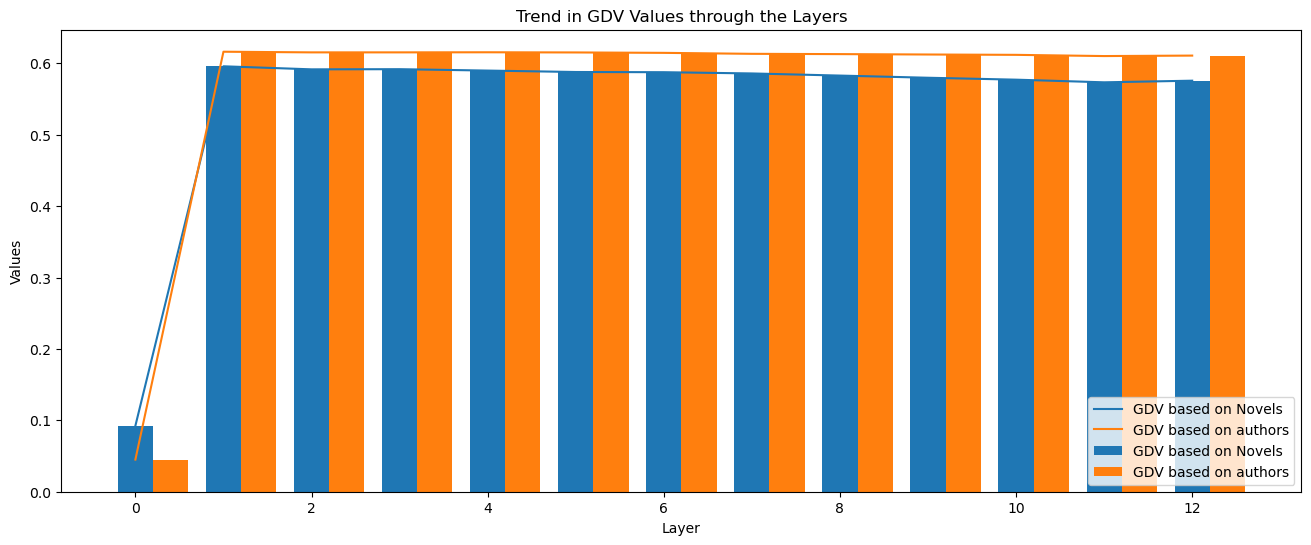

In [148]:
def plot_trend(list1, list2, list3=None, list4=None, labels=['list1', 'list2', 'list3', 'list4'], bar=False, title=None):
    x=range(len(list1))
    title = 'Trend in GDV Values through the Layers' if title is None else title
    plt.figure(figsize=(16,6))

    if list3 is None and list4 is None:
        if bar:
            plt.bar(x,list1,width=0.4,label=labels[0])
        plt.plot(list1,label=labels[0])
        if bar:
            plt.bar([i+0.4 for i in x],list2,width=0.4,label=labels[1])
        plt.plot(list2,label=labels[1])

        plt.xlabel('Layer')
        plt.ylabel('Values')
        plt.title(title)
    else:
        if bar:
            plt.bar(x,list1,width=0.4,label=labels[0])
        plt.plot(list1,label=labels[0])
        if bar:
            plt.bar([i+0.4 for i in x],list2,width=0.4,label=labels[1])
        plt.plot(list2,label=labels[1])
        if bar:
            plt.bar([i+0.4 for i in x],list3,width=0.4,label=labels[2])
        plt.plot(list3,label=labels[2])
        if bar:
            plt.bar([i+0.4 for i in x],list4,width=0.4,label=labels[3])
        plt.plot(list4,label=labels[3])

        plt.xlabel('Layer')
        plt.ylabel('Values')
        plt.title(title)

    plt.legend()

    plt.show()

plot_trend(loccf_n_all,loccf_a_all,labels=['GDV based on Novels','GDV based on authors'], bar=True)

#### LC Analysis for a single layer

In [63]:
result = projector.fit_transform(actmat[12])

In [65]:
loccf_n = GDV(
    mat = result,
    labels = novel_author_combo_idx,
    mode = 'n'
)
loccf_a = GDV(
    mat = result,
    labels = novel_author_combo_idx,
    mode = 'a'
)

print('Localisation Coefficient based on Novels: ',loccf_n)
print('Localisation Coefficient based on Writing-styles/Authors: ',loccf_a)

Localisation Coefficient based on Novels:  -0.13493143494861332
Localisation Coefficient based on Writing-styles/Authors:  0.12424348557299256


#### Read/Write localisation data

In [251]:
write(
    {
        'gdv_n' : gdvn_all,
        'gdv_a' : gdva_all
    },
    name = 'gdv_data_1000pt'
)

In [252]:
projdf = read(name = 'gdv_data_1000pt')
projdf

BaselineGDV_orig_n  BaselineGDV_orig_a     gdv_n     gdv_a
0                  NaN                 NaN  0.000000  0.000000
1            -0.659025            0.611601 -0.100984  0.051686
2            -0.654632            0.606407 -0.119455  0.050373
3            -0.672927            0.608400 -0.122520  0.054681
4            -0.825648            0.606904 -0.135900  0.048445
5            -0.857311            0.606838 -0.133901  0.054188
6            -0.846764            0.606484 -0.136151  0.047949
7            -0.917620            0.609046 -0.134282  0.050859
8            -0.949280            0.609006 -0.135186  0.049662
9            -0.948391            0.608669 -0.142097  0.047612
10           -0.918691            0.606448 -0.143418  0.043856
11           -0.899589            0.604407 -0.138195  0.048620
12           -0.870173            0.597949 -0.139177  0.042421

### Baseline trend visualisation

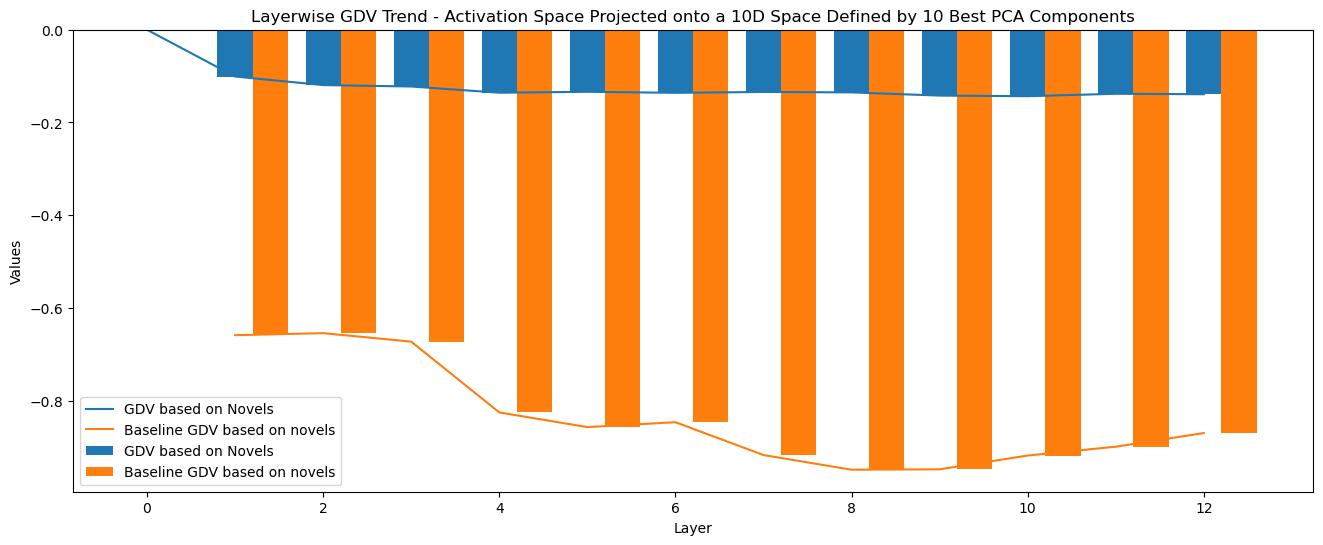

In [253]:
plot_trend(
    projdf['gdv_n'],
    #projdf['gdv_a'], 
    baselineGDVs_n, 
    #baselineGDVs_a, 
    labels=[
            'GDV based on Novels',
            #'GDV based on authors', 
            'Baseline GDV based on novels', 
            #'Baseline GDV based on authors'
            ], 
    bar=True,
    title="Layerwise GDV Trend - Activation Space Projected onto a 10D Space Defined by 10 Best PCA Components")

#### Save Localisation Plots

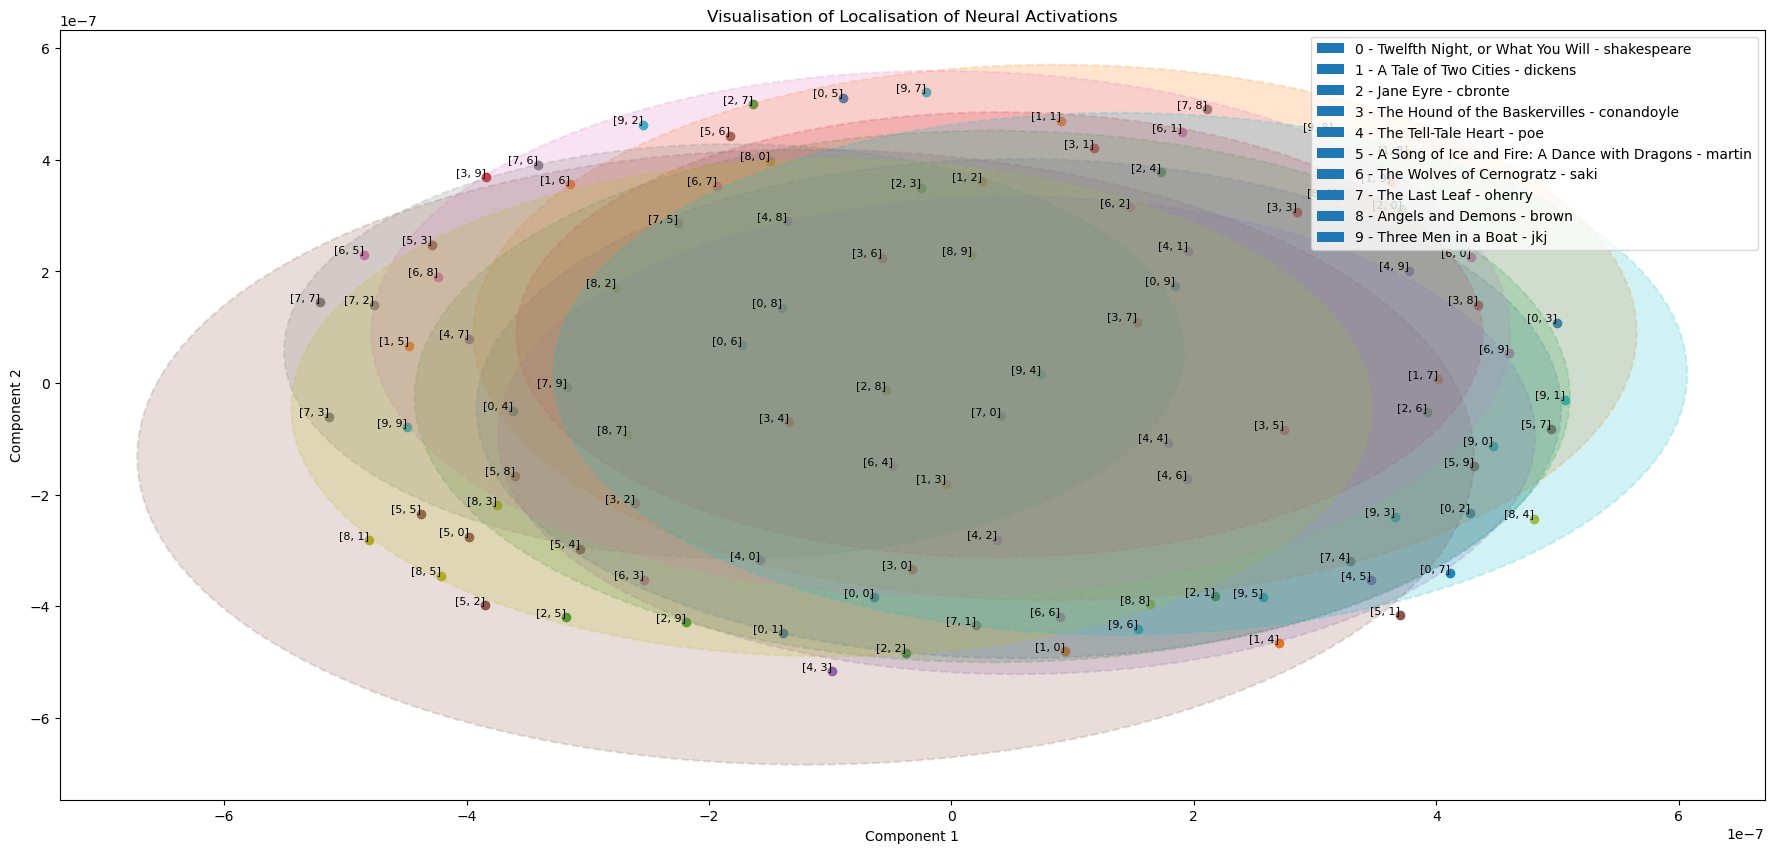

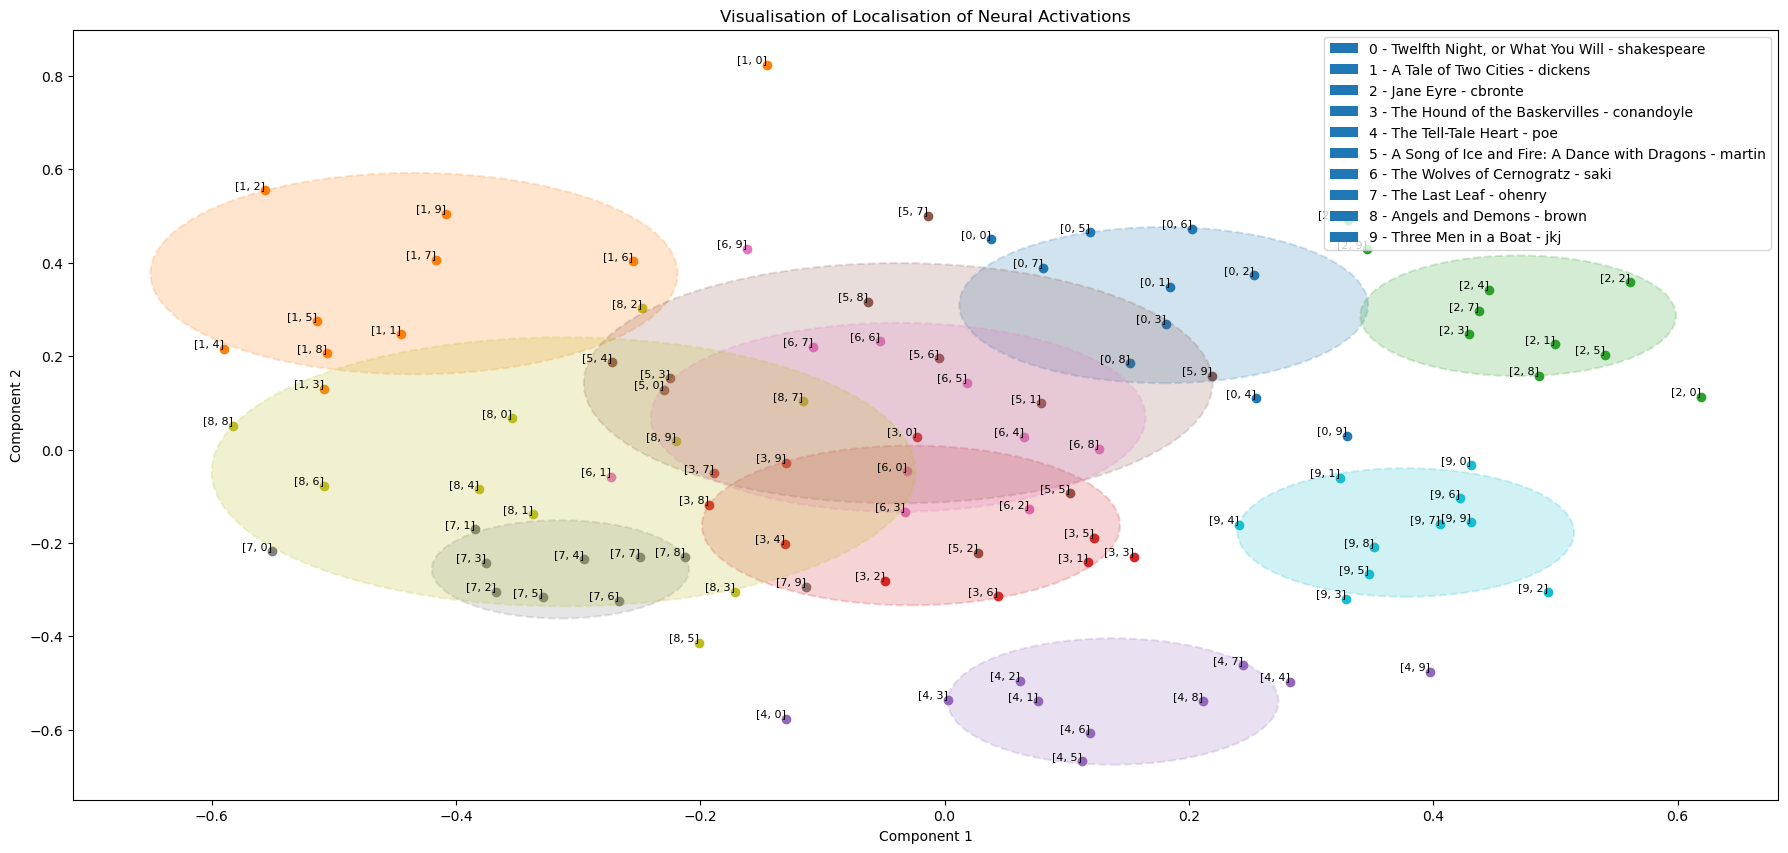

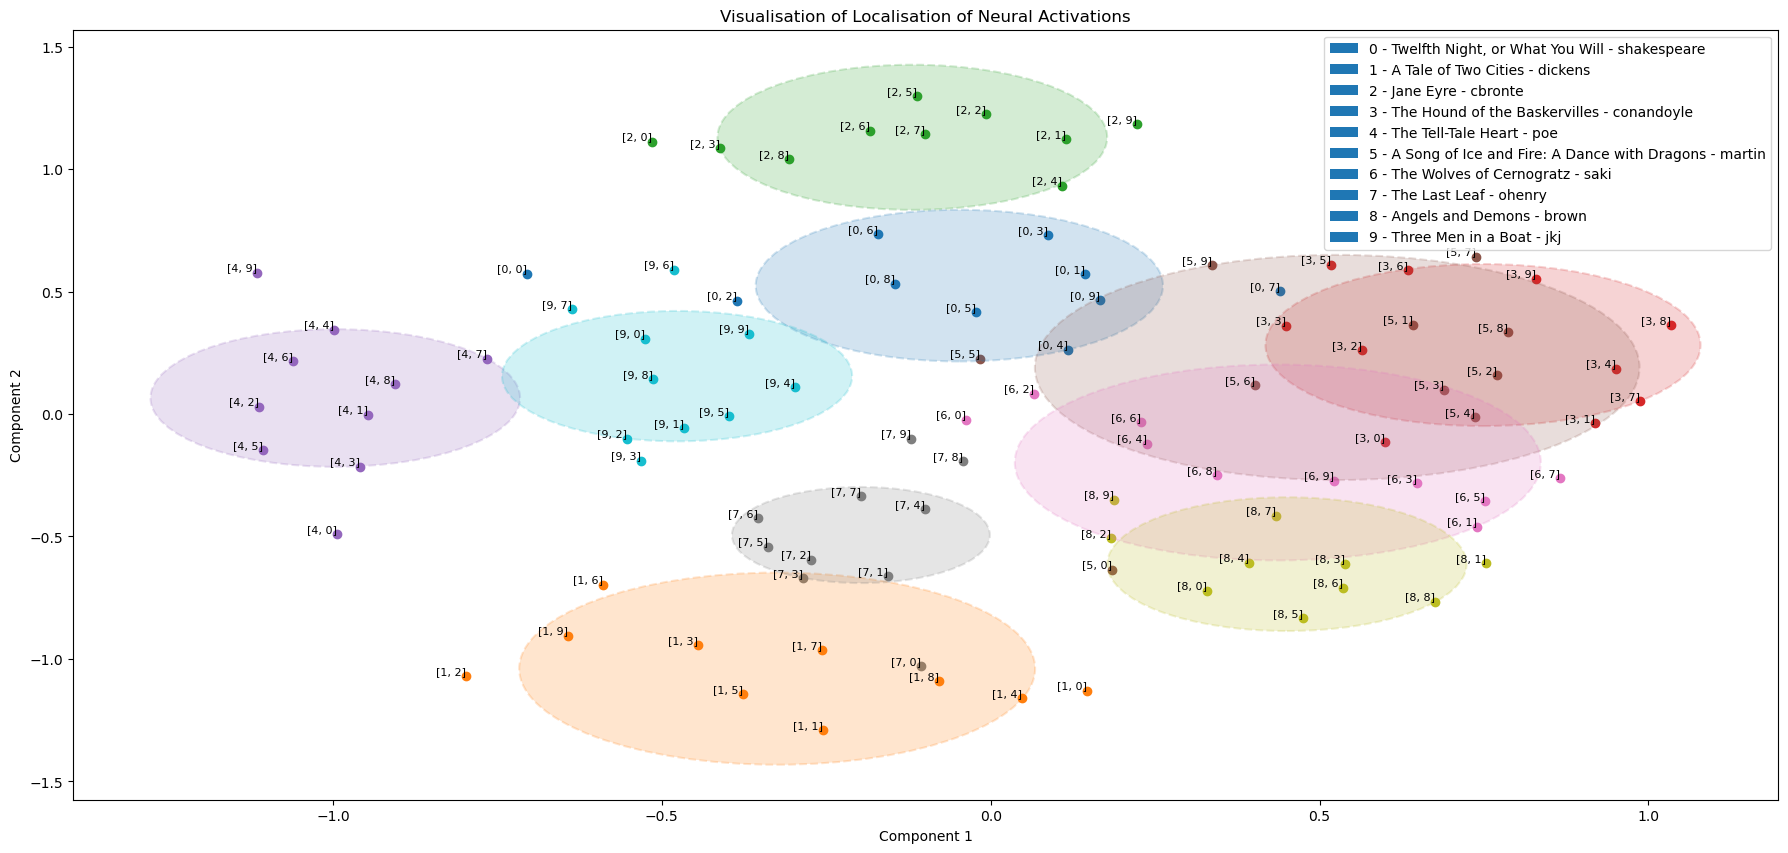

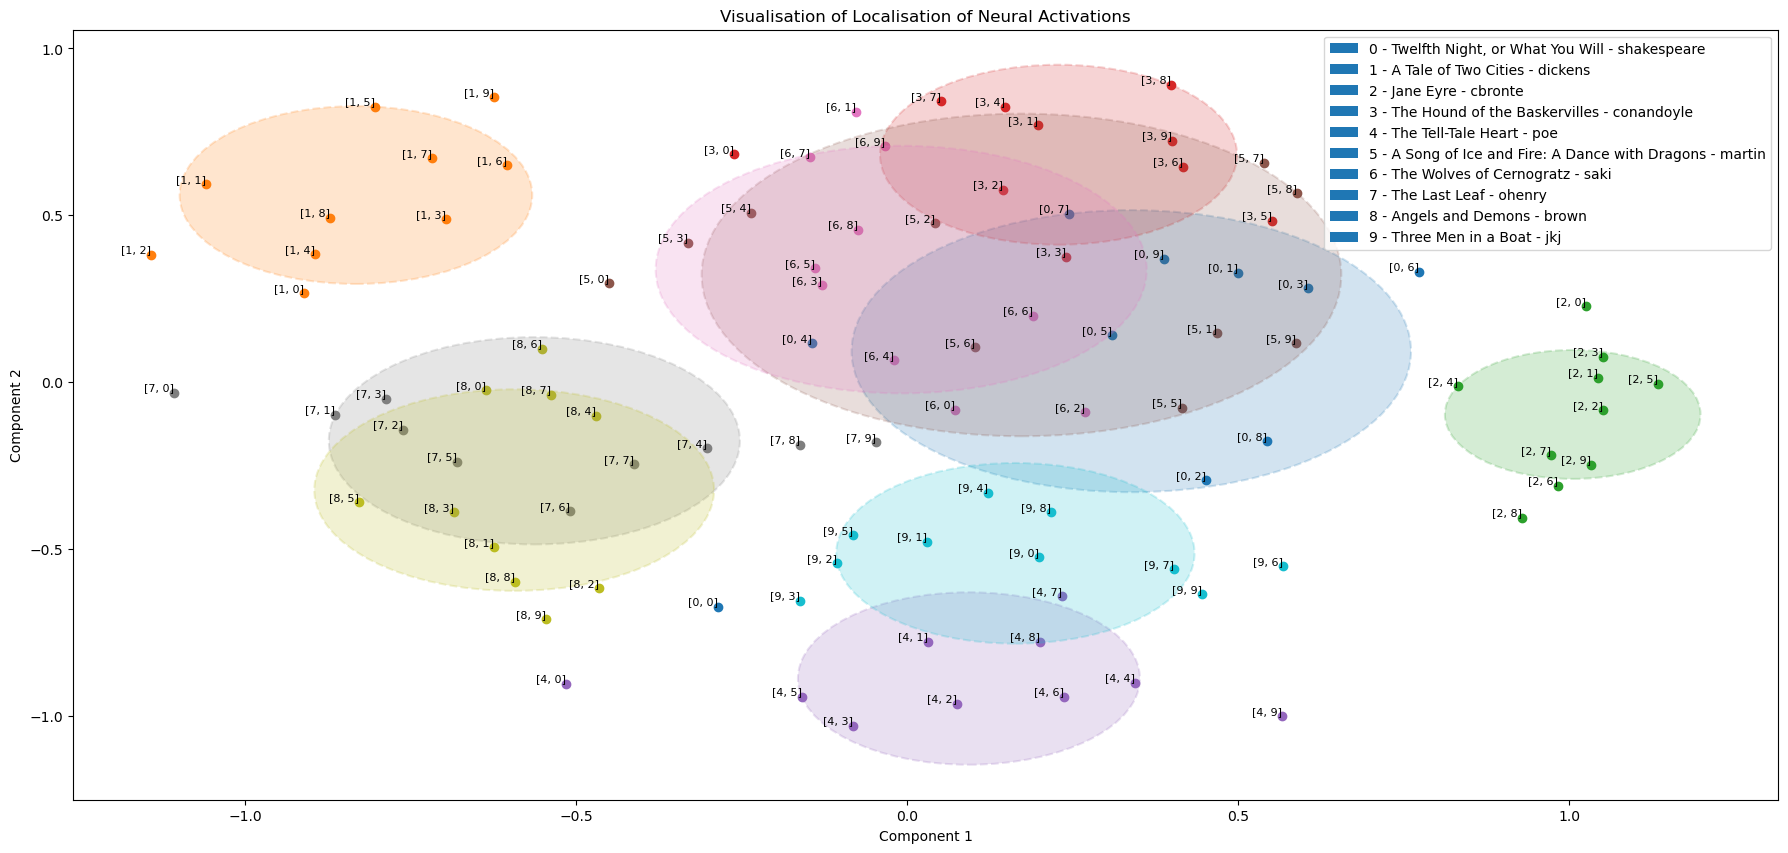

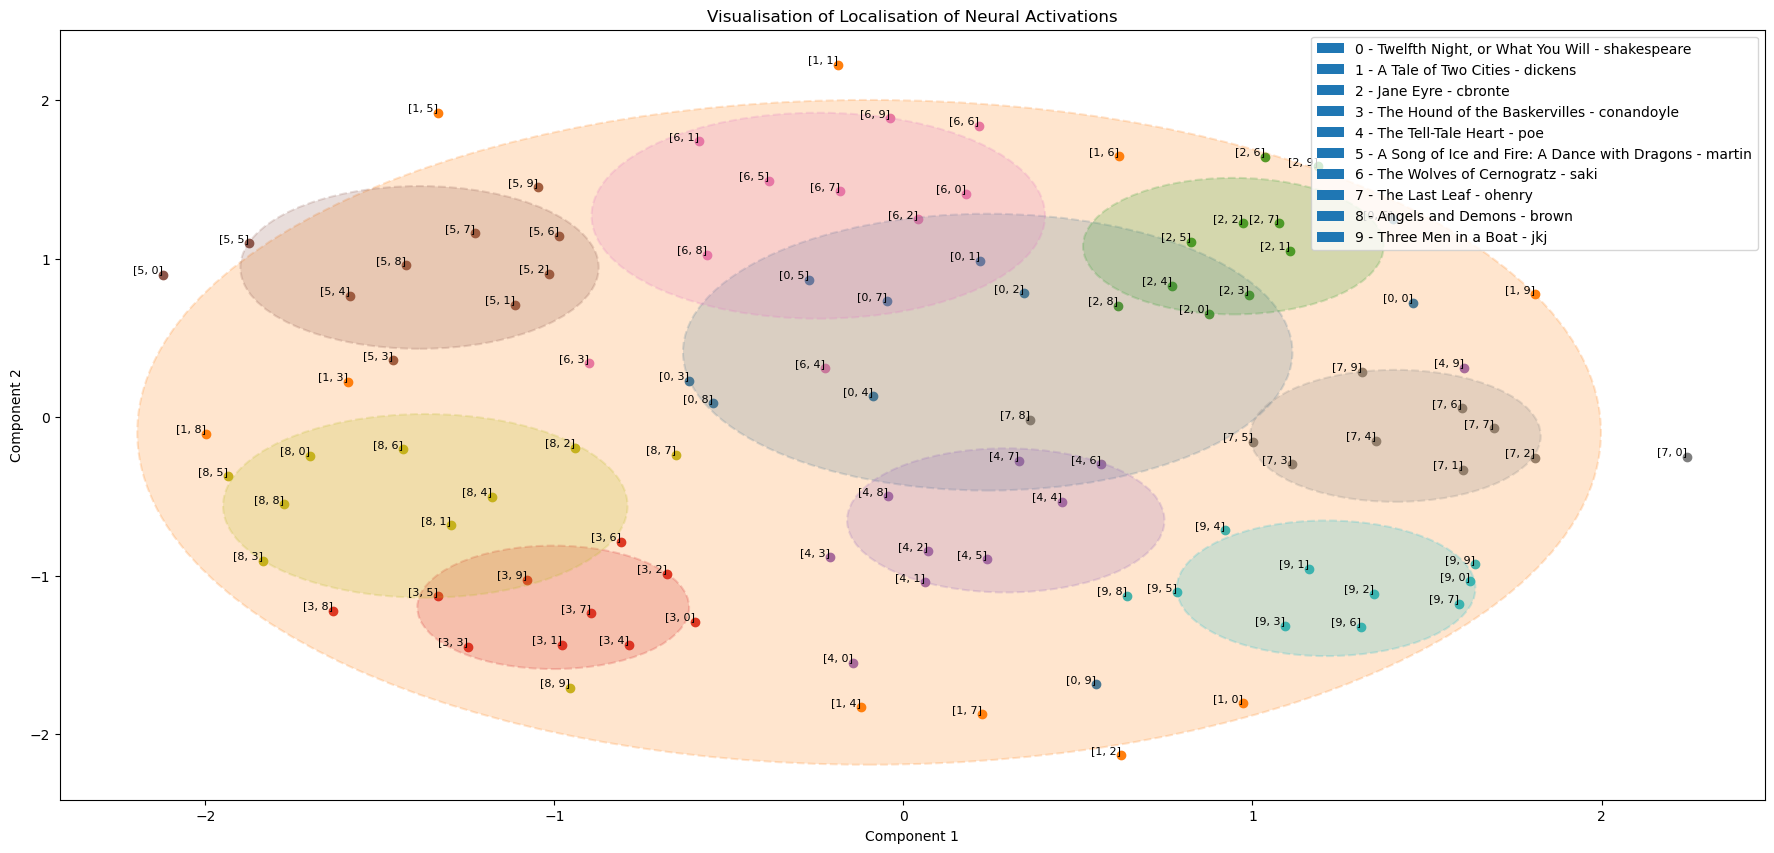

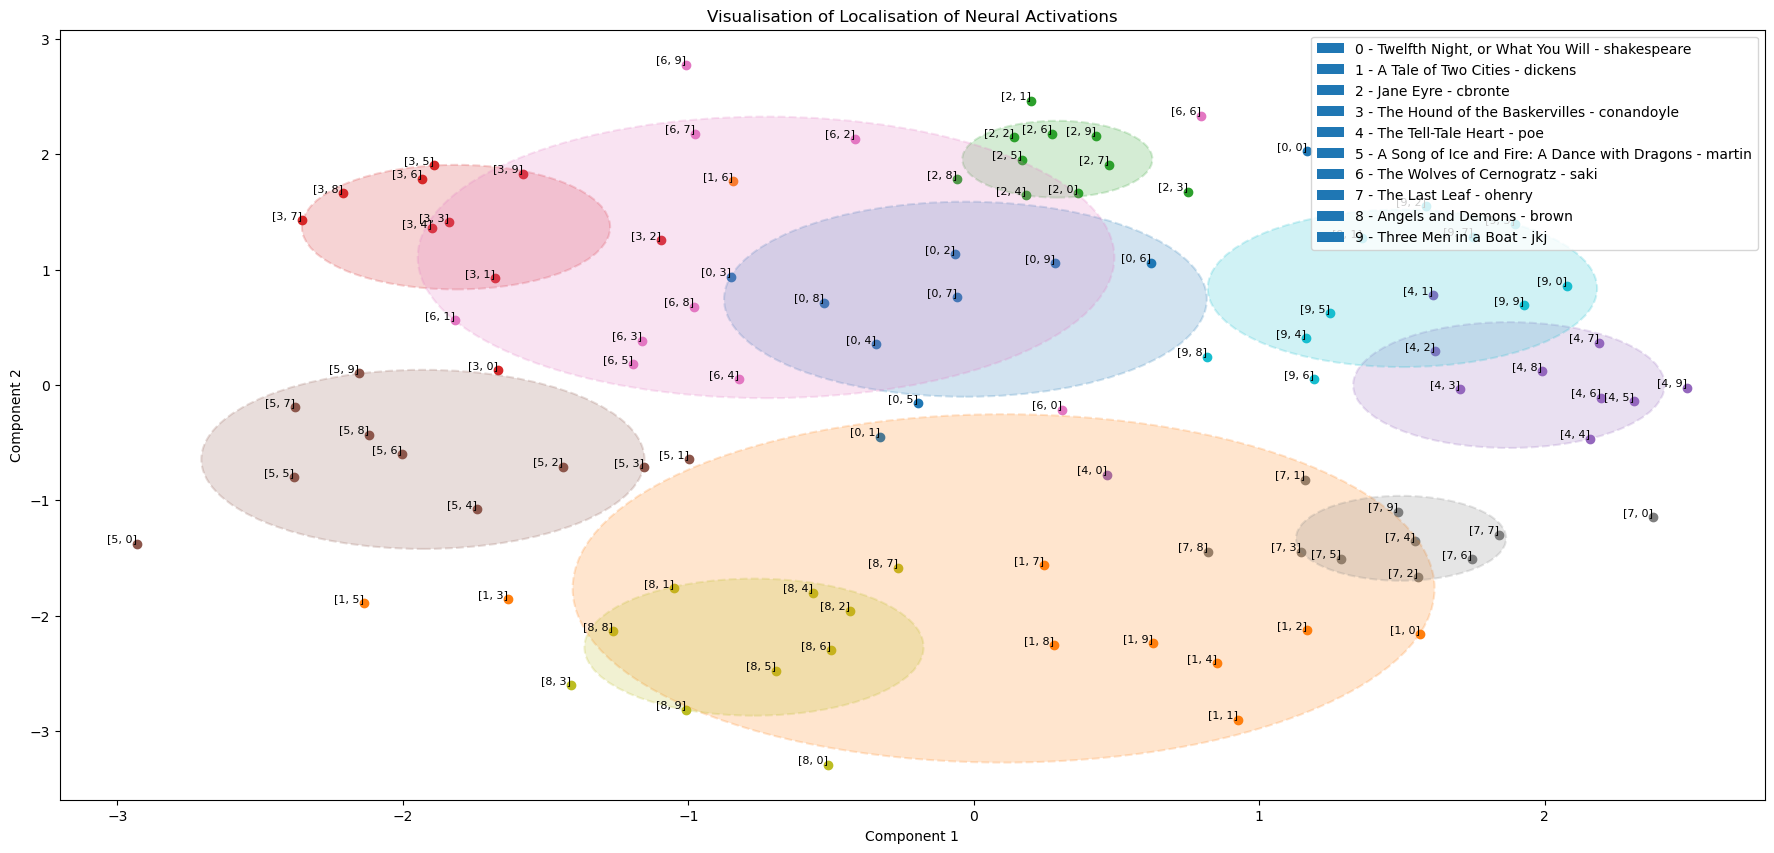

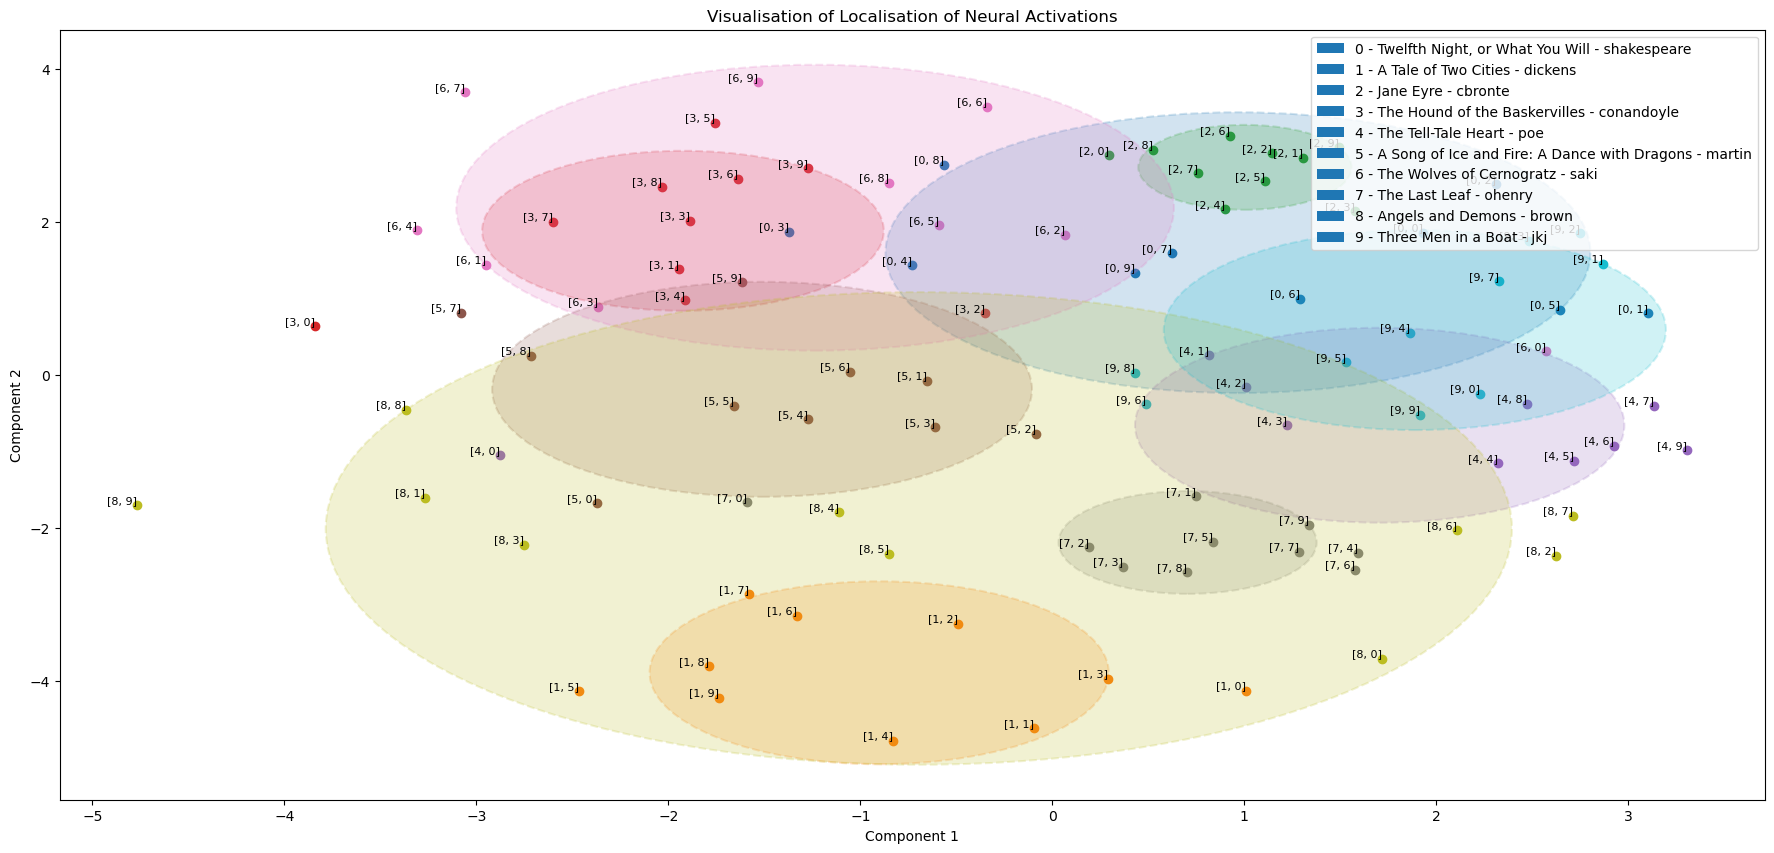

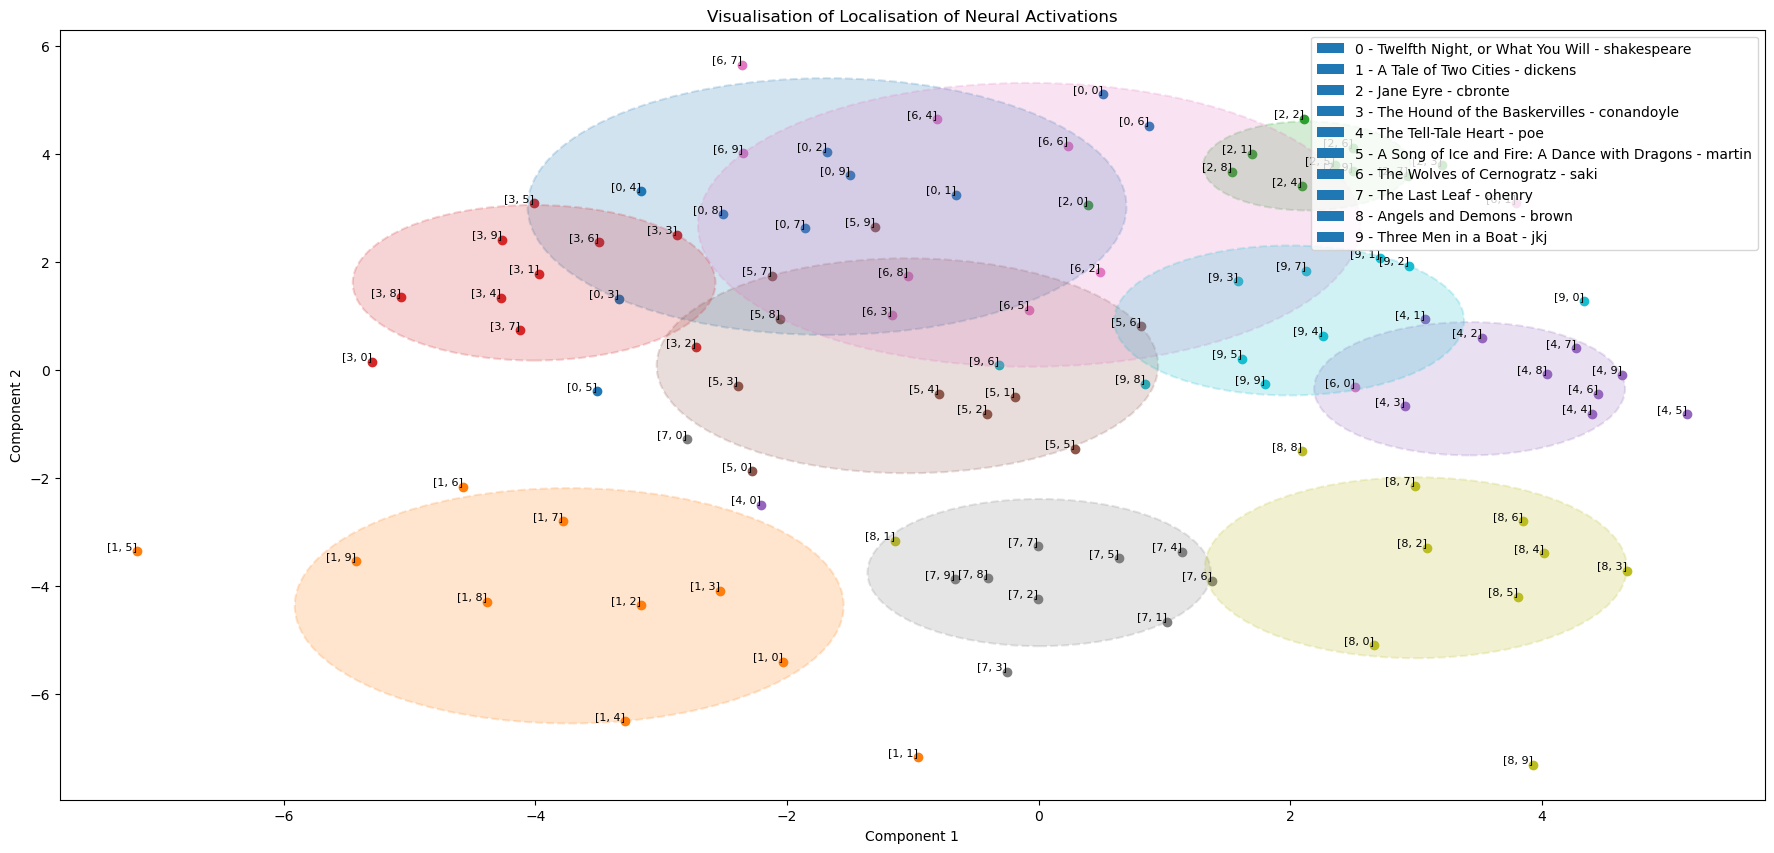

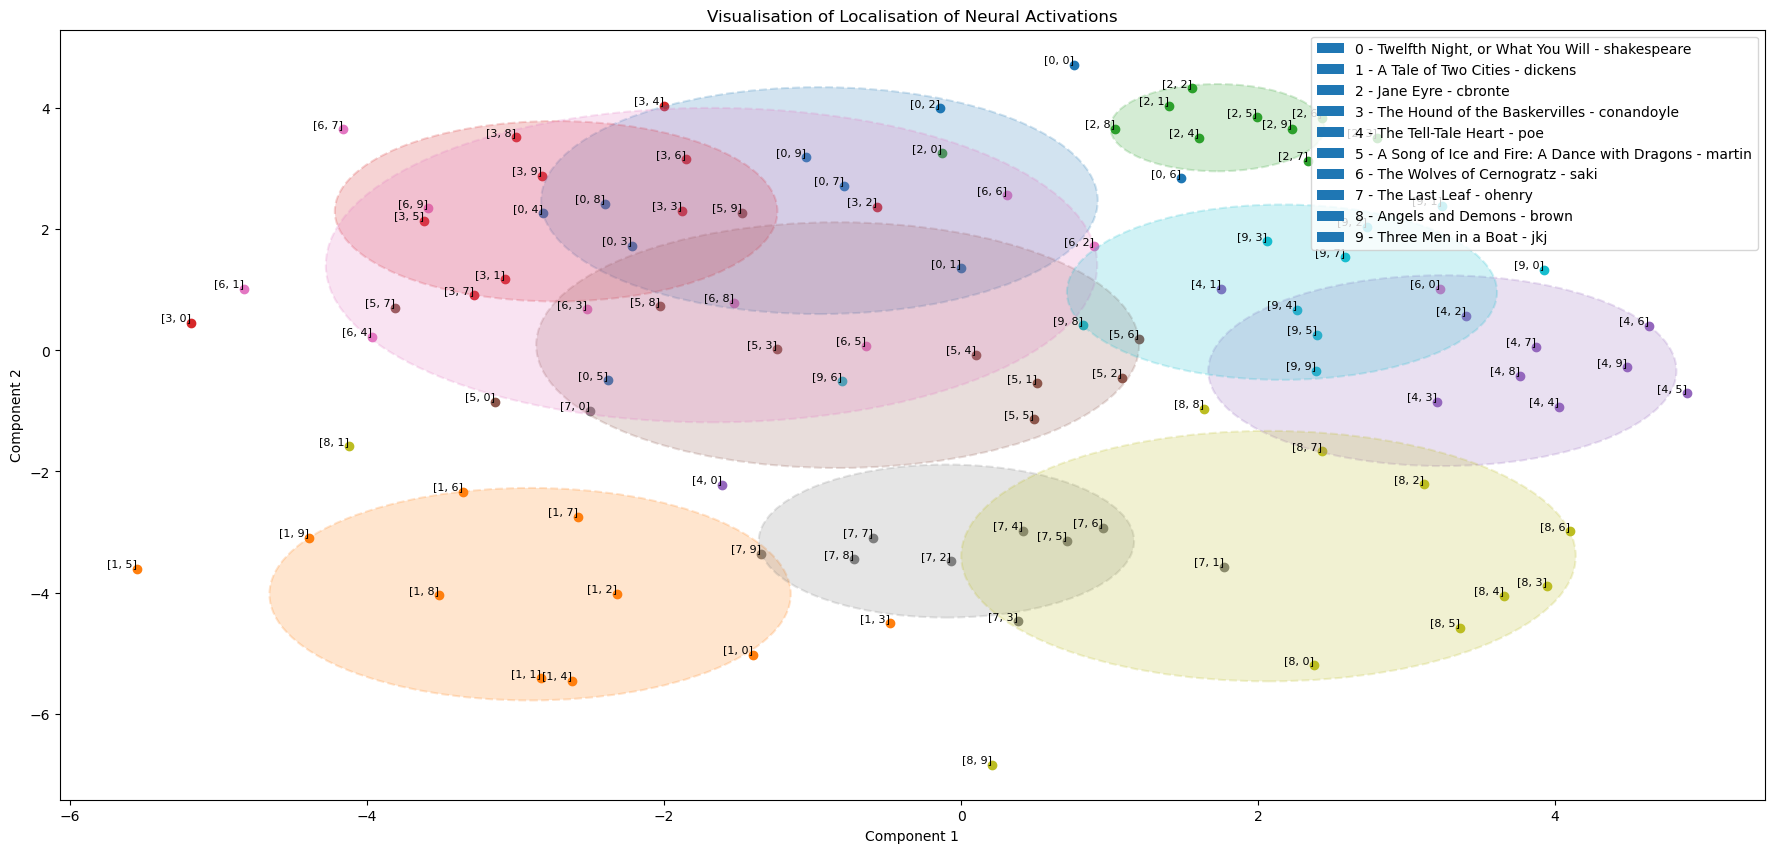

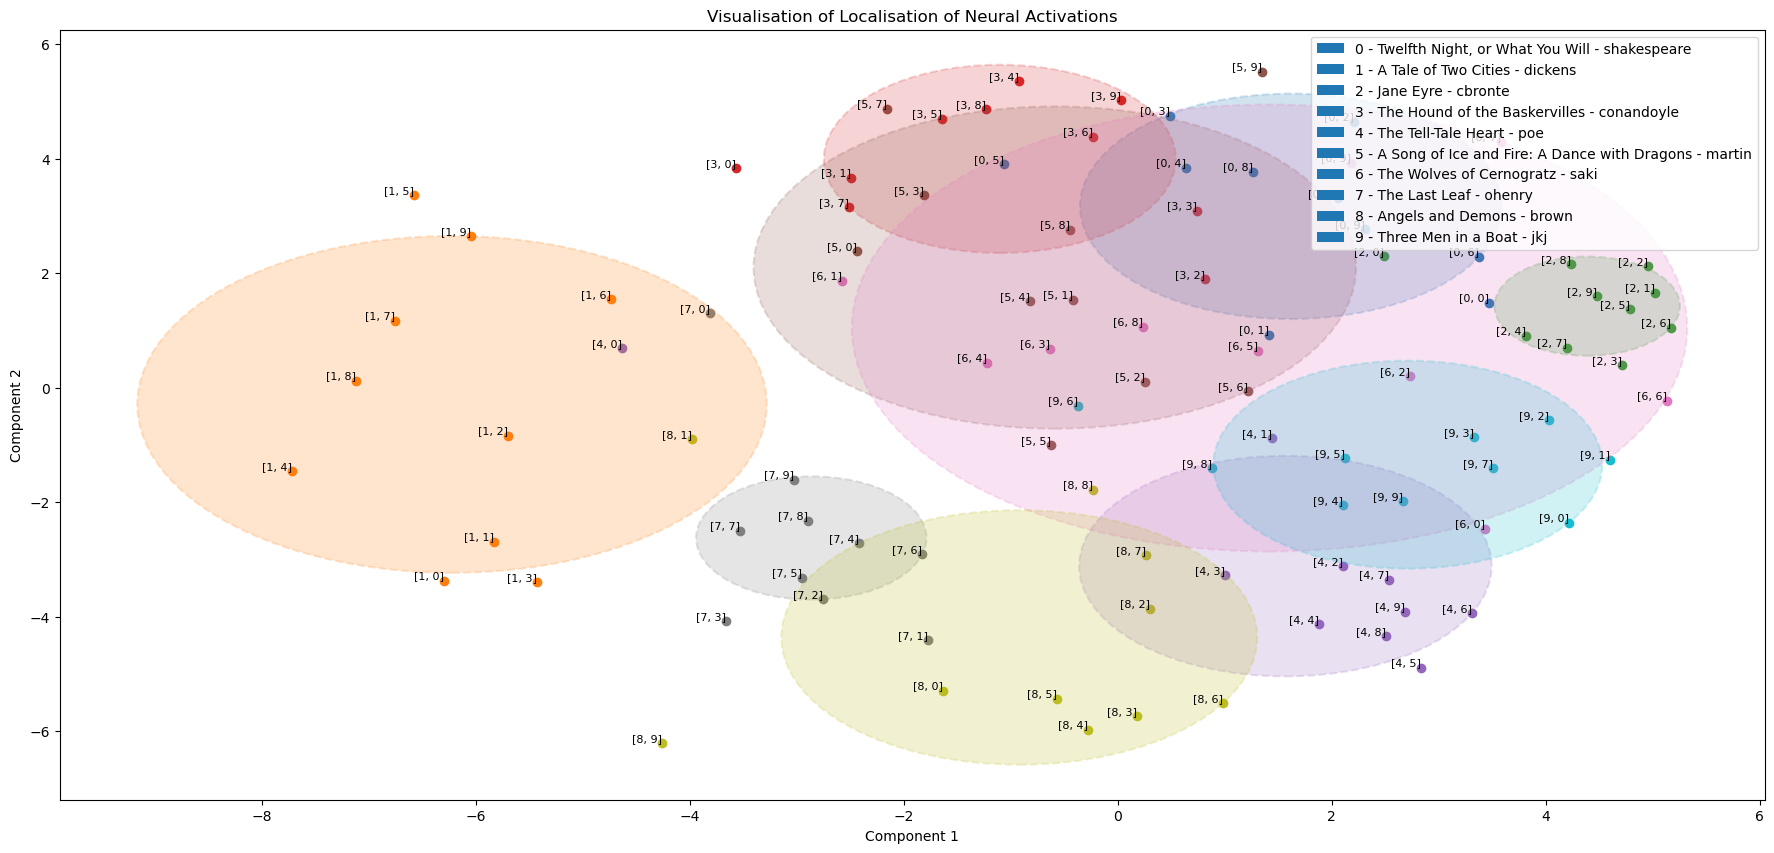

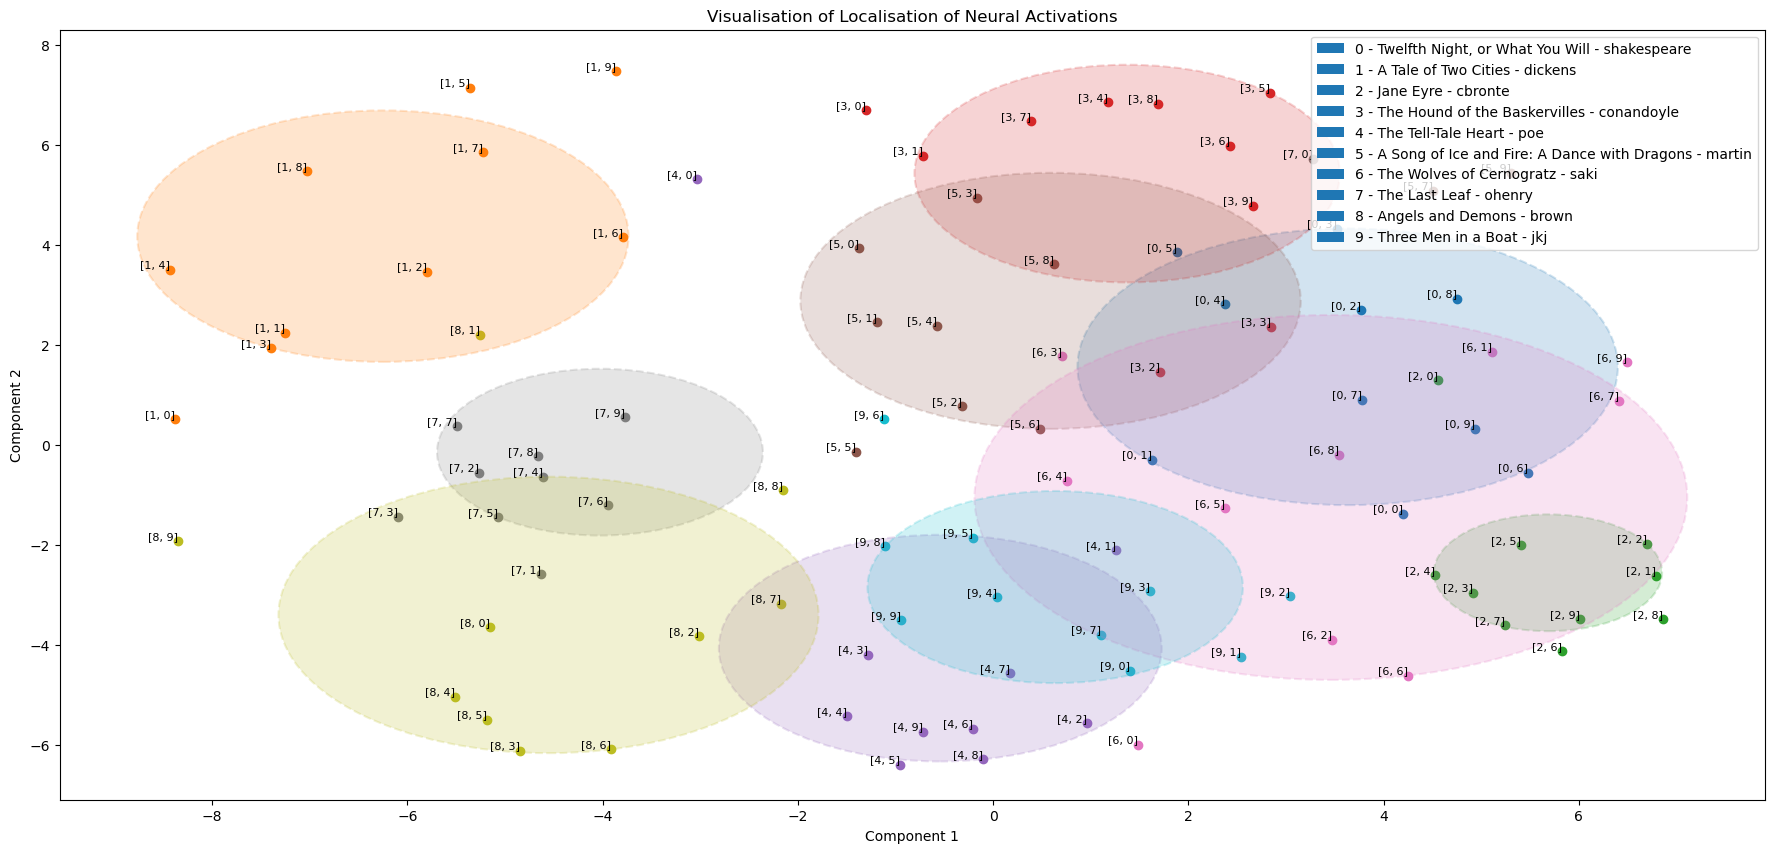

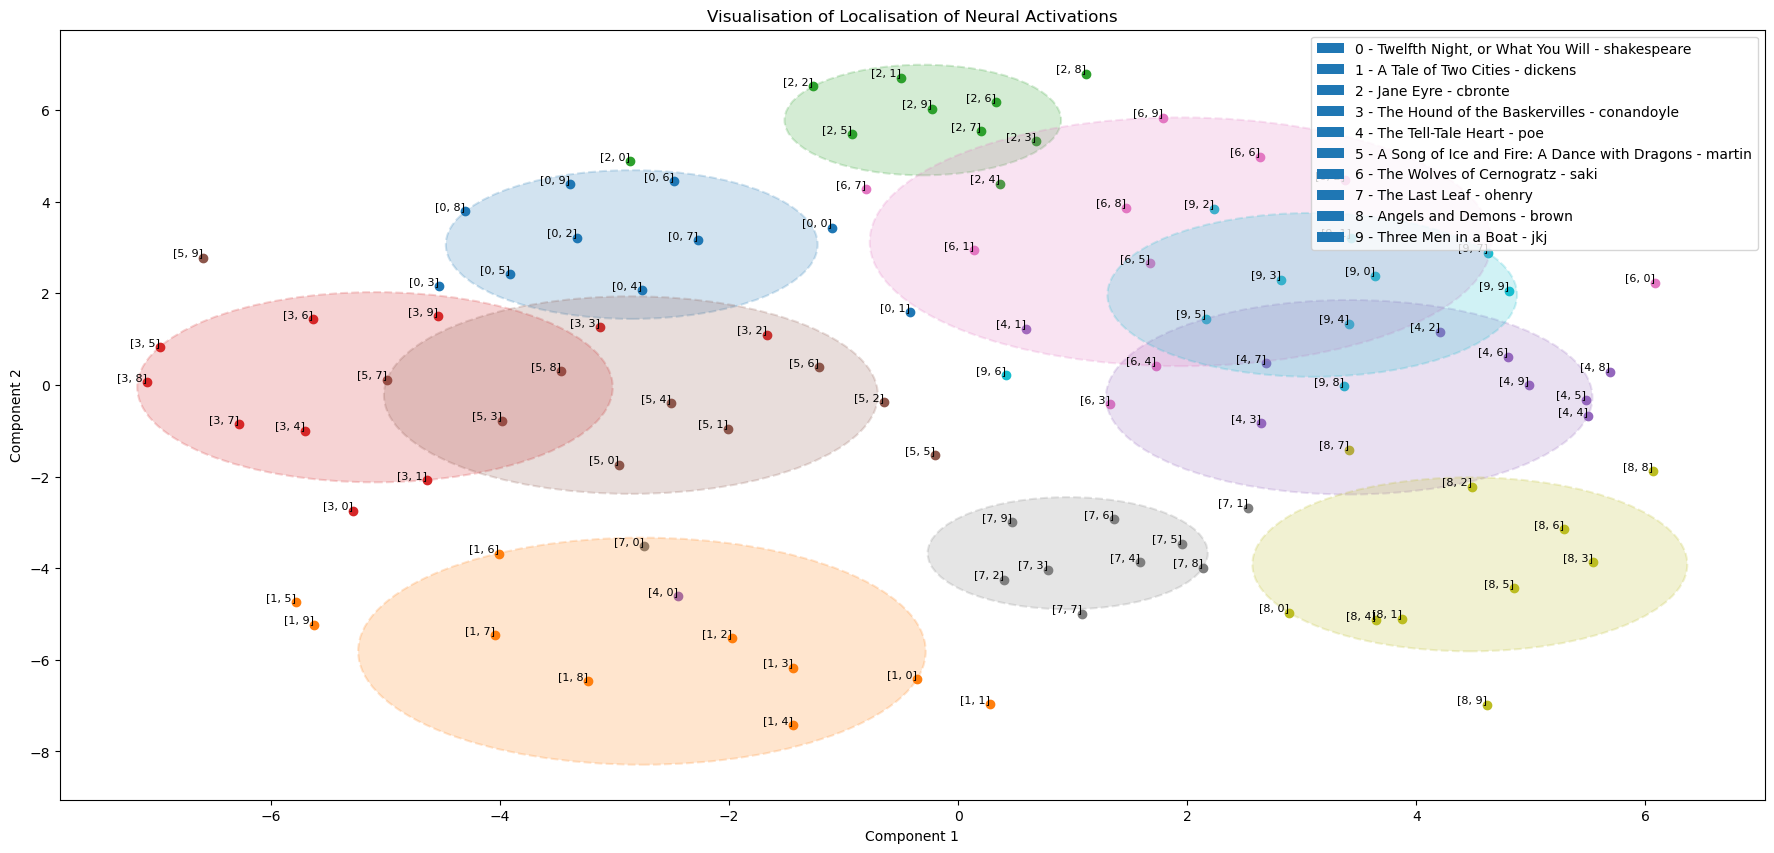

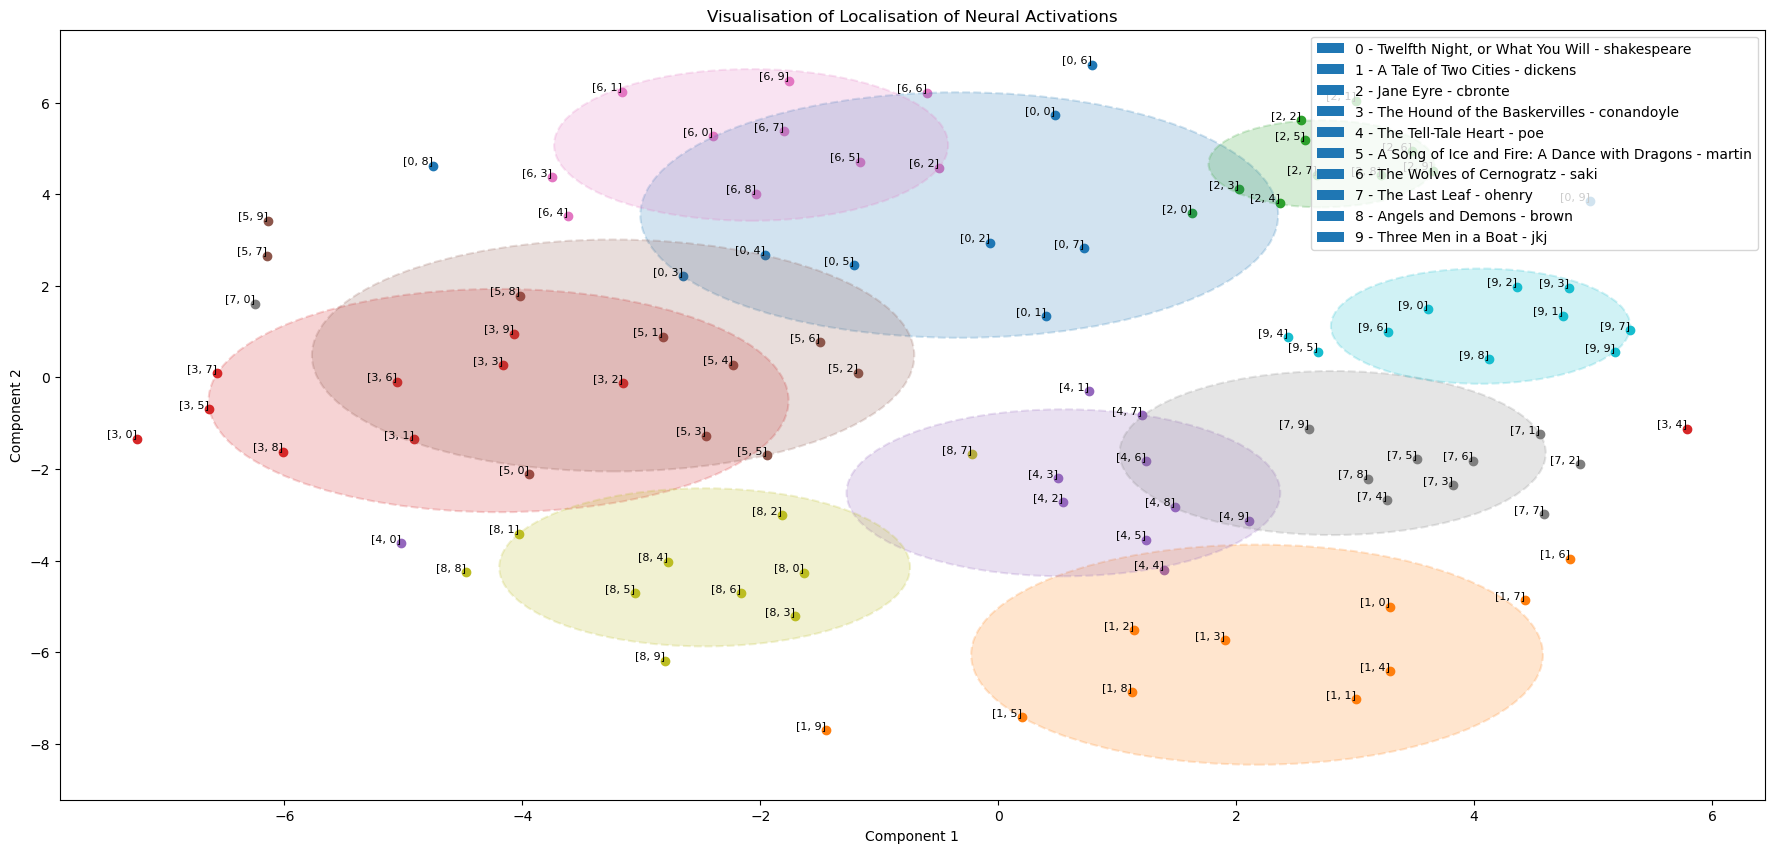

In [81]:
for i in range(num_layers):
    pca_result = projector.fit_transform(actmat[i])

    #plot_projection
    img = localisation(
        mat=pca_result,
        labels_idx=novel_author_combo_idx,
        combined_legend=combined_legend,
        mode='n',
        circ=True
    )
    img.savefig(os.path.join(os.getcwd(),'infographics','GDV', "PCA",'gpt_layer'+str(i+1)+'_gdv_n_100x100.png'))

### Visualization

In [199]:
result = projector.fit_transform(actmat[9])

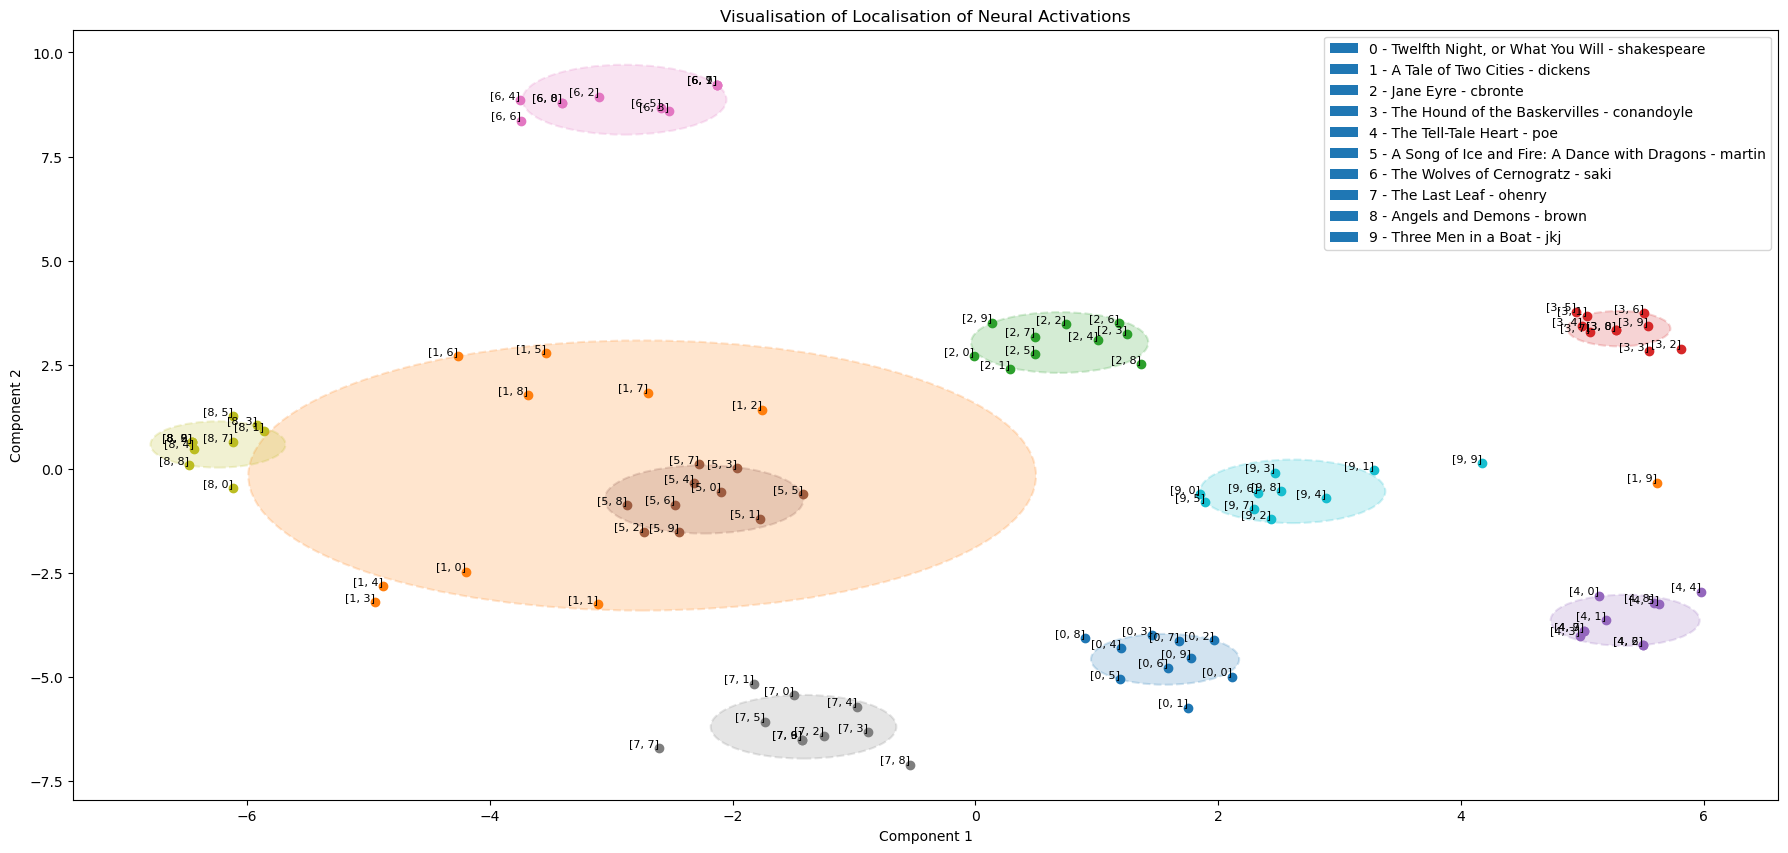

In [200]:
#plot_projection
_=localisation(
    mat=result,
    labels_idx=novel_author_combo_idx,
    combined_legend=combined_legend,
    mode='n',
    circ=True
)

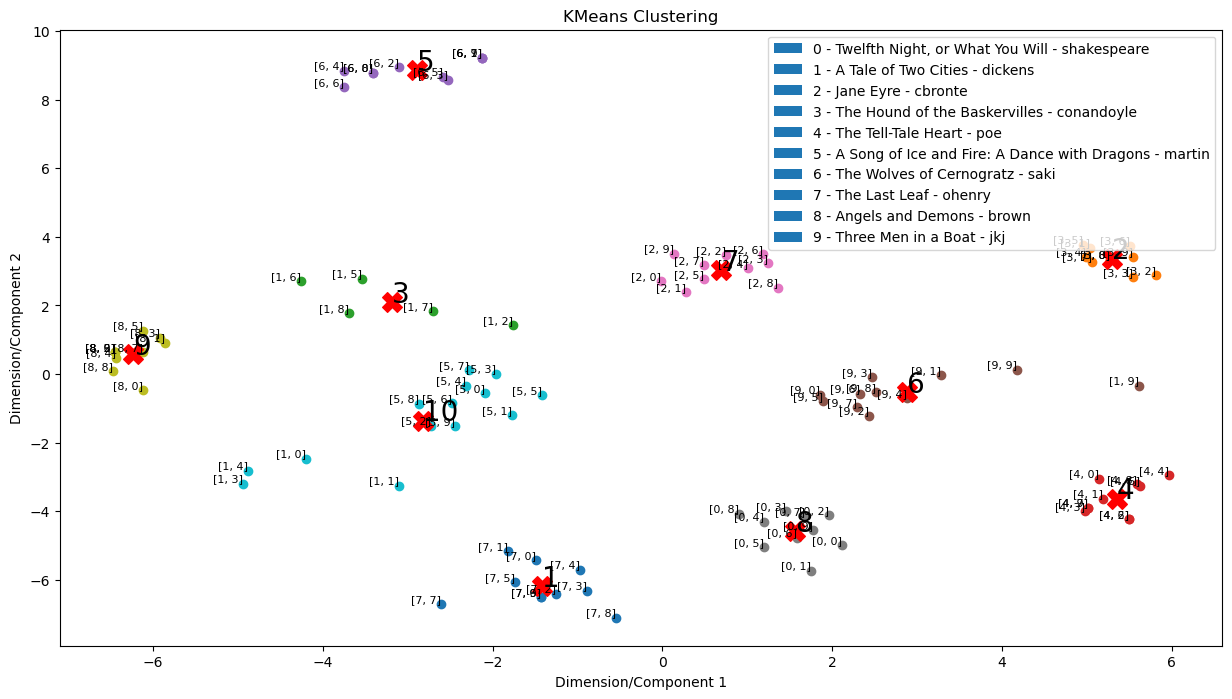

In [201]:
pca_cluster = cluster(n = 10, 
                      mat = result,
                      labels_idx = novel_author_combo_idx,
                      combined_legend=combined_legend,
                      viz=True)

Since localisation in neuronal activations is observed based on the novel and not the author/writing-style, so ideally there should be as many clusters as novels i.e., 10. Based on this, a  metric to quantify the strength of localisation can be devised which should be similar to the working principle of kmeans - the ratio of the sum of intercluster distances to the sum of intracluster distances should be way more than 50%; the higher the better - we can consider that there is some localisation if the strength value is at least more than 50%. This metric computed both for authors and novels, will give us 2 values - whicever one is higher will tell us the basis for the localisation - writing-style or the text itself. 

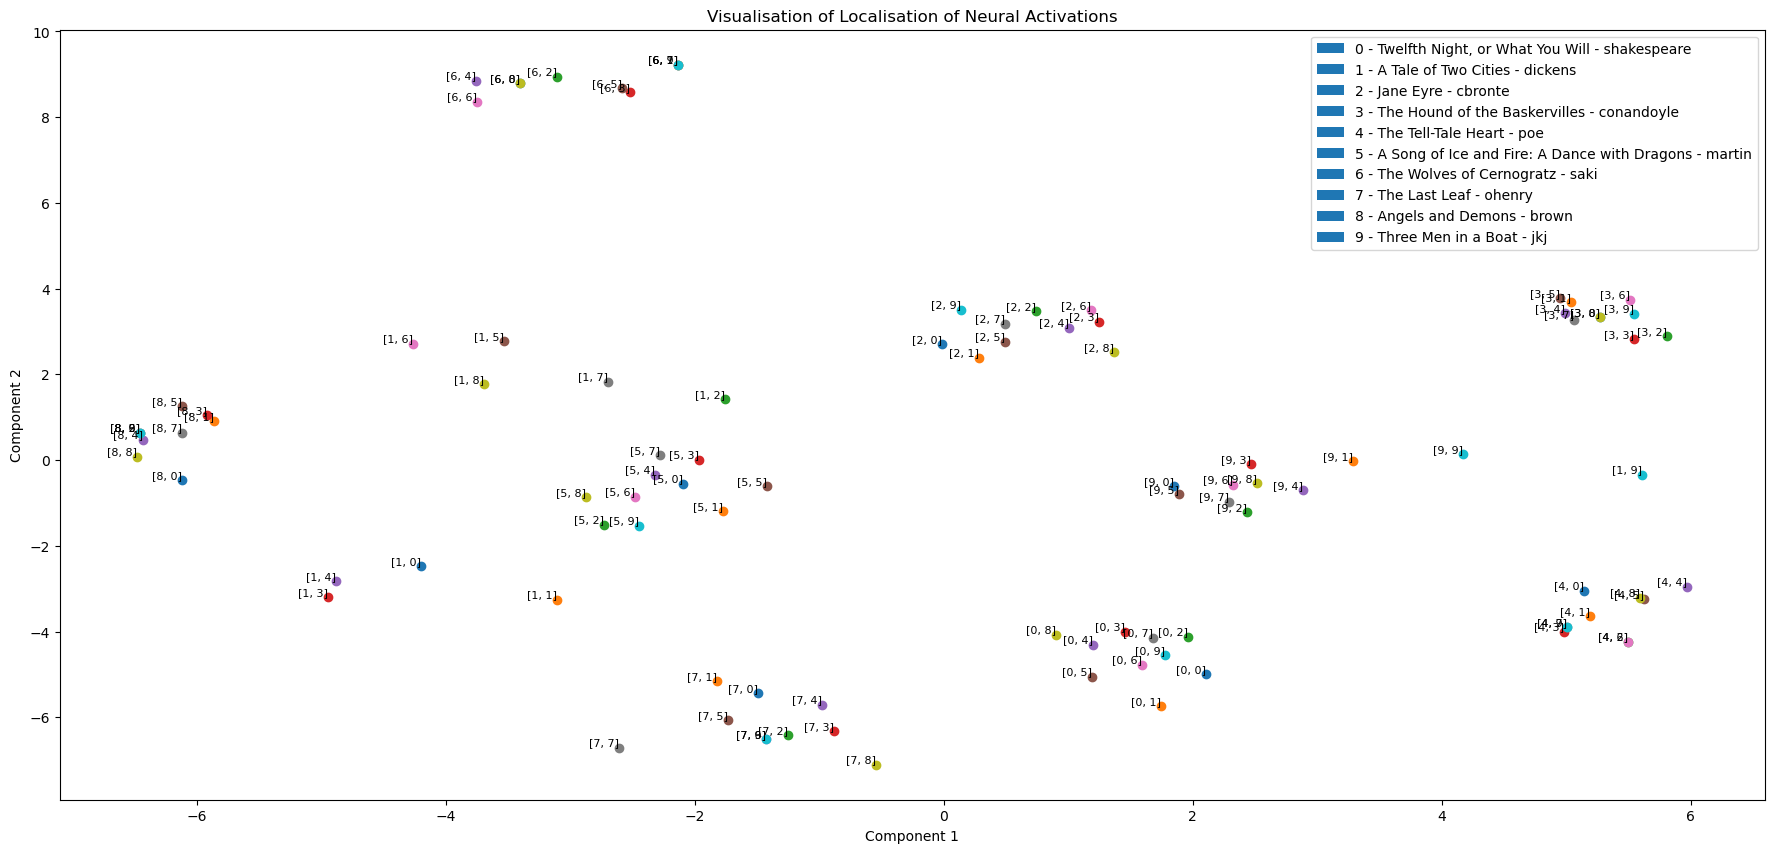

In [202]:
_=localisation(
    mat=result,
    labels_idx=novel_author_combo_idx,
    combined_legend=combined_legend,
    mode='a'
)